# Will have here a compendium of all the analysis that will make it into chapter 4 of my thesis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from pandas.api.types import CategoricalDtype
from scipy import stats
import scikit_posthocs as sp
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import BoundaryNorm
import itertools, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import scikit_posthocs as sp
from statannotations.Annotator import Annotator
from matplotlib.patches import Patch    

In [2]:
sns.set_context("paper", font_scale=1.75)

In [3]:
df = pd.read_pickle("./data/pre-processed-metrics-dataframe.pkl")

In [4]:
df.scheduler.unique()

array(['DYTAS[navigation=Front,sorting=DFS,multicore=SkipActiveProcessors]',
       'DYTAS[navigation=Front,sorting=Khan,multicore=SkipActiveProcessors]',
       'DYTAS[navigation=All,sorting=DFS,multicore=SkipActiveProcessors]',
       'DYTAS[navigation=All,sorting=Khan,multicore=SkipActiveProcessors]',
       'DYTAS[navigation=Front,sorting=DFS,multicore=UseAllCores]',
       'DYTAS[navigation=Front,sorting=Khan,multicore=UseAllCores]',
       'DYTAS[navigation=All,sorting=DFS,multicore=UseAllCores]',
       'DYTAS[navigation=All,sorting=Khan,multicore=UseAllCores]', 'HEFT',
       'DLS', 'DynamicList[task=CompSize,resource=Speed,cores=MaxCores]',
       'DynamicList[task=BottomLevel,resource=Speed,cores=MaxCores]'],
      dtype=object)

Selecting Only the primary 4 algorithms for my thesis

In [5]:
algorithms = [
    "HEFT",
    "DynamicList[task=BottomLevel,resource=Speed,cores=MaxCores]",
    "DYTAS[navigation=Front,sorting=Khan,multicore=SkipActiveProcessors]",
    "DYTAS[navigation=All,sorting=Khan,multicore=UseAllCores]"
]

df = df[df.scheduler.isin(algorithms)].reset_index(drop=True)

In [6]:
df.index

RangeIndex(start=0, stop=710208, step=1)

Renaming the algorithms.

In [7]:
rename_map = {
    "HEFT": "HEFT",
    "DynamicList[task=BottomLevel,resource=Speed,cores=MaxCores]":"Dynamic List",
    "DYTAS[navigation=Front,sorting=Khan,multicore=SkipActiveProcessors]": "DYTAS",
    "DYTAS[navigation=All,sorting=Khan,multicore=UseAllCores]": "Proposed-DYTAS"
}
df["scheduler"] = df.scheduler.map(rename_map)

In [8]:
df.scheduler.unique()

array(['DYTAS', 'Proposed-DYTAS', 'HEFT', 'Dynamic List'], dtype=object)

Making a consistent color map for each of them

In [9]:
df.workflow.unique()

array(['random', '1000genome', 'blast', 'bwa', 'cycles', 'epigenomics',
       'montage', 'seismology', 'soykb', 'srasearch'], dtype=object)

In [10]:
metrics_names = {
    'makespan':"Makespan", 
    'SLR':"SLR", 
    'speedup': "Speedup", 
    'efficiency_processors':"Processor Efficiency ",
    'efficiency_cores':"Cores Efficiency", 
    'exec_time':"Execution Time (seconds)"
}

cmap = {
    "HEFT":"#49c8d8",
    "Dynamic List":"#cf5b5b",
    "DYTAS":"#88d58b",
    "Proposed-DYTAS":"#cfa65b",
}
hue_order = list(cmap.keys())

# Sorting the dataframe per algorithm in the hue_order to avoid
# having to pass hue_order
df["scheduler"] = pd.Categorical(df["scheduler"],
                                categories=hue_order,
                                ordered=True)

workflow_order = ['random', 'soykb', 'epigenomics', 'montage', 'srasearch', 'cycles',
       'bwa', 'seismology', '1000genome', 'blast']

df["workflow"] = pd.Categorical(df["workflow"],
                                categories=workflow_order,
                                ordered=True)


df = df.sort_values(["scheduler", "workflow"])


df["workflow"] = df.workflow.astype(str)
df["scheduler"] = df.scheduler.astype(str)


In [11]:
# Creating a smaller dataframe with only a subset of the workflows

subset = ["random", "epigenomics", "montage", "seismology"]
df_presentacion = df[df.workflow.isin(subset)]

In [12]:
df_presentacion.workflow.unique()

array(['random', 'epigenomics', 'montage', 'seismology'], dtype=object)

# Non-Parametric Testing

## Kruskal-Wallis

In [13]:
def calculate_kruskal_wallis(df, metric):
    grouped_data = [group[metric].values for _, group in df.groupby('scheduler')]
    statistic, p_value = stats.kruskal(*grouped_data)
    return (statistic, p_value)
    

In [14]:
def kruskal_wallis_helper(df, metrics):
    results = {}
    for metric in metrics:
        res = calculate_kruskal_wallis(df, metric)
        
        results[metric] = res#(round(res[0]), res[1])
    return results

In [15]:
kruskal_all = kruskal_wallis_helper(df, metrics_names.keys())

In [16]:
kruskal_hom = kruskal_wallis_helper(df[df.system_type=="homogeneous"], metrics_names.keys())

In [17]:
kruskal_het = kruskal_wallis_helper(df[df.system_type=="heterogeneous"], metrics_names.keys())

In [18]:
kruskal_single_core = kruskal_wallis_helper(df[df.processor_count == df.core_count], metrics_names.keys())

In [19]:
kruskal_results = {
    "all":kruskal_all,
    "hom":kruskal_hom,
    "het":kruskal_het,
    "single-core":kruskal_single_core
}

In [20]:
kruskal_results

{'all': {'makespan': (12202.275726472051, 0.0),
  'SLR': (135478.4925829784, 0.0),
  'speedup': (68774.6242764425, 0.0),
  'efficiency_processors': (34603.348929190324, 0.0),
  'efficiency_cores': (16211.24522885083, 0.0),
  'exec_time': (114188.02730910489, 0.0)},
 'hom': {'makespan': (1562.4382782699693, 0.0),
  'SLR': (56328.87986124077, 0.0),
  'speedup': (12269.432965276452, 0.0),
  'efficiency_processors': (7166.226445227796, 0.0),
  'efficiency_cores': (3530.154585582476, 0.0),
  'exec_time': (57040.84614122583, 0.0)},
 'het': {'makespan': (12898.394396667, 0.0),
  'SLR': (102644.42639182294, 0.0),
  'speedup': (73158.89260003377, 0.0),
  'efficiency_processors': (37559.82485349713, 0.0),
  'efficiency_cores': (16085.537067596259, 0.0),
  'exec_time': (57227.071565684746, 0.0)},
 'single-core': {'makespan': (1421.3954129504475, 6.706725198846652e-308),
  'SLR': (9139.538982438717, 0.0),
  'speedup': (8771.444882066882, 0.0),
  'efficiency_processors': (4958.1835498033415, 0.0),


In [21]:
kruskal_results_df = pd.DataFrame(kruskal_results)

kruskal_results_df = pd.concat(
    [kruskal_results_df[col].apply(pd.Series).rename(columns={0: 'H_statistic', 1: 'p_value'}) for col in kruskal_results_df.columns],
    axis=1,
    keys=kruskal_results_df.columns
)

In [22]:
kruskal_results_df

all                   hom          \
                         H_statistic p_value   H_statistic p_value   
makespan                12202.275726     0.0   1562.438278     0.0   
SLR                    135478.492583     0.0  56328.879861     0.0   
speedup                 68774.624276     0.0  12269.432965     0.0   
efficiency_processors   34603.348929     0.0   7166.226445     0.0   
efficiency_cores        16211.245229     0.0   3530.154586     0.0   
exec_time              114188.027309     0.0  57040.846141     0.0   

                                 het           single-core                 
                         H_statistic p_value   H_statistic        p_value  
makespan                12898.394397     0.0   1421.395413  6.706725e-308  
SLR                    102644.426392     0.0   9139.538982   0.000000e+00  
speedup                 73158.892600     0.0   8771.444882   0.000000e+00  
efficiency_processors   37559.824853     0.0   4958.183550   0.000000e+00  
efficiency_cores        16085.537068     0.0   4958.183550   0.000000e+00  
exec_time               57227.071566     0.0  51179.292779   0.000000e+00

All of the above suggest that in every case, homogeneous, heterogeneous, and single core scenarios, there are statistically significant difference accross the algorithms. Further exploration will be done in Dunn's Post-hoc tests

## Dunn's Post-hoc tests
Controlling for the following systems:
- All
- Heterogeneous
- Homogeneous
- Single-Core

In [23]:
def dunns_tests_metrics(df, title, 
                        metrics = ['makespan', 'SLR', 'speedup',
                       'efficiency_cores', 'exec_time'],
                       p_adjust = 'fdr_bh'):

    n_metrics = len(metrics)
    n_cols = 2
    n_rows = int(np.ceil(n_metrics / n_cols))
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = axes.flatten()  # Flatten in case of single row
    
    # Loop through each metric and create a heatmap
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        # Perform Dunn's test
        dunn_results = sp.posthoc_dunn(df, val_col=metric, group_col='scheduler', 
                                       p_adjust=p_adjust)
        # print(dunn_results)
        # Reordering
        dunn_results = dunn_results[hue_order].reindex(index=hue_order)
        # Create heatmap
        bounds = [0, 0.05, 1]
        cmap = sns.color_palette("coolwarm", n_colors=len(bounds) - 1)
        norm = BoundaryNorm(boundaries=bounds, ncolors=len(cmap))
        sns.heatmap(dunn_results, annot=True, cmap=cmap, norm=norm, fmt=".2f", ax=ax)
        ax.set_title(f"P-values: {metrics_names[metric]}", pad=15)
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    # Remove any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


In [24]:
# dunns_tests_metrics(df, "Dunn's Test: Pairwise Comparisons Among Algorithms Across All Systems")

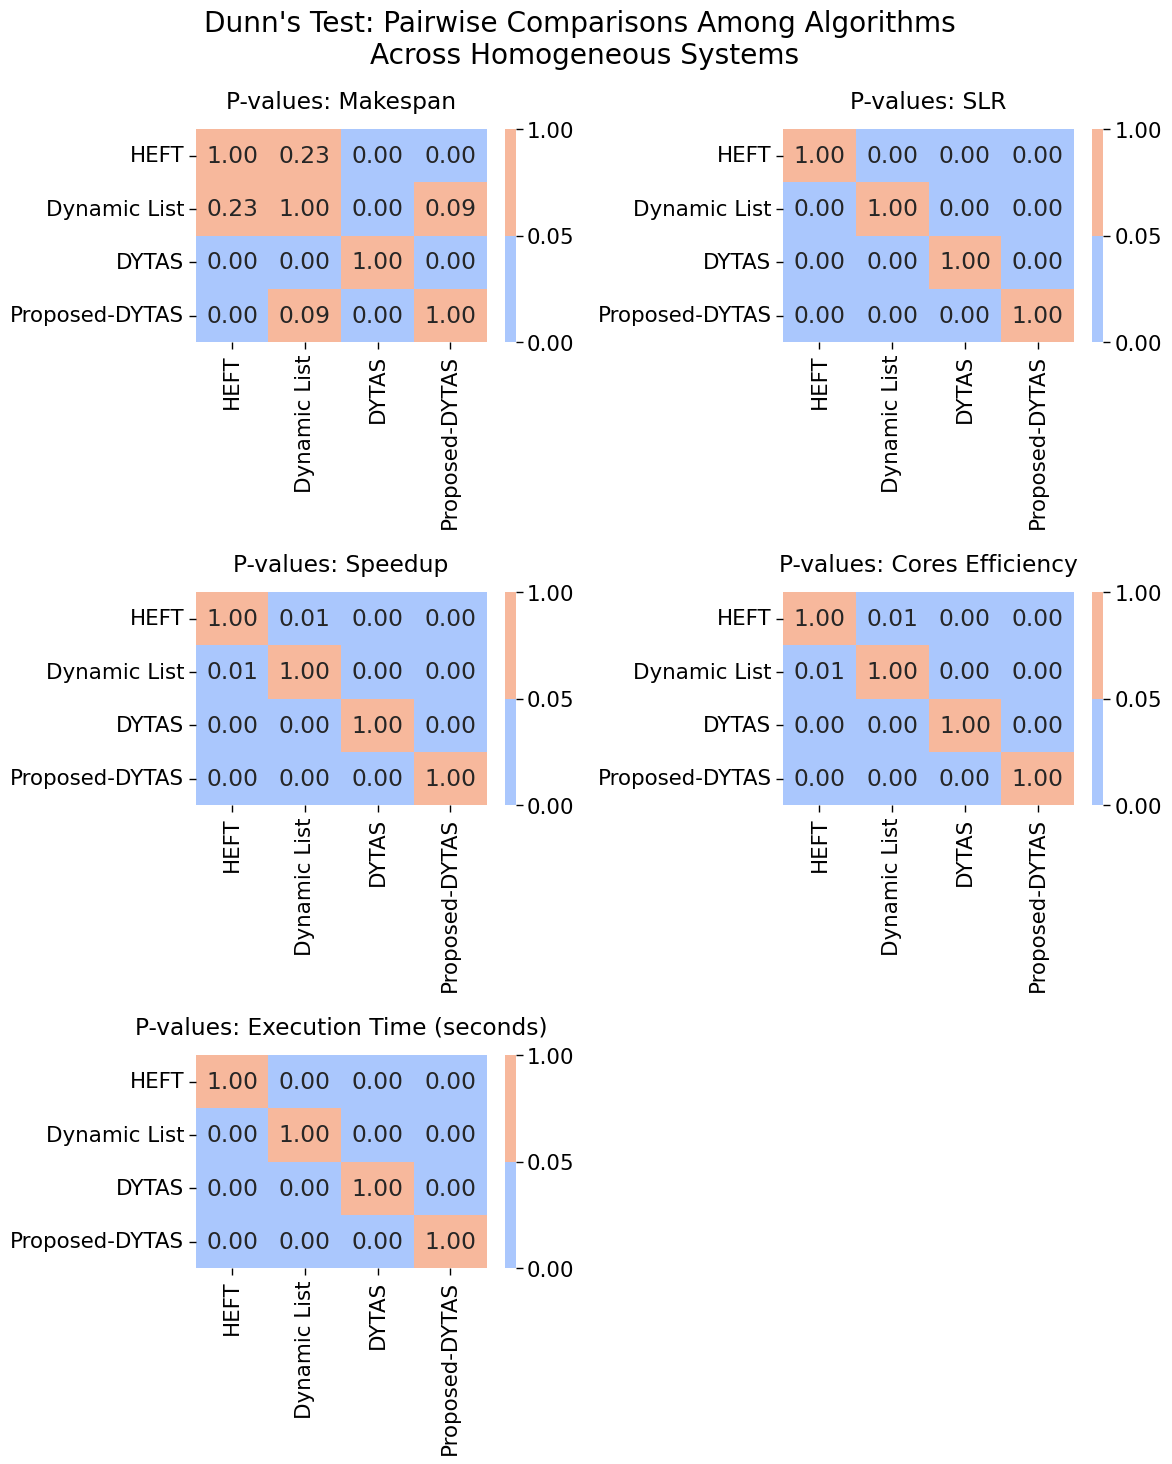

In [25]:
dunns_tests_metrics(df[df.system_type=="homogeneous"],
                    "Dunn's Test: Pairwise Comparisons Among Algorithms \nAcross Homogeneous Systems")

So for homogeneous system wee see that Dynamic List and the proposed-DYTAS improvements showed no statistically significant difference in terms of makespan, indicating that Proposed-DYTAS improves over base DYTAS in terms of makespan for Homogeneous systems.

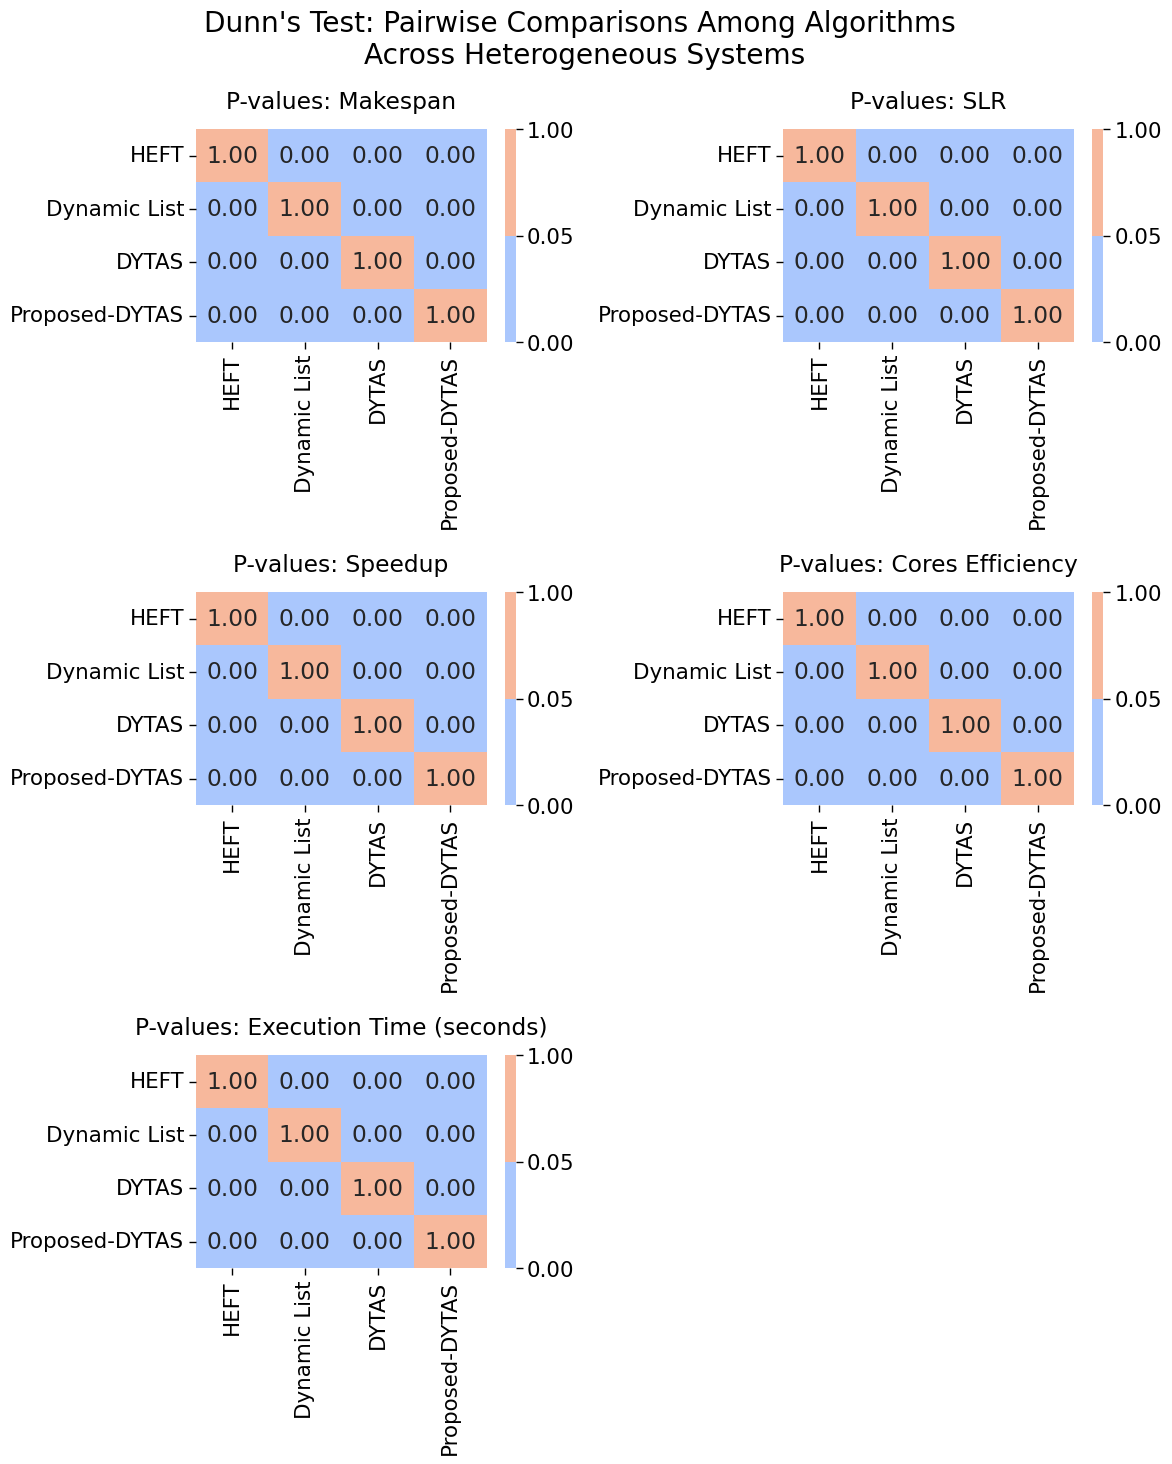

In [26]:
dunns_tests_metrics(df[df.system_type=="heterogeneous"],
                    "Dunn's Test: Pairwise Comparisons Among Algorithms \nAcross Heterogeneous Systems")

In [27]:
# dunns_tests_metrics(df[df.processor_count == df.core_count],
#                     "Dunn's Test: Pairwise Comparisons Among Algorithms Across Single-Core Systems")

The bove is important to see, as even in single-core processing systems, DYTAS and Proposed-DYTAS differ significantly. This, alongside our other visualizations, suggests that Proposed-DYTAS is still an improvement over base DYTAS evem in scenarios where the maximize core efficiency criteria is necessary. Meaning that just navigating the current processor's PTQ completely to queue a task before checking the next is a signficant improvement in makespan.

# Descriptive Overview

## Metric Distributions

In [28]:
df["SLR"].std()

1678.6364444441015

In [29]:
sum(df["makespan"] < 0) # Making sure there are no negative makespans

0

In [30]:
sum(df["makespan"] < 1) # Number of fractional makespan values

317

In [31]:
# sns.violinplot(data=df, x="SLR", hue="scheduler", palette=cmap)

Values are heavily skewed. For the sake of visualization, the Median Absolute Deviation (MAD) will be used to remove outliers.

In [32]:
def detect_outliers_mad(data, threshold=3.5):
    median = np.median(data)
    mad = np.median(np.abs(data-median))
    if mad == 0:
        return pd.Series([False] * len(series), index=series.index)
    modified_z_scores = 0.6745 * (data - median) / mad
    return np.abs(modified_z_scores) > threshold



In [33]:
df["makespan_outlier"] = df.groupby("scheduler")["makespan"].transform(detect_outliers_mad)

None of the test instances are the same after outlier removal with MAD method, thus possibly making this an unfair comparison accross the board

In [34]:
# sns.displot(data=df, x="makespan", hue="scheduler", palette=cmap)
# plt.xscale("log")  # Compress right tail
# plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

# plt.grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)


This log scale makes it easier to observer why the mayority of the test instances end up with such a low makespan. A more normal distribution can start to be obsertved at around the [10000,300000] range. This slighly alights with how the outliers are removed via the MAD method.

In [35]:
# sns.kdeplot(df[(df.makespan >10000)&(df.makespan < 300000)], x='makespan', hue="scheduler",hue_order=hue_order,
#                palette=cmap)

# plt.title("Distribution of Makespan per Algorithm (manual range)")

In [36]:
# sns.violinplot(df[(df.makespan >10000)&(df.makespan < 300000)], x='makespan', hue="scheduler",hue_order=hue_order,
#                palette=cmap)

# plt.title("Distribution of Makespan per Algorithm (manual range)")


In [37]:
# plt.figure(figsize=(6,6))
# sns.violinplot(data=df[df.makespan_outlier == False], x="makespan", 
#                hue="scheduler", 
#                hue_order=hue_order,
#                palette=cmap)
# plt.legend(
#     title="Algorithm",
#     bbox_to_anchor=(1.05, 1),  # X=1.05 (right), Y=1 (top)
#     loc='upper left',
#     borderaxespad=0.
# )
# plt.title("Distribution of Makespan per Algorithm (outliers removed via MAD)")
# plt.show()

After removing outliers with the mad method for makespan values we can more clearly visualize the distributions. It is easy to see how the medians of HEFT and Dynamic List are close together, with Dynamic List having a higher tail (more extreme values). On the other hand, we see that the median of DYTAS is the highest out of all, and has more extreme values, whilst the Improved version of DYTAS spans a lower median and extremes, which aproximates more how dynamic list is distributed.

## Testing what is impacting outlying results
To make sure it is understood why there exists certain makespan results that are grouped in such a way, and how they differ from the non outlying data.

In [38]:
# plt.figure(figsize=(6,6))
# sns.violinplot(data=df[df.makespan_outlier == True], x="makespan", 
#                hue="scheduler", 
#                hue_order=hue_order,
#                palette=cmap)
# plt.legend(
#     title="Algorithm",
#     bbox_to_anchor=(1.05, 1),  # X=1.05 (right), Y=1 (top)
#     loc='upper left',
#     borderaxespad=0.
# )
# plt.title("Distribution of Makespan per Algorithm (outliers ONLY, via MAD)")
# plt.show()

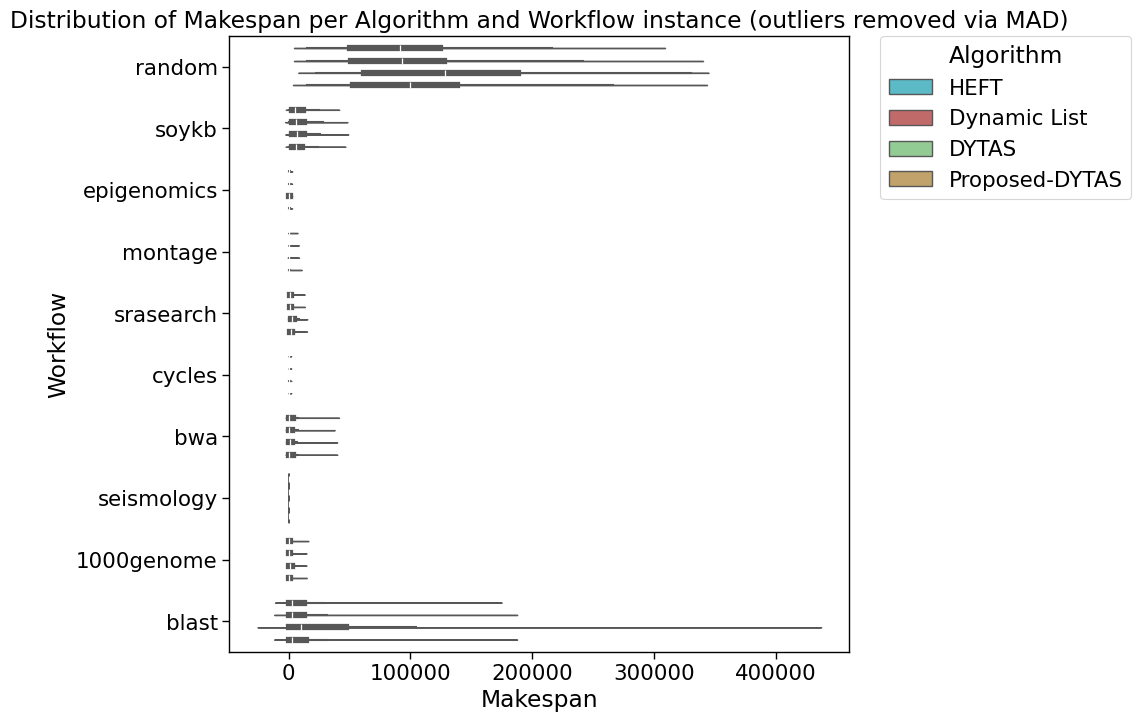

In [39]:
plt.figure(figsize=(8,8))
sns.violinplot(data=df[df.makespan_outlier == False], x="makespan", 
               hue="scheduler",
               y="workflow",
               hue_order=hue_order,
               palette=cmap)
plt.legend(
    title="Algorithm",
    bbox_to_anchor=(1.05, 1),  # X=1.05 (right), Y=1 (top)
    loc='upper left',
    borderaxespad=0.
)
plt.xlabel("Makespan")
plt.ylabel("Workflow")
plt.title("Distribution of Makespan per Algorithm and Workflow instance (outliers removed via MAD)")
plt.show()

The above graph further confirms that the makespan distribution should be analyzed per workflow/DAG type for better redability.

In [40]:
def plot_distribution(df, metric, title=None):

    if title == None:
        title = metrics_names[metric] + " per Algorithm"
    
    g = sns.violinplot(df, x=metric, hue="scheduler", hue_order=hue_order,
                  palette=cmap, orient='h').set(
        title=title,
        xlabel=metrics_names[metric]
    )

    plt.show()

In [41]:
def plot_distribution_per_wf(df, metric):
    g = sns.FacetGrid(df, col="workflow", col_wrap=3, height=4, sharex=False)
    g.map_dataframe(sns.violinplot, x=metric, hue="scheduler", 
                    hue_order=hue_order, palette=cmap, orient='h')
    
    for ax in g.axes.flatten():
        for label in ax.get_xticklabels():
            label.set_rotation(25)  # or 45 for more angle
    
    g.add_legend(title="Algorithm")
    
    g.set_axis_labels(metrics_names[metric], "")
    g.set_titles(col_template="{col_name}")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(metrics_names[metric] + " per Algorithm across Scientific Workflows / DAG Types")
    
    
    plt.show()

In [42]:
# plot_distribution_per_wf(df, "makespan")

In [43]:
# plot_distribution_per_wf(df, "SLR")

In [44]:
# plot_distribution_per_wf(df, "speedup")

In [45]:
# plot_distribution_per_wf(df, "efficiency_processors")

In [46]:
# plot_distribution(df, "efficiency_cores")

In [47]:
# plot_distribution(
#     df[df.processor_count == df.core_count], 
#     "efficiency_cores",
#     "Single " + metrics_names["efficiency_cores"] + " per Algorithm"
# )

In [48]:
# plot_distribution_per_wf(df, "exec_time")

## Algorithm Makespan

In [49]:
def filter_by_system(df, system="all"):
    if system=="homogeneous":
        df = df[df.system_type == "homogeneous"]
    elif system == "heterogeneous":
        df = df[df.system_type == "heterogeneous"]
    elif system == "single-core":
        df = df[df.processor_count == df.core_count]
    elif system == "single-core homogeneous":
        df = df[(df.system_type == "homogeneous")&(df.processor_count == df.core_count)]
    elif system == "single-core heterogeneous":
        df = df[(df.system_type == "heterogeneous")&(df.processor_count == df.core_count)]
    elif system == "multi-core homogeneous":
        df = df[(df.system_type == "homogeneous")&(df.processor_count != df.core_count)]
    elif system == "multi-core heterogeneous":
        df = df[(df.system_type == "heterogeneous")&(df.processor_count != df.core_count)]


    return df

In [50]:
    

def facet_dist_dunn(
    df: pd.DataFrame,
    x: str,                # categorical predictor (bars/violins along x‑axis)
    y: str,                # numeric response
    facet: str | None,     # third categorical variable -> one subplot per level
    metrics_names: dict,
    *,
    system: str = "all",
    palette_map: str | None = None,          # NEW
    legend_title: str | None = None,         # NEW
    kind: str = "boxen",  # "violin" | "box" | "boxen"
    alpha: float = 0.05,   # significance threshold
    p_adjust: str = "fdr_bh",
    show: str = "nonsignificant",  # "significant" | "nonsignificant"
    height: float = 4,
    aspect: float = 1.0,
    catplot_kwargs: dict | None = None,
) -> sns.axisgrid.FacetGrid:
    if catplot_kwargs is None:
        catplot_kwargs = {}

    df = filter_by_system(df, system)
    
    if palette_map is not None:
        palette = palette_map
    else:
        palette = catplot_kwargs.get("palette", "pastel")

    order = df[x].unique().tolist()

    # 1. build figure‑level plot
    g = sns.catplot(
        kind=kind, data=df, x=x, y=y, hue=x,
        legend=False,
        col=facet if facet else None,
        sharey=False, height=height, aspect=aspect,
        order=order,
        palette=palette,
        **catplot_kwargs
    )  # seaborn.catplot wraps an internal FacetGrid :contentReference[oaicite:3]{index=3}
    g.set(xlabel=None)
    g.set(ylabel=metrics_names[y])
    for ax in g.axes.flat:       # removes the tick labels themselves
        ax.set_xticklabels([])   #   ← or use ax.set_xticks([])
        ax.tick_params(axis='x', length=0)   # hide the little ticks
    
    # 2. iterate over axes and facet slices
    panels = df[facet].unique() if facet else [None]
    for ax, level in zip(g.axes.flat, panels):

        # slice data for this facet
        # print(level)
        df_sub = df if level is None else df[df[facet] == level]

        # Dunn post‑hoc matrix ------------------------------------------ #
        pmat = sp.posthoc_dunn(df_sub, val_col=y, group_col=x,
                               p_adjust=p_adjust)       # :contentReference[oaicite:4]{index=4}
        # print(pmat)
        # build pair and p‑value lists that statannotations expects
        groups = list(pmat.index)
        pairs  = [(g1, g2) for g1, g2 in itertools.combinations(groups, 2)]
        pvals  = [pmat.loc[g1, g2] for g1, g2 in pairs]

        # filter according to `show`
        mask   = np.array(pvals) < alpha if show == "significant" else np.array(pvals) >= alpha
        pairs_keep = [pr for pr, keep in zip(pairs, mask) if keep]
        pvals_keep = [pv for pv, keep in zip(pvals, mask) if keep]

        # annotate ------------------------------------------------------- #
        if pairs_keep:                       # skip empty facets gracefully
            annot = Annotator(ax, pairs_keep, data=df_sub, x=x, y=y)
            annot.configure(text_format="simple", pvalue_format_string="{:.2g}", loc="inside")
            annot.set_pvalues_and_annotate(pvals_keep)   # statannotations API :contentReference[oaicite:5]{index=5}

        # cosmetic title
        if level is not None:
            ax.set_title(str(level))

    if palette_map is not None:
        handles = [Patch(facecolor=palette_map[k], edgecolor='k', label=str(k))
                   for k in order]
        g.fig.legend(
            handles=handles,
            title=legend_title or x,
            loc="lower center",
            bbox_to_anchor=(0.5, -0.02), # 0.5 = centred; −0.02 = just below
            ncol=len(handles),           # spread items in one row
            frameon=False
        )
    
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(
        f"{kind.capitalize()} plots of {metrics_names[y]} by {x}"
        + (f" \nfaceted by {facet}" if facet else "") + " in " + system + " systems"
    )
    return g


In [51]:
# facet_dist_dunn(
#     df, "scheduler", 
#     "SLR", "workflow",
#     palette_map=cmap,
#     legend_title="Algorithms",
#     catplot_kwargs=dict(col_wrap=4), 
#     metrics_names=metrics_names
# )

In [52]:
# facet_dist_dunn(
#     df, "scheduler", 
#     "makespan", "workflow",
#     palette_map=cmap,
#     legend_title="Algorithms",
#     catplot_kwargs=dict(col_wrap=4), 
#     metrics_names=metrics_names
# )

HEFT vs. Dynamic List: Custom statistical test, P_val:1.612e-01
HEFT vs. Dynamic List: Custom statistical test, P_val:8.450e-01
Dynamic List vs. Proposed-DYTAS: Custom statistical test, P_val:8.652e-01
HEFT vs. Proposed-DYTAS: Custom statistical test, P_val:8.450e-01
Dynamic List vs. Proposed-DYTAS: Custom statistical test, P_val:2.485e-01
HEFT vs. Dynamic List: Custom statistical test, P_val:3.399e-01
Dynamic List vs. Proposed-DYTAS: Custom statistical test, P_val:7.388e-01
HEFT vs. Proposed-DYTAS: Custom statistical test, P_val:2.394e-01
HEFT vs. Dynamic List: Custom statistical test, P_val:4.820e-01
HEFT vs. Dynamic List: Custom statistical test, P_val:3.797e-01
Dynamic List vs. Proposed-DYTAS: Custom statistical test, P_val:8.566e-02
HEFT vs. Proposed-DYTAS: Custom statistical test, P_val:3.670e-01
HEFT vs. Dynamic List: Custom statistical test, P_val:7.449e-01
Dynamic List vs. Proposed-DYTAS: Custom statistical test, P_val:6.102e-01
HEFT vs. Dynamic List: Custom statistical test, 

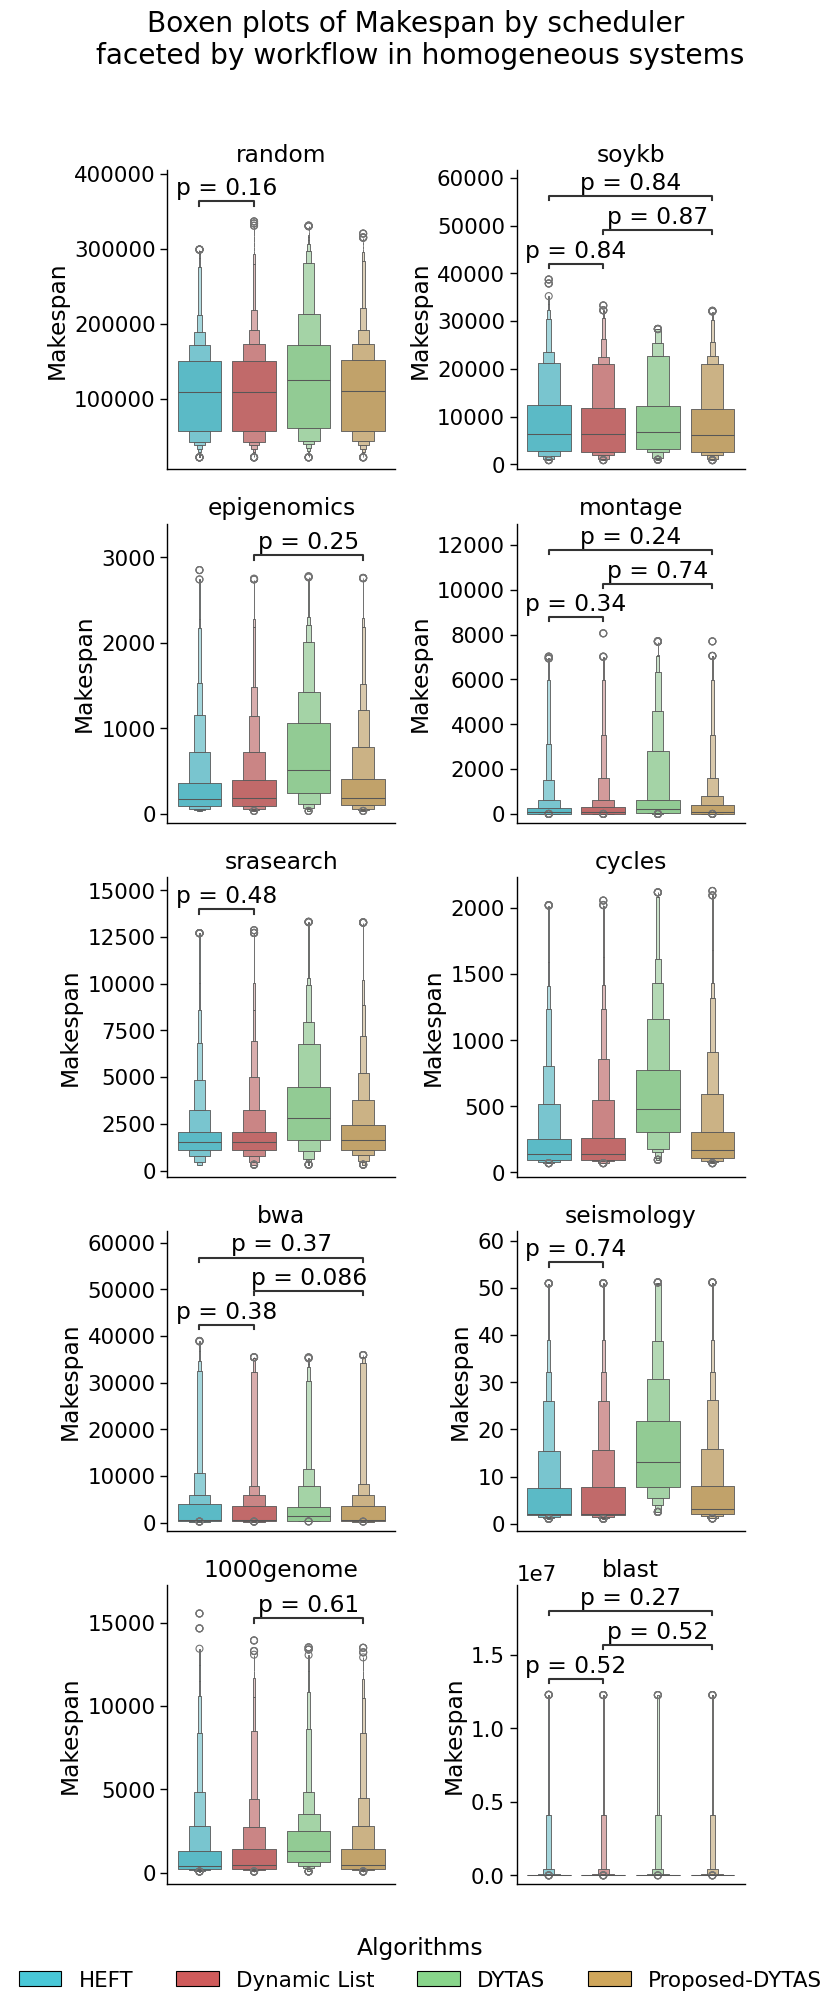

In [53]:
facet_dist_dunn(
    df, "scheduler", 
    "makespan", "workflow",
    palette_map=cmap,
    legend_title="Algorithms",
    catplot_kwargs=dict(col_wrap=2), 
    metrics_names=metrics_names,
    aspect=1,
    height=4,
    system="homogeneous"
)

HEFT vs. Dynamic List: Custom statistical test, P_val:1.537e-01
HEFT vs. Dynamic List: Custom statistical test, P_val:1.331e-01
HEFT vs. Dynamic List: Custom statistical test, P_val:7.028e-01
HEFT vs. Dynamic List: Custom statistical test, P_val:3.358e-01
HEFT vs. Dynamic List: Custom statistical test, P_val:2.554e-01


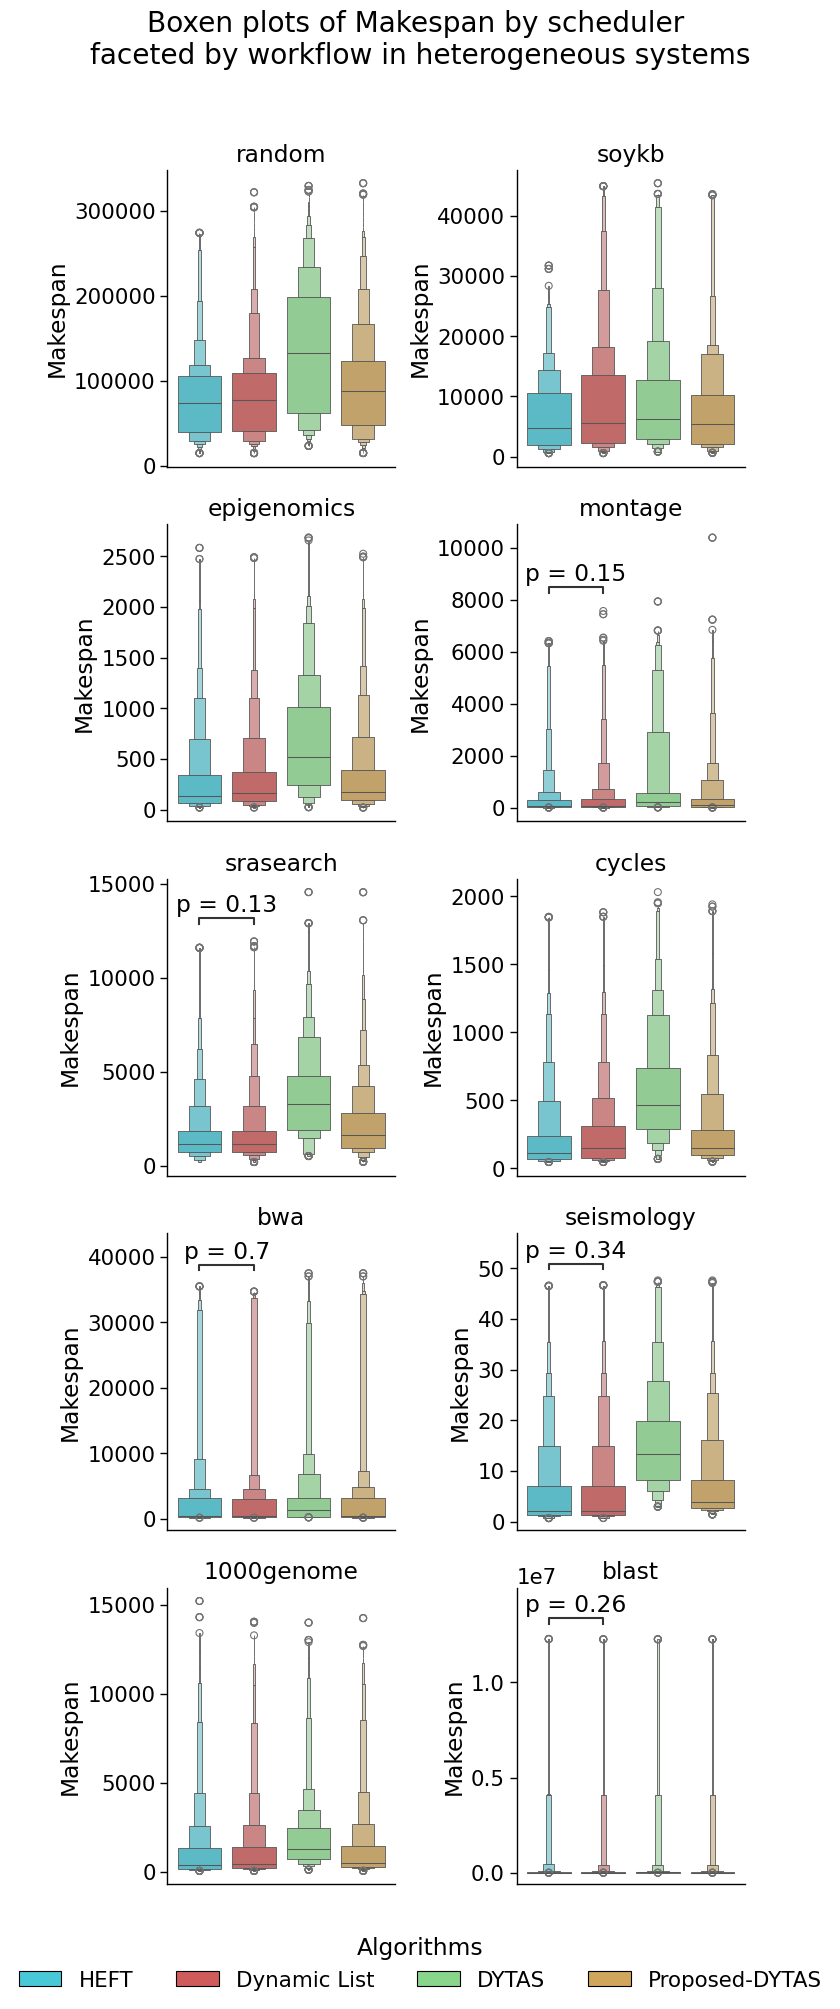

In [54]:
facet_dist_dunn(
    df, "scheduler", 
    "makespan", "workflow",
    palette_map=cmap,
    legend_title="Algorithms",
    catplot_kwargs=dict(col_wrap=2), 
    metrics_names=metrics_names,
    aspect=1,
    height=4,
    system="heterogeneous"
)

HEFT vs. Dynamic List: Custom statistical test, P_val:1.612e-01
Dynamic List vs. Proposed-DYTAS: Custom statistical test, P_val:2.485e-01
HEFT vs. Dynamic List: Custom statistical test, P_val:3.399e-01
Dynamic List vs. Proposed-DYTAS: Custom statistical test, P_val:7.388e-01
HEFT vs. Proposed-DYTAS: Custom statistical test, P_val:2.394e-01
HEFT vs. Dynamic List: Custom statistical test, P_val:7.449e-01


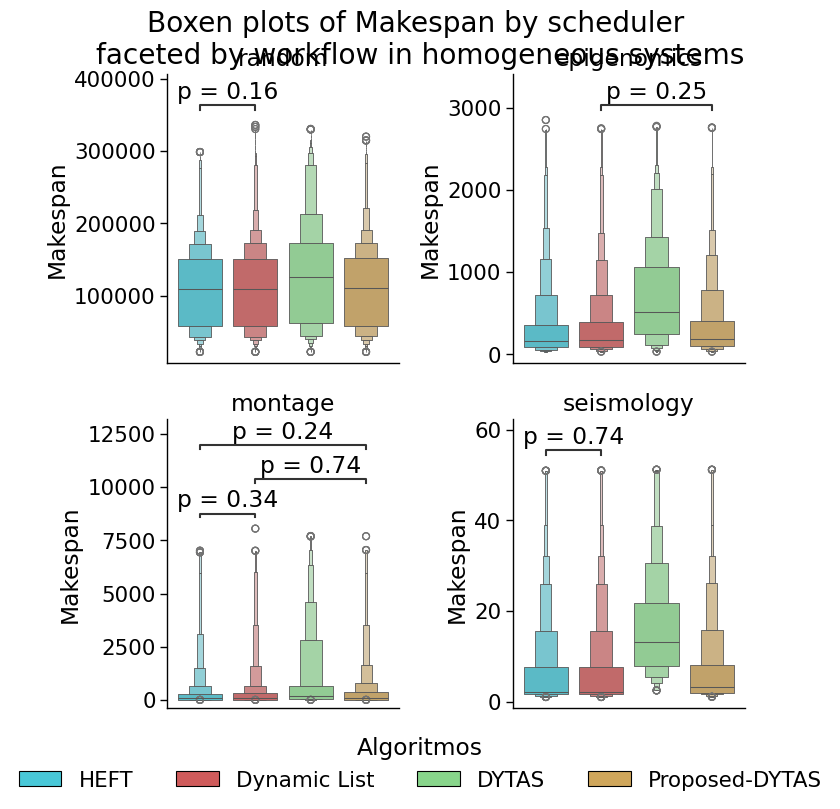

In [55]:
facet_dist_dunn(
    df_presentacion, "scheduler", 
    "makespan", "workflow",
    palette_map=cmap,
    legend_title="Algoritmos",
    catplot_kwargs=dict(col_wrap=2), 
    metrics_names=metrics_names,
    aspect=1,
    height=4,
    system="homogeneous"
)

HEFT vs. Dynamic List: Custom statistical test, P_val:1.537e-01
HEFT vs. Dynamic List: Custom statistical test, P_val:3.358e-01


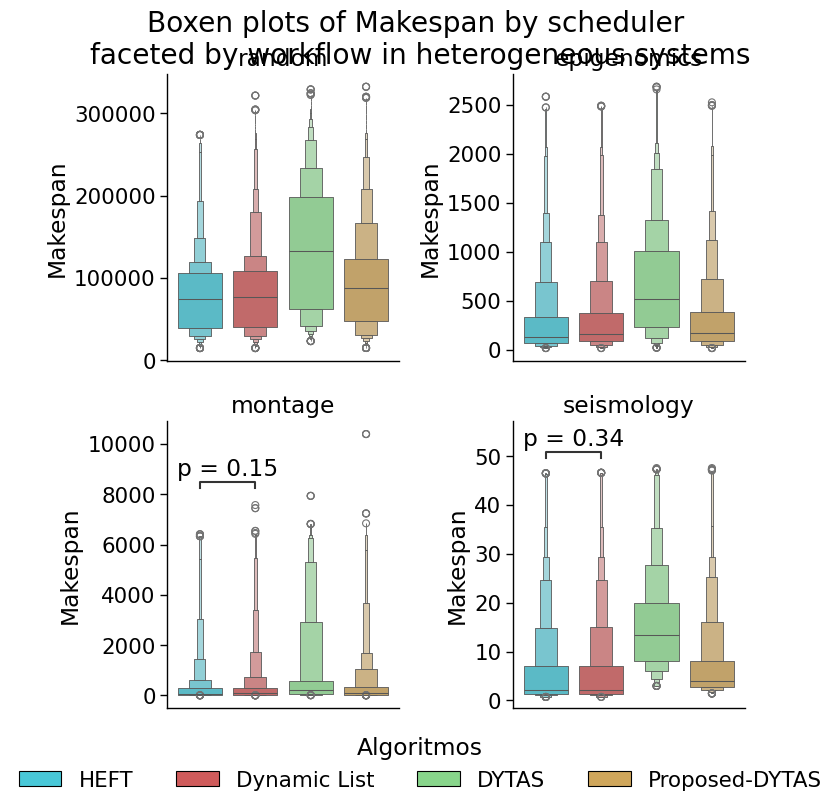

In [56]:
facet_dist_dunn(
    df_presentacion, "scheduler", 
    "makespan", "workflow",
    palette_map=cmap,
    legend_title="Algoritmos",
    catplot_kwargs=dict(col_wrap=2), 
    metrics_names=metrics_names,
    aspect=1,
    height=4,
    system="heterogeneous"
)

In [57]:
# facet_dist_dunn(
#     df, "scheduler", 
#     "makespan", "workflow",
#     palette_map=cmap,
#     legend_title="Algorithms",
#     catplot_kwargs=dict(col_wrap=4), 
#     metrics_names=metrics_names,
#     system="single-core"
# )

### Communication to Computation Ratio

Remember that the smaller the CCR, the more computationally heavy the DAG is wrt to its data, whilst the larger the value the more data havy the DAG is wrt to its computational requirements.

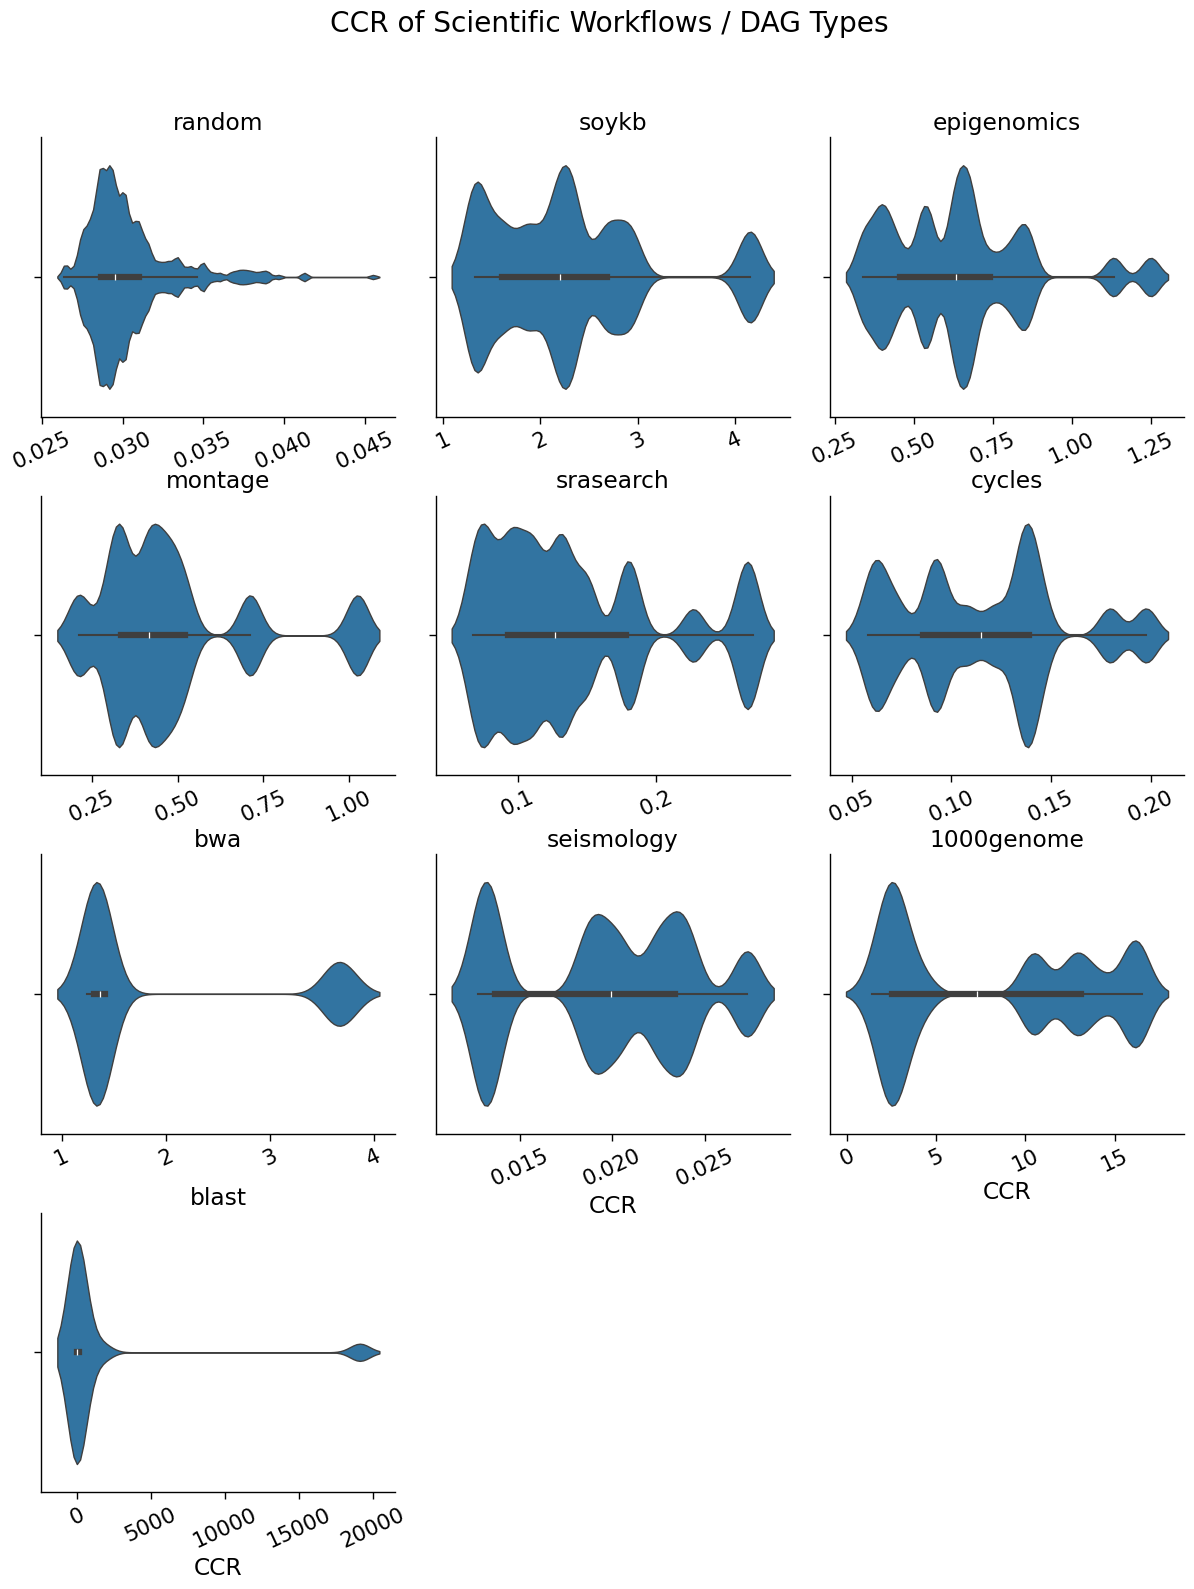

In [58]:

g = sns.FacetGrid(df, col="workflow", col_wrap=3, height=4, sharex=False)
g.map_dataframe(sns.violinplot, x="CCR",  orient='h')

for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(25)  # or 45 for more angle

g.set_axis_labels("CCR", "")
g.set_titles(col_template="{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("CCR of Scientific Workflows / DAG Types")


plt.show()


Given how each workflow has a different distribution of CCR, and these are not purely fixed values, I should bin them per workflow into at least 3 ranges. This should facilitate later analysis.

In [59]:
# node_counts = df[df.workflow == "random"]["dag_nodes"].unique()
# df_grouped = (
#     df[df.dag_nodes.isin(node_counts)].groupby(
#         ["scheduler", "CCR", "dag_nodes"])
#     ["makespan"]
#     .mean()
#     .reset_index()
# )

# # Step 2: Create the lmplot with faceting
# g = sns.lmplot(
#     data=df_grouped,
#     x="CCR",
#     y="makespan",
#     hue="scheduler",
#     col="dag_nodes",
#     col_wrap=2,
#     height=4,
#     aspect=1.3,
#     hue_order=hue_order, palette=cmap,
#     facet_kws={"sharex": False, "sharey": False},
#            scatter_kws={"alpha": 0.5}
# )

# # Step 3: Customize the plot
# g.set_axis_labels("CCR", "Avg. " + metrics_names["makespan"])
# g.set_titles("Node Count: {col_name}")
# g._legend.set_title("Algorithms")
# # Optional: Adjust layout
# plt.subplots_adjust(top=0.9)
# g.fig.suptitle("Average Algorithm " + metrics_names["makespan"] + " vs CCR on random DAGs faceted by Node Counts in all Systems", fontsize=16)

# plt.show()

In [60]:
# node_counts = df[df.workflow == "random"]["dag_nodes"].unique()
# df_grouped = (
#     df[df.dag_nodes.isin(node_counts)].groupby(
#         ["scheduler", "CCR", "dag_nodes"])
#     ["SLR"]
#     .mean()
#     .reset_index()
# )

# # Step 2: Create the lmplot with faceting
# g = sns.lmplot(
#     data=df_grouped,
#     x="CCR",
#     y="SLR",
#     hue="scheduler",
#     col="dag_nodes",
#     col_wrap=2,
#     height=4,
#     aspect=1.3,
#     hue_order=hue_order, palette=cmap,
#     facet_kws={"sharex": False, "sharey": False},
#            scatter_kws={"alpha": 0.5}
# )

# # Step 3: Customize the plot
# g.set_axis_labels("CCR", "Avg. " + metrics_names["SLR"])
# g.set_titles("Node Count: {col_name}")
# g._legend.set_title("Algorithms")
# # Optional: Adjust layout
# plt.subplots_adjust(top=0.9)
# g.fig.suptitle("Average Algorithm " + metrics_names["SLR"] + " vs CCR on random DAGs faceted by Node Counts in all Systems", fontsize=16)

# plt.show()

In [61]:
# node_counts = df[df.workflow == "random"]["dag_nodes"].unique()
# df_grouped = (
#     df[df.dag_nodes.isin(node_counts)].groupby(
#         ["scheduler", "dag_density", "dag_nodes"])
#     ["SLR"]
#     .mean()
#     .reset_index()
# )

# # Step 2: Create the lmplot with faceting
# g = sns.lmplot(
#     data=df_grouped,
#     x="dag_density",
#     y="SLR",
#     hue="scheduler",
#     col="dag_nodes",
#     col_wrap=2,
#     height=4,
#     aspect=1.3,
#     hue_order=hue_order, palette=cmap,
#     facet_kws={"sharex": False, "sharey": False},
#            scatter_kws={"alpha": 0.5}
# )

# # Step 3: Customize the plot
# g.set_axis_labels("dag_density", "Avg. " + metrics_names["SLR"])
# g.set_titles("Node Count: {col_name}")
# g._legend.set_title("Algorithms")
# # Optional: Adjust layout
# plt.subplots_adjust(top=0.9)
# g.fig.suptitle("Average Algorithm " + metrics_names["SLR"] + " vs dag_density on random DAGs faceted by Node Counts in all Systems", fontsize=16)

# plt.show()

In [62]:
# node_counts = df[df.workflow == "random"]["dag_nodes"].unique()
# df_grouped = (
#     df[df.dag_nodes.isin(node_counts)].groupby(
#         ["scheduler", "dag_density", "dag_nodes"])
#     ["makespan"]
#     .mean()
#     .reset_index()
# )

# # Step 2: Create the lmplot with faceting
# g = sns.lmplot(
#     data=df_grouped,
#     x="dag_density",
#     y="makespan",
#     hue="scheduler",
#     col="dag_nodes",
#     col_wrap=2,
#     height=4,
#     aspect=1.3,
#     hue_order=hue_order, palette=cmap,
#     facet_kws={"sharex": False, "sharey": False},
#            scatter_kws={"alpha": 0.5}
# )

# # Step 3: Customize the plot
# g.set_axis_labels("DAG Density", "Avg. " + metrics_names["makespan"])
# g.set_titles("Node Count: {col_name}")
# g._legend.set_title("Algorithms")
# # Optional: Adjust layout
# plt.subplots_adjust(top=0.9)
# g.fig.suptitle("Average Algorithm " + metrics_names["makespan"] + " vs random DAGs Density faceted by Node Counts in all Systems", fontsize=16)

# plt.show()

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from typing import Sequence

def plot_avg_metric_by_workflow(
    df: pd.DataFrame,
    workflow_col: str = "workflow",
    scheduler_col: str = "scheduler",
    node_col: str = "dag_nodes",
    metric: str = "SLR",
    hue_order: Sequence[str] | None = hue_order,
    palette: dict | str = cmap,
    col_wrap: int = 3,
    height: float = 4,
    aspect: float = .9,
    legend_loc: str = "lower center",
    legend_bbox: tuple[float, float] = (0.5, -0.02),
    legend_title: str = "Algorithm",
    legend_ncol: int = 4,
    x_label: str = "No. DAG Nodes",
    suptitle: str = None,
    title_fontsize: float = None,
    label_fontsize: float = None,
    tick_labelsize: float = None,
    rotation: float = 30,
    system: str = "all"
) -> sns.FacetGrid:
    """
    Plot average metric per algorithm across workflow types as a faceted line plot.

    Parameters
    ----------
    df             : Input DataFrame containing the relevant columns.
    workflow_col   : Column name for workflow categories (faceting).
    scheduler_col  : Column name for scheduler (hue).
    node_col       : Column name for number of DAG nodes (x-axis).
    metric        : Column name for the Schedule Length Ratio values (y-axis).
    hue_order      : Explicit order for the scheduler legend entries.
    palette        : Color mapping or name for the hue variable.
    col_wrap       : Number of columns in the facet grid.
    height         : Height (in inches) of each facet.
    aspect         : Aspect ratio of each facet.
    legend_loc     : Anchor position for the legend.
    legend_bbox    : (x, y) offset for the legend bounding box.
    legend_title   : Title for the legend.
    x_label        : Label for the x-axis.
    suptitle       : Figure-level title (defaults to generated text).
    title_fontsize : Font size for the figure title.
    label_fontsize : Font size for the axis labels.
    tick_labelsize : Font size for the tick labels.
    rotation       : Rotation (in degrees) for x-axis tick labels.

    Returns
    -------
    g : seaborn.FacetGrid
        The FacetGrid object for further customization or inspection.
    """

    df = filter_by_system(df, system)
    
    # 1. Aggregate
    grouped = (
        df
        .groupby([workflow_col, scheduler_col, node_col])[metric]
        .mean()
        .reset_index()
    )

    # 2. Draw the relplot
    g = sns.relplot(
        data=grouped,
        x=node_col, y=metric, hue=scheduler_col,
        kind="line", marker="o",
        style="scheduler",
        dashes=True,
        col=workflow_col, col_wrap=col_wrap,
        height=height, aspect=aspect,
        hue_order=hue_order, 
        palette=palette,
        facet_kws={'sharex': False, 'sharey': False},
        linewidth=2.0,
    )  # Figure‐level interface :contentReference[oaicite:0]{index=0}

    # 3. Legend outside
    sns.move_legend(
        g, legend_loc,
        bbox_to_anchor=legend_bbox,
        frameon=False,
        title=legend_title,
        ncol=legend_ncol
    )  # Repositions legend :contentReference[oaicite:1]{index=1}

    
    g.fig.subplots_adjust(right=0.85)  # Make room :contentReference[oaicite:2]{index=2}

    # 4. Labels & titles
    g.set_axis_labels(x_label, "Avg. " + metrics_names[metric], fontsize=label_fontsize)  # Axis labels :contentReference[oaicite:3]{index=3}
    g.set_titles("{col_name}", fontsize=label_fontsize)          # Facet titles :contentReference[oaicite:4]{index=4}

    # 5. Tick label rotation
    for ax in g.axes.flatten():
        ax.tick_params(axis='x', labelrotation=rotation, labelsize=tick_labelsize)  # Tick params :contentReference[oaicite:5]{index=5}
        ax.tick_params(axis='y', labelsize=tick_labelsize)

    # 6. Super‐title
    if suptitle is None:
        suptitle = (
            f"Avg. {metrics_names[metric]} per Algorithm Across Workflow Types\n"
            f"with Increasing DAG Nodes in " + system + " Systems"
        )
    g.fig.suptitle(suptitle, fontsize=title_fontsize)  # Figure title :contentReference[oaicite:6]{index=6}

    # 7. Tight layout
    plt.tight_layout()            # Auto‐adjust padding :contentReference[oaicite:7]{index=7}
    plt.subplots_adjust(top=0.93) # Make room for suptitle :contentReference[oaicite:8]{index=8}

    return g


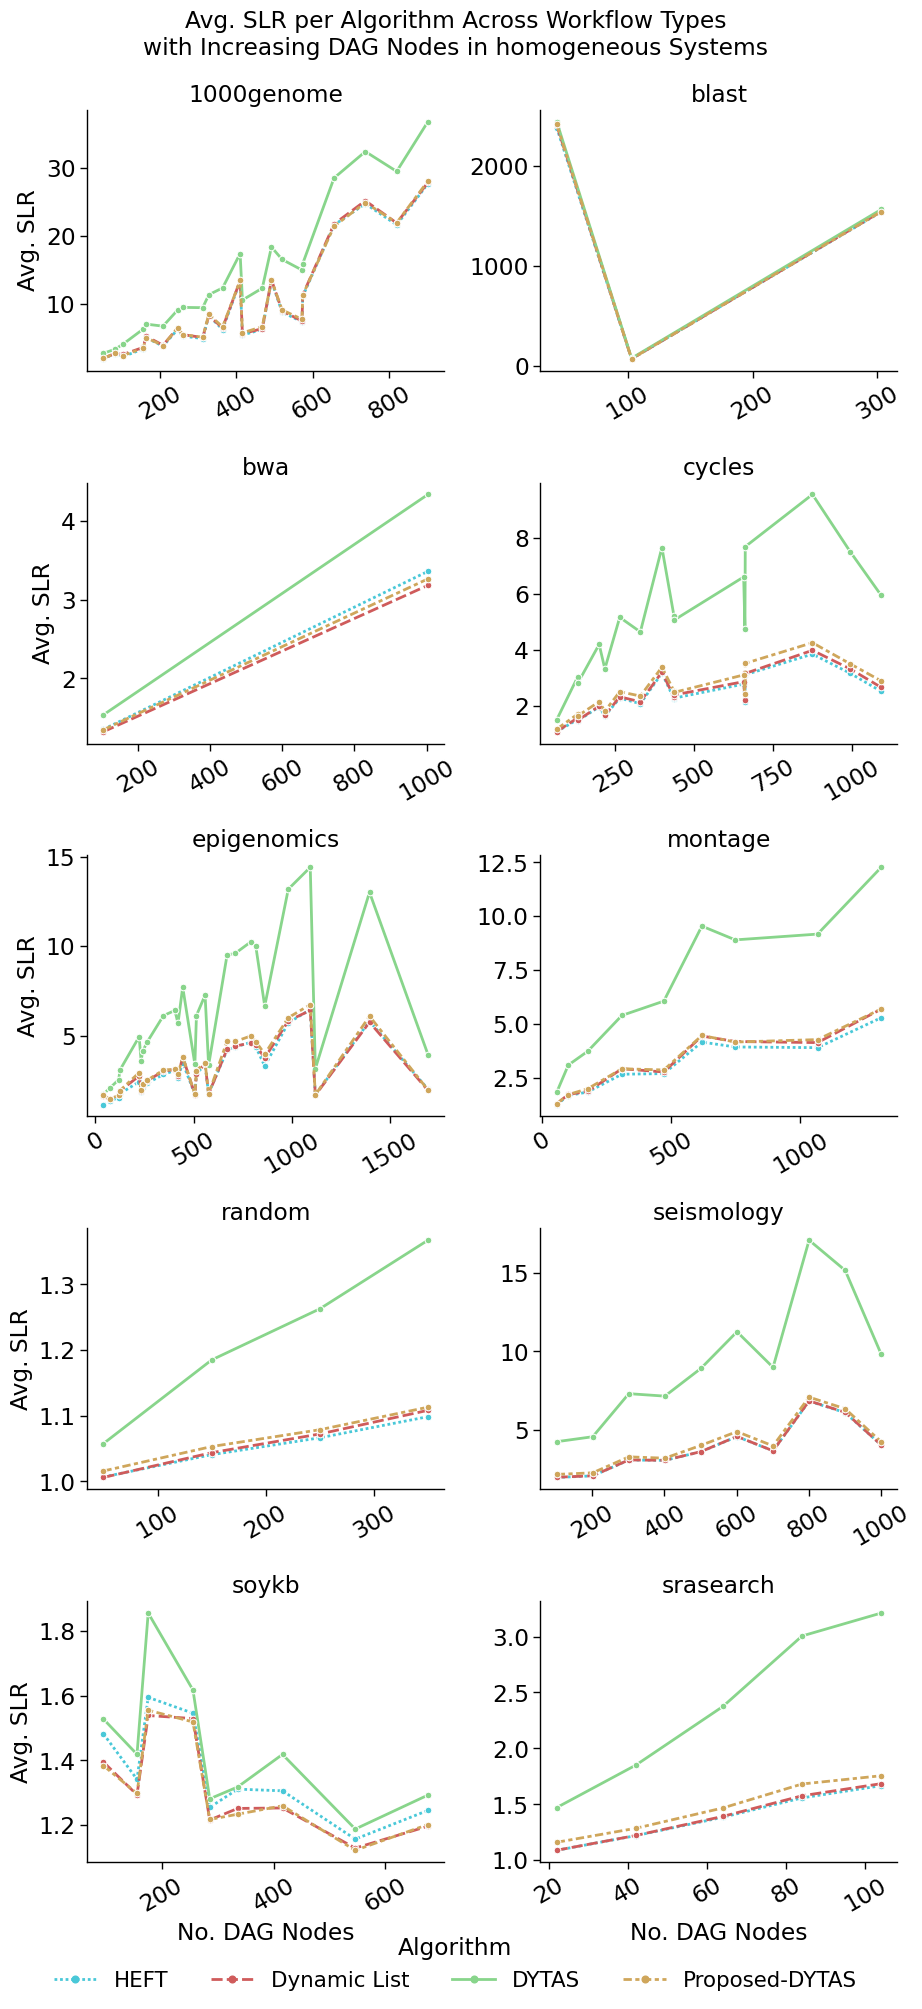

In [64]:
plot_avg_metric_by_workflow(df, metric="SLR", system="homogeneous", col_wrap=2)

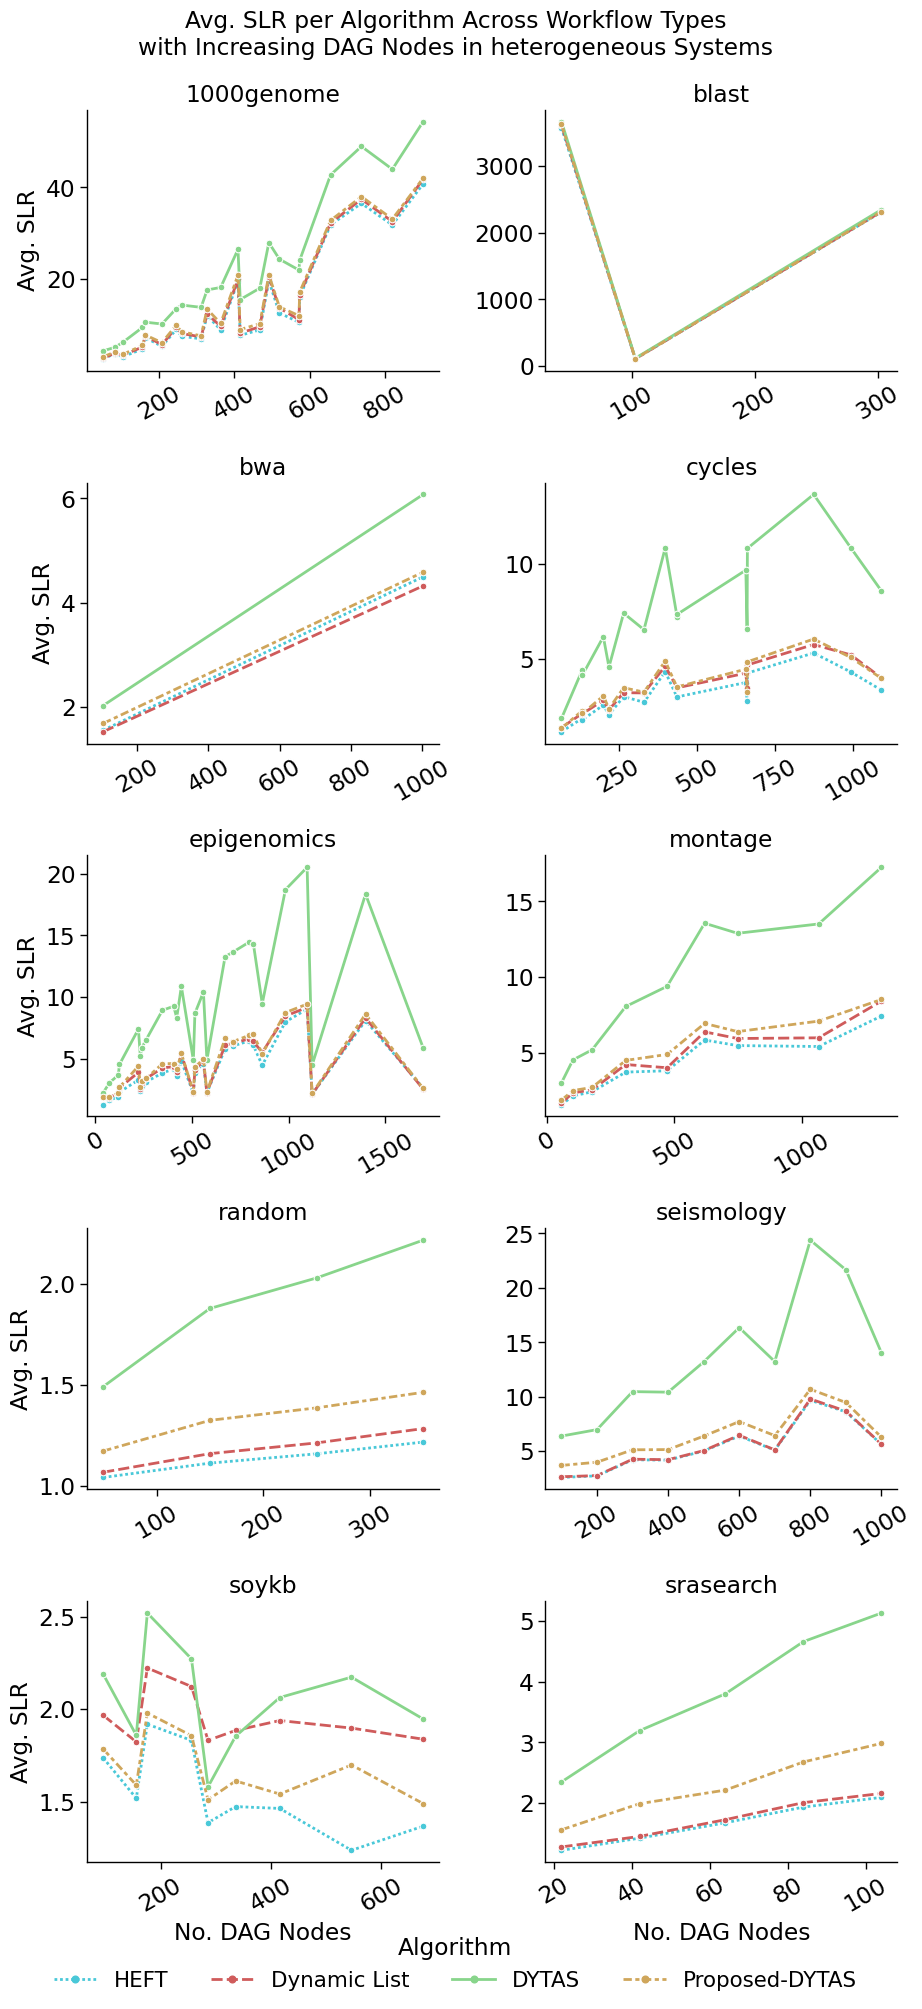

In [65]:
plot_avg_metric_by_workflow(df, metric="SLR", system="heterogeneous", col_wrap=2)

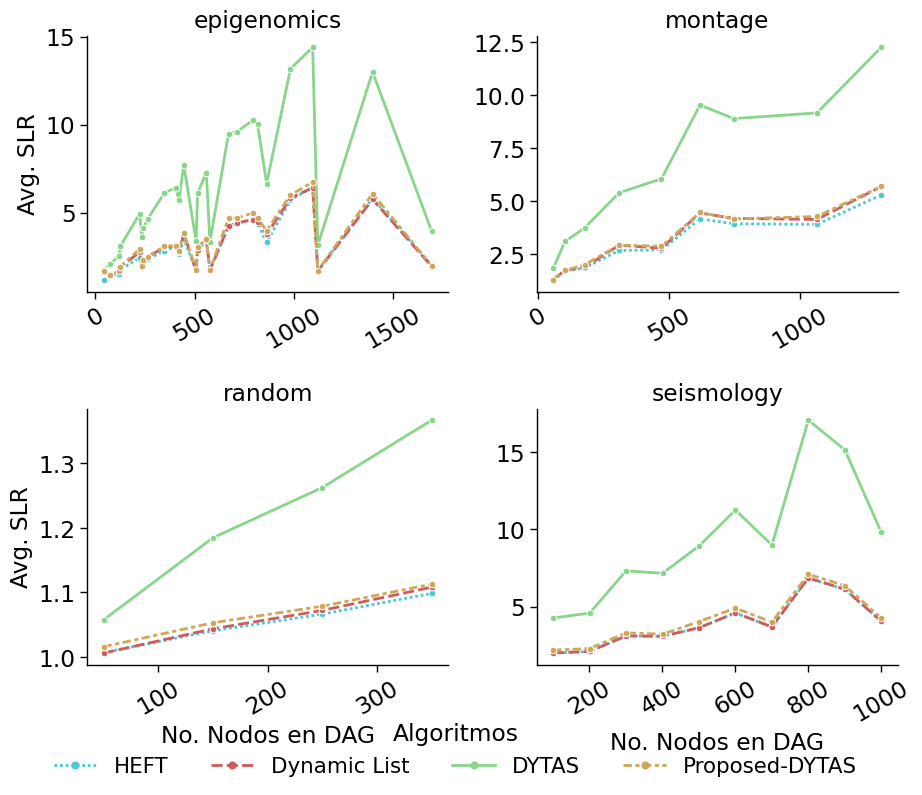

In [66]:
plot_avg_metric_by_workflow(df_presentacion, metric="SLR", system="homogeneous", col_wrap=2, suptitle="", x_label="No. Nodos en DAG", legend_title="Algoritmos")

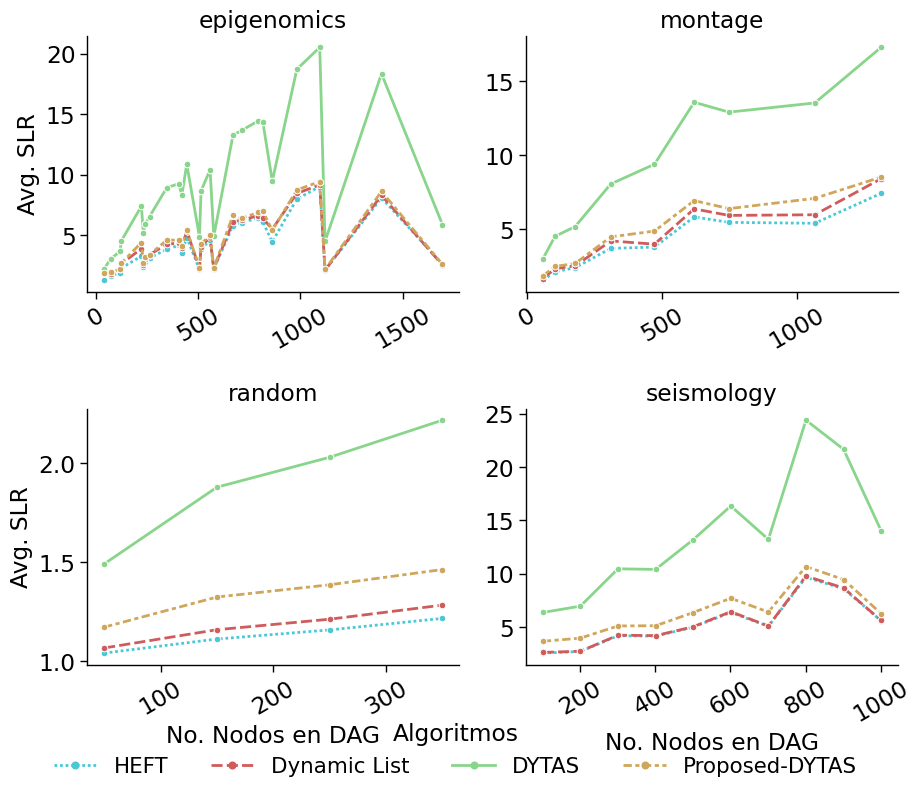

In [67]:
plot_avg_metric_by_workflow(df_presentacion, metric="SLR", system="heterogeneous", col_wrap=2,suptitle="", x_label="No. Nodos en DAG", legend_title="Algoritmos")

In [68]:
# # Prepare the data by grouping and calculating the mean makespan
# grouped_df = df.groupby(["workflow", "scheduler", "dag_nodes"])["makespan"].mean().reset_index()

# g = sns.relplot(
#     data=grouped_df,
#     x="dag_nodes",
#     y="makespan",
#     hue="scheduler",
#     kind="line",
#     marker="o",
#     col="workflow",
#     col_wrap=3,
#     height=4,
#     aspect=1.3,
#     hue_order=hue_order, palette=cmap, 
#     facet_kws={'sharex': False, 'sharey': False}
# )

# # Move the legend outside the plot area
# sns.move_legend(
#     g,
#     "lower right",
#     bbox_to_anchor=(.75, 0.1),
#     frameon=True,
#     title="Algorithm"
# )

# # Adjust layout to accommodate the legend
# g.figure.subplots_adjust(right=0.85)

# # Set axis labels and titles
# g.set_axis_labels("No. DAG Nodes", "Avg. makespan")
# g.set_titles("{col_name}")

# # Rotate x-axis tick labels for better readability
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(30)
#         label.set_horizontalalignment("right")

# # Add a main title to the figure
# g.figure.suptitle("Avg. makespan per Algorithm Across Workflow Types with Increasing Node Count on All Systems", fontsize=16)
# plt.tight_layout()
# plt.subplots_adjust(top=0.92)

# plt.show()



In [69]:
# # Prepare the data by grouping and calculating the mean SLR
# grouped_df = df.groupby(["workflow", "scheduler", "dag_nodes"])["SLR"].mean().reset_index()

# g = sns.relplot(
#     data=grouped_df,
#     x="dag_nodes",
#     y="SLR",
#     hue="scheduler",
#     kind="line",
#     marker="o",
#     col="workflow",
#     col_wrap=3,
#     height=4,
#     aspect=1.3,
#     hue_order=hue_order, palette=cmap, 
#     facet_kws={'sharex': False, 'sharey': False}
# )

# # Move the legend outside the plot area
# sns.move_legend(
#     g,
#     "lower right",
#     bbox_to_anchor=(.75, 0.1),
#     frameon=True,
#     title="Algorithm"
# )

# # Adjust layout to accommodate the legend
# g.figure.subplots_adjust(right=0.85)

# # Set axis labels and titles
# g.set_axis_labels("No. DAG Nodes", "Avg. SLR")
# g.set_titles("{col_name}")

# # Rotate x-axis tick labels for better readability
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(30)
#         label.set_horizontalalignment("right")

# # Add a main title to the figure
# g.figure.suptitle("Avg. SLR per Algorithm Across Workflow Types with Increasing Node Count on All Systems", fontsize=16)
# plt.tight_layout()
# plt.subplots_adjust(top=0.92)

# plt.show()



In [70]:
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# # sns.set_theme(style="dark")

# # # Simulate data from a bivariate Gaussian
# # n = 10000
# # mean = [0, 0]
# # cov = [(2, .4), (.4, .2)]
# # rng = np.random.RandomState(0)
# # x, y = rng.multivariate_normal(mean, cov, n).T

# # # Draw a combo histogram and scatterplot with density contours
# # f, ax = plt.subplots(figsize=(6, 6))
# # sns.scatterplot(x=x, y=y, s=5, color=".15")
# node_counts = df[df.workflow == "random"]["dag_nodes"].unique()
# tmp_df = df[(df.workflow == "random")&(df.dag_nodes.isin(node_counts))]
# # sns.histplot(x=tmp_df.CCR, y=tmp_df.makespan, bins=50, pthresh=.1, cmap="mako")
# sns.kdeplot(tmp_df,x="CCR", y="makespan", hue="dag_nodes", levels=5, linewidths=1, fill=True)

In [71]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# fig, ax = plt.subplots(figsize=(6,4))

# # Density background
# tmp_df = tmp_df[tmp_df.dag_nodes==50]
# hb = ax.hexbin(tmp_df["CCR"], tmp_df["makespan"],
#                gridsize=50, cmap="Blues", mincnt=1)

# # Optional: add colorbar
# fig.colorbar(hb, ax=ax, label="Counts")

# # Regression trend
# sns.regplot(data=tmp_df, x="CCR", y="makespan",
#             scatter=False, ax=ax, color="red")

# ax.set_xlabel("CCR")
# ax.set_ylabel("Makespan")


In [72]:
# import seaborn as sns, matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(7,5))
# palette = sns.color_palette("Set2", tmp_df["scheduler"].nunique())

# for color, sched in zip(palette, tmp_df["scheduler"].unique()):
#     df_sub = tmp_df[tmp_df["scheduler"] == sched]

#     # Filled bivariate KDE
#     sns.kdeplot(data=df_sub, x="CCR", y="makespan",
#                 fill=True, thresh=0, levels=10,
#                 alpha=1, cmap=sns.light_palette(color, as_cmap=True),
#                 ax=ax)                                   # 2‑d KDE :contentReference[oaicite:4]{index=4}

#     # Regression line (no points)
#     sns.regplot(data=df_sub, x="CCR", y="makespan",
#                 scatter=False, ci=95, color=color,
#                 line_kws=dict(linewidth=2), ax=ax)       # per‑hue reg :contentReference[oaicite:5]{index=5}

# ax.set_title("CCR vs Makespan – density & trend per scheduler")
# ax.legend(tmp_df["scheduler"].unique())
# plt.show()


In [73]:
df.CCR.min()

0.0005282076877720934

In [74]:
# n_bins = 3
def bin_group_ccr(group, n_bins=3):
    bins = np.linspace(group.CCR.min(), group.CCR.max(), n_bins + 1)
    group["CCR_bin"] = pd.cut(
        group.CCR, 
        bins=bins, 
        include_lowest=True, 
        ordered=True,
        precision=2
    )
    return group
    
df_ccr_binned = df.groupby("workflow")[df.columns].apply(
    bin_group_ccr
).reset_index(drop=True)

df_ccr_makespan = (
    df_ccr_binned.groupby(["workflow", "scheduler", "CCR_bin"])["makespan"]
    .mean()
    .reset_index()
)

def cleanup_intervals(df):
    # Cleaning up intervals with negatives
    tmp_df = pd.DataFrame()
    tmp_df['left'] = df['CCR_bin'].apply(lambda x: max(x.left,0))
    tmp_df['right'] = df['CCR_bin'].apply(lambda x: max(x.right, 0))
    
    return tmp_df.apply(
        lambda row:
            pd.Interval(
            left=round(row.left, 2),
            right=round(row.right,2),
            closed='right'
        ), axis=1
    )


df_ccr_makespan["CCR_bin"] = cleanup_intervals(df_ccr_makespan)

In [75]:
df_ccr_makespan.CCR_bin.unique()

<IntervalArray>
[        (1.39, 6.45],        (6.45, 11.49],       (11.49, 16.53],
       (0.0, 6379.02], (12758.04, 19137.05],         (1.23, 2.08],
         (2.93, 3.77],          (0.05, 0.1],          (0.1, 0.15],
          (0.15, 0.2],         (0.33, 0.64],         (0.64, 0.95],
         (0.95, 1.25],          (0.2, 0.48],         (0.48, 0.75],
         (0.75, 1.02],         (0.02, 0.03],         (0.03, 0.04],
         (0.04, 0.05],          (0.0, 0.02],         (0.02, 0.02],
         (1.32, 2.27],         (2.27, 3.21],         (3.21, 4.15],
         (0.06, 0.13],          (0.13, 0.2],          (0.2, 0.27]]
Length: 27, dtype: interval[float64, right]

In [76]:
df.CCR.dtype

dtype('float64')

In [77]:
# def plot_makespan_by_bins(grouped_data, 
#                           x_col="makespan", 
#                           y_col="CCR_bin", 
#                           hue_col="scheduler", 
#                           col_col="workflow", 
#                           hue_order=None, 
#                           palette=None,
#                           title="Makespan by Scheduler Across CCR Bins (Workflow-specific Bins)"):

#     g = sns.catplot(
#         data=grouped_data,
#         y=y_col, x=x_col,
#         hue=hue_col,
#         col=col_col,
#         kind="bar",
#         col_wrap=2,
#         height=3.5,
#         aspect=1.5,
#         sharex=False,
#         sharey=False,
#         hue_order=hue_order,
#         palette=palette,
#     )

#     g.set_titles("{col_name}")
#     g.set_axis_labels("Avg. Makespan", "CCR Intervals")

#     # Move legend below
#     sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, -0.05), ncol=4)

#     # Adjust axes, add annotations
#     for ax in g.axes.flatten():
#         bars = [bar.get_width() for bar in ax.patches]
#         if not bars:
#             continue
#         min_val, max_val = min(bars), max(bars)
#         margin = (max_val - min_val) * 0.2
#         ax.set_xlim(min_val - margin, max_val + margin)

#         # # Add text annotations at the end of bars
#         # for bar in ax.patches:
#         #     width = bar.get_width()
#         #     ax.text(
#         #         width + 0.01 * width,
#         #         bar.get_y() + bar.get_height() / 2,
#         #         f"{width:.1f}",
#         #         ha='left', va='center', fontsize=9
#         #     )
        
#         ax.invert_yaxis()

#     g.figure.suptitle(title, fontsize=20)
#     g.figure.tight_layout()
#     g.figure.subplots_adjust(top=0.92, bottom=0.10)

#     return g


# g = plot_makespan_by_bins(
#     grouped_data=df_ccr_makespan,
#     hue_order=hue_order,
#     palette=cmap
# )

# plt.show()


The above charts show how in most of the cases (except for seismology and blast) the lower the CCR (meaning the DAGs were more computationally heavy) the average makespan was longer than when the CCR was higher. In seismology we see the opposite of that, which I don't have at the moment a good reason as to why.

Nonetheless, the most important thing is to note how DYTAS in all of the cases showed very long avg. makespans, and it is more particularly noticeable in low CCR DAGs (tho we see the opposite in seismology).

In [78]:
# g = plot_makespan_by_bins(
#     grouped_data=df_ccr_binned[df_ccr_binned.system_type=="homogeneous"].groupby(["workflow", "scheduler", "CCR_bin"])["makespan"]
#     .mean()
#     .reset_index(),
#     hue_order=hue_order,
#     palette=cmap
# )

# plt.show()

In [79]:
# n_bins = 4  # Number of CCR bins per DAG size

# # STEP 1: Filter for "random" workflows only
# df_random = df[df["workflow"] == "random"].copy()

# # STEP 2: Bin CCR within each DAG size group (i.e. dag_nodes)
# def bin_ccr_within_size(group):
#     group = group.copy()
#     group["CCR_bin"] = pd.cut(group["CCR"], bins=n_bins)
#     return group

# df_random_binned = df_random.groupby("dag_nodes", group_keys=False).apply(bin_ccr_within_size)

# # Optional: Convert intervals to string labels for cleaner x-axis
# df_random_binned["CCR_bin"] = df_random_binned["CCR_bin"].astype(str)

# # STEP 3: Group by DAG size, CCR bin, and scheduler to get avg makespan
# grouped = (
#     df_random_binned.groupby(["dag_nodes", "scheduler", "CCR_bin"])["makespan"]
#     .mean()
#     .reset_index()
# )

# # STEP 4: Plot each DAG size as a separate chart
# g = sns.catplot(
#     data=grouped,
#     x="CCR_bin", y="makespan",
#     hue="scheduler",
#     col="dag_nodes",
#     kind="bar",
#     col_wrap=2,        # Adjust for layout
#     height=4, 
#     aspect=1.2,
#     sharex=False,
#     sharey=False,
#     hue_order=hue_order, palette=cmap,
# )

# # STEP 5: Final cleanup
# g.set_titles("DAG Size: {col_name}")
# g.set_axis_labels("CCR Range", "Avg. Makespan")
# g.add_legend(title="Scheduler")

# # Rotate x-axis tick labels for clarity
# for ax in g.axes.flatten():
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
#     y_max = ax.get_ylim()[1]
#     y_min = ax.get_ylim()[0]
#     zoom_start = y_min + (y_max - y_min) * 0.5
#     ax.set_ylim(zoom_start, y_max)

# g.figure.suptitle("Average Makespan by Scheduler Across CCR Bins for Random Workflows (by DAG Size)", fontsize=16)
# g.figure.tight_layout()
# g.figure.subplots_adjust(top=0.9)

# plt.show()


## Algorithm Speedup

### All Systems

In [80]:
# # Prepare the data by grouping and calculating the mean speedup
# grouped_df = df.groupby(["workflow", "scheduler", "dag_nodes"])["speedup"].mean().reset_index()

# g = sns.relplot(
#     data=grouped_df,
#     x="dag_nodes",
#     y="speedup",
#     hue="scheduler",
#     kind="line",
#     marker="o",
#     col="workflow",
#     col_wrap=3,
#     height=4,
#     aspect=1.3,
#     hue_order=hue_order, palette=cmap, 
#     facet_kws={'sharex': False, 'sharey': False}
# )

# # Move the legend outside the plot area
# sns.move_legend(
#     g,
#     "lower right",
#     bbox_to_anchor=(.75, 0.1),
#     frameon=True,
#     title="Algorithm"
# )

# # Adjust layout to accommodate the legend
# g.figure.subplots_adjust(right=0.85)

# # Set axis labels and titles
# g.set_axis_labels("No. DAG Nodes", "Avg. Speedup")
# g.set_titles("{col_name}")

# # Rotate x-axis tick labels for better readability
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(30)
#         label.set_horizontalalignment("right")

# # Add a main title to the figure
# g.figure.suptitle("Avg. Speedup per Algorithm Across Workflow Types with Increasing Node Count on All Systems", fontsize=16)
# plt.tight_layout()
# plt.subplots_adjust(top=0.92)

# plt.show()



### Homogeneous systems

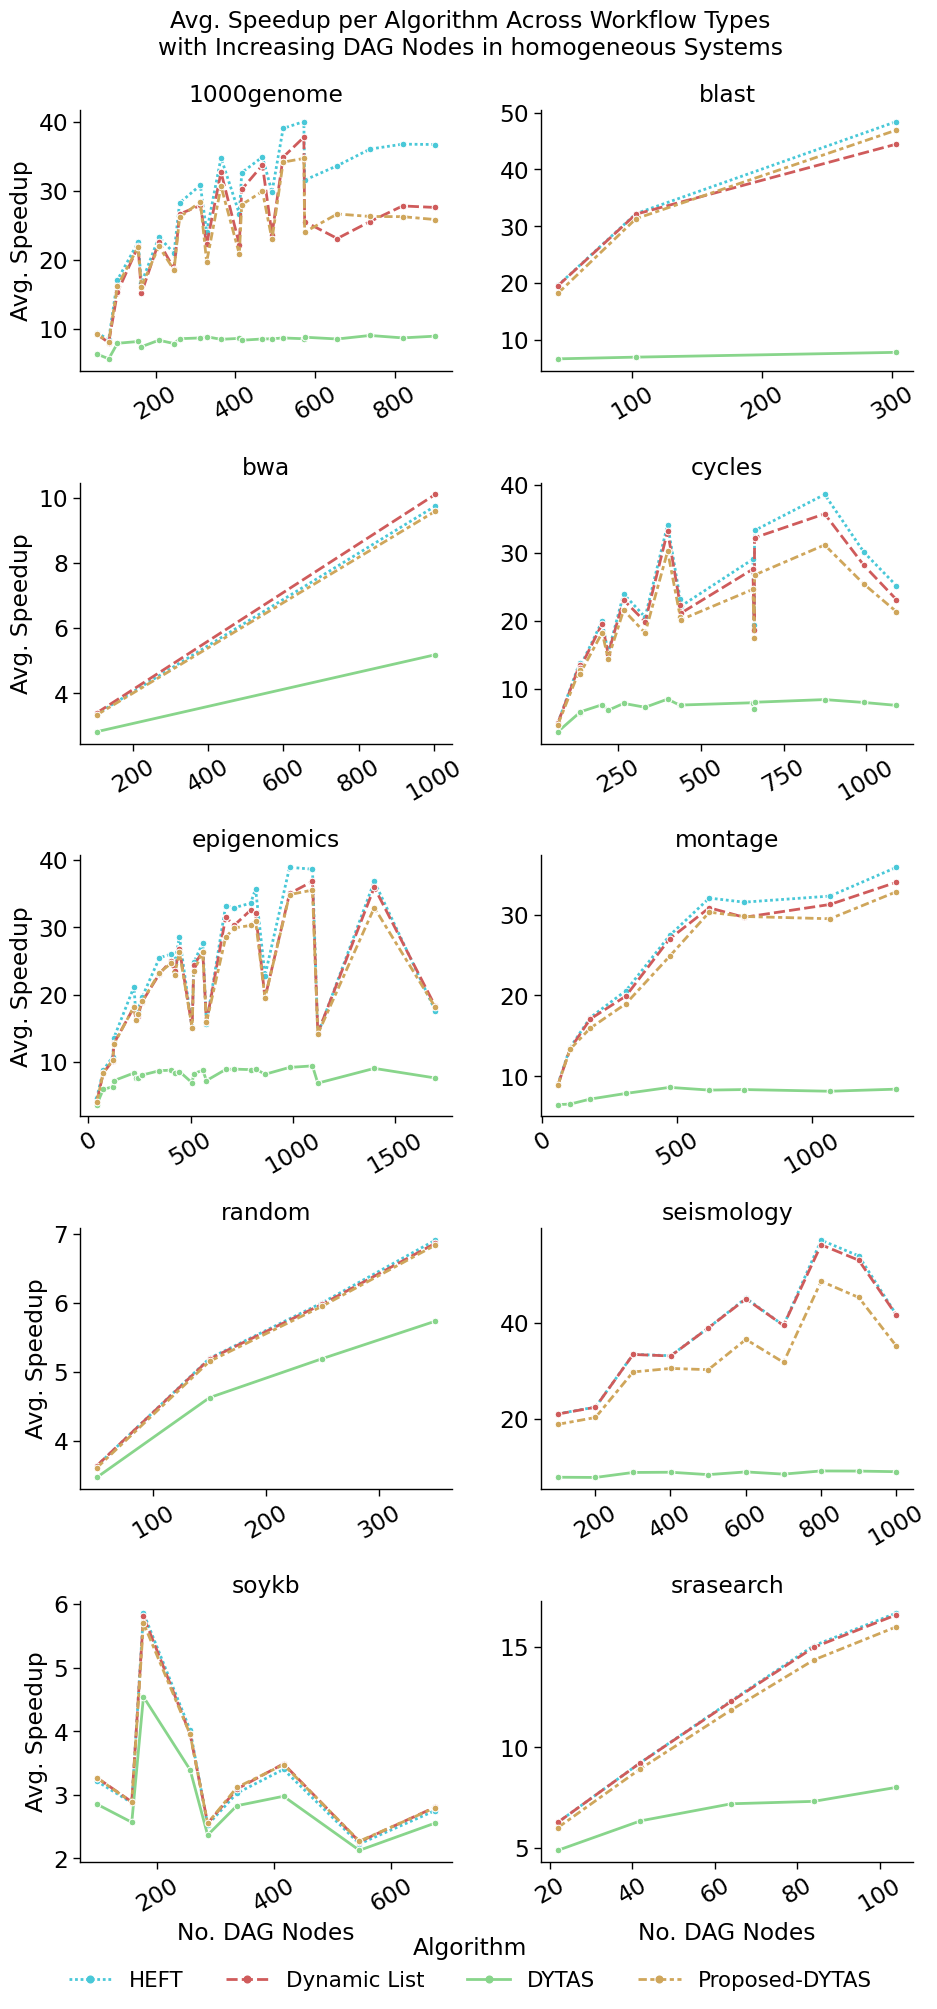

In [81]:
plot_avg_metric_by_workflow(df, metric="speedup", system="homogeneous", col_wrap=2)

In [82]:
# grouped_df = df[df.system_type == "homogeneous"].groupby(["workflow", "scheduler", "dag_nodes"])["speedup"].mean().reset_index()

# g = sns.relplot(
#     data=grouped_df,
#     x="dag_nodes",
#     y="speedup",
#     hue="scheduler",
#     kind="line",
#     marker="o",
#     col="workflow",
#     col_wrap=3,
#     height=4,
#     aspect=1.3,
#     hue_order=hue_order, palette=cmap, 
#     facet_kws={'sharex': False, 'sharey': False}
# )

# # Move the legend outside the plot area
# sns.move_legend(
#     g,
#     "lower right",
#     bbox_to_anchor=(.75, 0.1),
#     frameon=True,
#     title="Algorithm"
# )

# # Adjust layout to accommodate the legend
# g.figure.subplots_adjust(right=0.85)

# # Set axis labels and titles
# g.set_axis_labels("No. DAG Nodes", "Avg. Speedup")
# g.set_titles("{col_name}")

# # Rotate x-axis tick labels for better readability
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(30)
#         label.set_horizontalalignment("right")

# # Add a main title to the figure
# g.figure.suptitle("Avg. Speedup per Algorithm Across Workflow Types with Increasing Node Count on Homogeneous Systems", fontsize=16)
# plt.tight_layout()
# plt.subplots_adjust(top=0.92)

# plt.show()



### Heterogeneous Systems

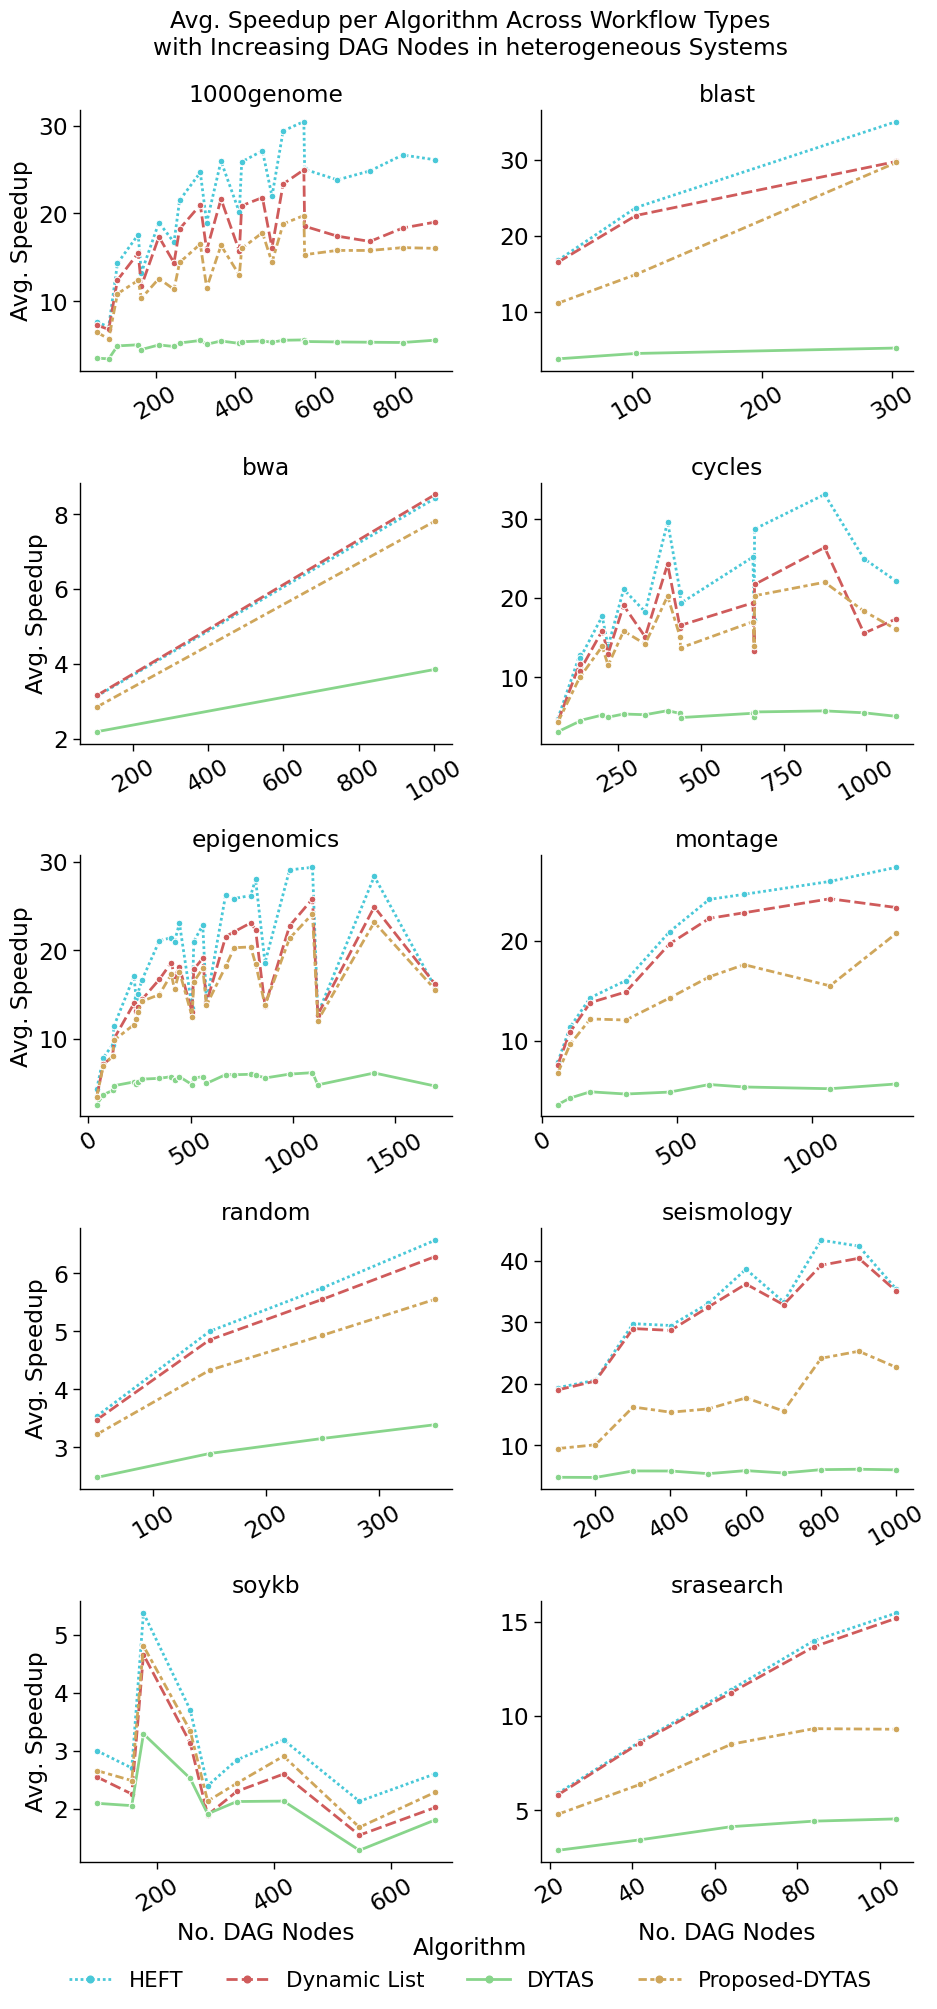

In [83]:
plot_avg_metric_by_workflow(df, metric="speedup", system="heterogeneous", col_wrap=2)

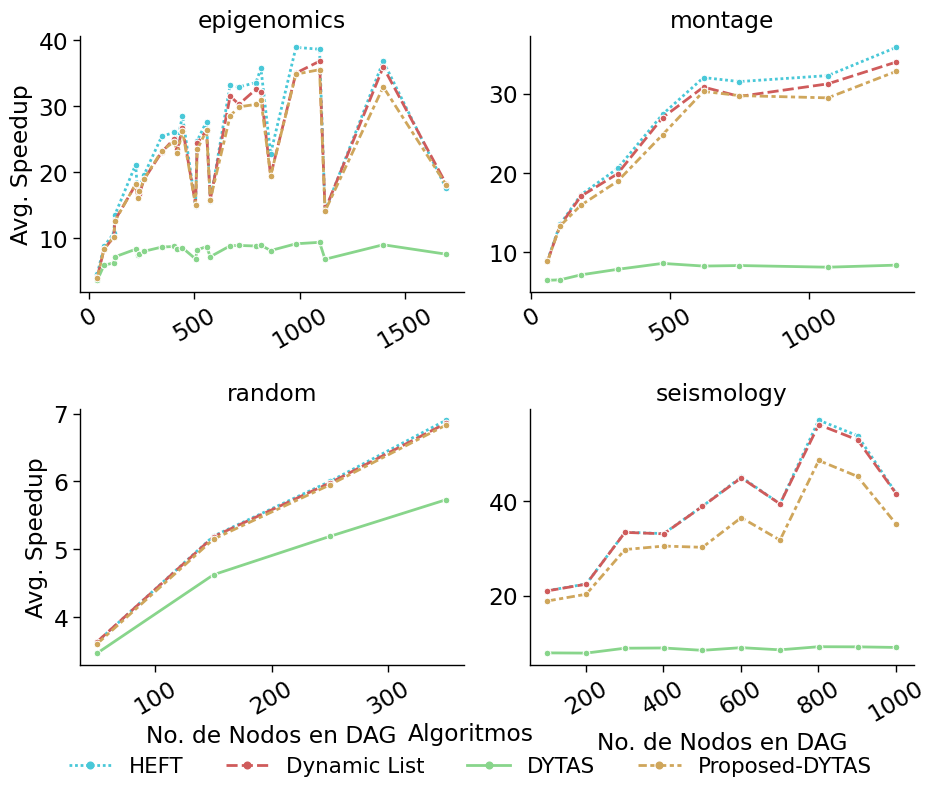

In [84]:
plot_avg_metric_by_workflow(
    df_presentacion, metric="speedup", system="homogeneous", col_wrap=2, suptitle="", x_label="No. de Nodos en DAG", legend_title="Algoritmos")

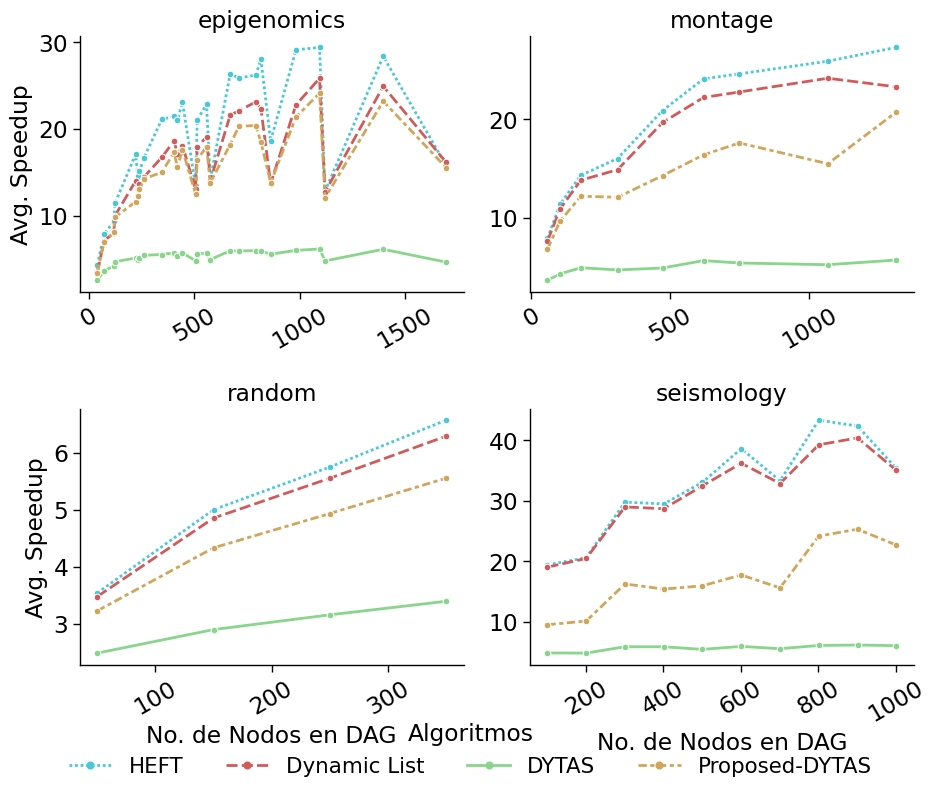

In [85]:
plot_avg_metric_by_workflow(
    df_presentacion, metric="speedup", system="heterogeneous", col_wrap=2, suptitle="", x_label="No. de Nodos en DAG", legend_title="Algoritmos")

In [86]:
# # Prepare the data by grouping and calculating the mean speedup
# grouped_df = df[df.system_type=="heterogeneous"].groupby(["workflow", "scheduler", "dag_nodes"])["speedup"].mean().reset_index()

# g = sns.relplot(
#     data=grouped_df,
#     x="dag_nodes",
#     y="speedup",
#     hue="scheduler",
#     kind="line",
#     marker="o",
#     col="workflow",
#     col_wrap=3,
#     height=4,
#     aspect=1.3,
#     hue_order=hue_order, palette=cmap, 
#     facet_kws={'sharex': False, 'sharey': False}
# )

# # Move the legend outside the plot area
# sns.move_legend(
#     g,
#     "lower right",
#     bbox_to_anchor=(.75, 0.1),
#     frameon=True,
#     title="Algorithm"
# )

# # Adjust layout to accommodate the legend
# g.figure.subplots_adjust(right=0.85)

# # Set axis labels and titles
# g.set_axis_labels("No. DAG Nodes", "Avg. Speedup")
# g.set_titles("{col_name}")

# # Rotate x-axis tick labels for better readability
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(30)
#         label.set_horizontalalignment("right")

# # Add a main title to the figure
# g.figure.suptitle("Avg. Speedup per Algorithm Across Workflow Types with Increasing Node Count on Heterogeneous Systems", fontsize=16)
# plt.tight_layout()
# plt.subplots_adjust(top=0.92)

# plt.show()



### Single core systems

In [87]:
# # Prepare the data by grouping and calculating the mean speedup
# grouped_df = df[df.core_count == df.processor_count].groupby(["workflow", "scheduler", "dag_nodes"])["speedup"].mean().reset_index()

# g = sns.relplot(
#     data=grouped_df,
#     x="dag_nodes",
#     y="speedup",
#     hue="scheduler",
#     kind="line",
#     marker="o",
#     col="workflow",
#     col_wrap=3,
#     height=4,
#     aspect=1.3,
#     hue_order=hue_order, palette=cmap, 
#     facet_kws={'sharex': False, 'sharey': False}
# )

# # Move the legend outside the plot area
# sns.move_legend(
#     g,
#     "lower right",
#     bbox_to_anchor=(.75, 0.1),
#     frameon=True,
#     title="Algorithm"
# )

# # Adjust layout to accommodate the legend
# g.figure.subplots_adjust(right=0.85)

# # Set axis labels and titles
# g.set_axis_labels("No. DAG Nodes", "Avg. Speedup")
# g.set_titles("{col_name}")

# # Rotate x-axis tick labels for better readability
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(30)
#         label.set_horizontalalignment("right")

# # Add a main title to the figure
# g.figure.suptitle("Avg. Speedup per Algorithm Across Workflow Types with Increasing Node Count on Single-Core Systems", fontsize=16)
# plt.tight_layout()
# plt.subplots_adjust(top=0.92)

# plt.show()



## Algorithm efficiency

In [88]:
df[(df.core_count == 4)].processor_count.unique()

array([4])

In [89]:
df[(df.core_count == 8)].processor_count.unique()

array([8])

In [90]:
df[(df.core_count == 16)].processor_count.unique()

array([16])

In [91]:
# import itertools, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
# import scikit_posthocs as sp
# from statannotations.Annotator import Annotator

# def boxen_dunn_non_sig(df,
#                        x="core_count", y="efficiency_cores", 
#                        hue="scheduler",
#                        alpha=0.05, palette="Set2"):
#     """
#     Draw a single boxen plot (x = cores, hue = algorithms).  For each
#     distinct core‑count, run Dunn’s test across the algorithms that have
#     data for *that* core‑count only.  Annotate the NON‑significant pairs
#     (FDR‑BH‑adjusted p ≥ alpha) with their p‑value.  Return (fig, p_table).
#     """
#     sns.set_theme(style="whitegrid")
#     fig, ax = plt.subplots(figsize=(8, 5))
#     sns.boxenplot(data=df, x=x, y=y, hue=hue, palette=palette,
#                   dodge=True, k_depth="proportion", ax=ax)

#     # ------------------------------------------------------------
#     # 1. loop over each core‑count and run Dunn on 'algorithm'
#     # ------------------------------------------------------------
#     pairs_all, pvals_all, core_col = [], [], []
#     for core_val, df_sub in df.groupby(x, sort=True):

#         # run Dunn on the algorithms present at this core value
#         pmat = sp.posthoc_dunn(df_sub,
#                                val_col=y,
#                                group_col=hue,
#                                p_adjust="fdr_bh")   # built‑in FDR‑BH

#         algs = pmat.index.to_list()
#         for i, a1 in enumerate(algs):
#             for a2 in algs[i+1:]:
#                 p_adj = pmat.loc[a1, a2]
#                 pairs_all.append(((core_val, a1), (core_val, a2)))  # statannotations format
#                 pvals_all.append(p_adj)
#                 core_col.append(core_val)

#     # tidy table for returning
#     p_table = (pd.DataFrame({
#                     x: core_col,
#                     "alg1": [p[0][1] for p in pairs_all],
#                     "alg2": [p[1][1] for p in pairs_all],
#                     "p_adj": pvals_all})
#                .sort_values([x, "alg1", "alg2"]))

#     # ------------------------------------------------------------
#     # 2. keep only NON‑significant pairs (p ≥ alpha)
#     # ------------------------------------------------------------
#     mask_keep   = np.array(pvals_all) >= alpha
#     pairs_keep  = [p for p, keep in zip(pairs_all, mask_keep) if keep]
#     pvals_keep  = [pv for pv, keep in zip(pvals_all, mask_keep) if keep]

#     # ------------------------------------------------------------
#     # 3. annotate
#     # ------------------------------------------------------------
#     if pairs_keep:
#         annot = Annotator(ax,
#                           pairs_keep,
#                           data=df,
#                           x=x, y=y, hue=hue,
#                           order=sorted(df[x].unique()),
#                           hue_order=sorted(df[hue].unique()))
#         annot.configure(text_format="simple",
#                         pvalue_format_string="{:.2g}",
#                         loc="inside")
#         annot.set_pvalues_and_annotate(pvals_keep)

#     # ------------------------------------------------------------
#     # 4. final styling
#     # ------------------------------------------------------------
#     ax.set_xlabel("Number of Cores")
#     ax.set_ylabel("Efficiency")
#     ax.set_title("Efficiency vs. Number of Cores by Algorithm")
#     sns.move_legend(ax, "best")
#     fig.tight_layout()
#     return fig, p_table


In [92]:
import itertools, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import scikit_posthocs as sp
from statannotations.Annotator import Annotator

ALG_ORDER = hue_order

PALETTE = cmap
def _pad(df, x, hue):
    """Add one dummy row (efficiency = NaN) for every missing
       (core, algorithm) so Seaborn keeps the dodge slots."""
    grid = pd.MultiIndex.from_product([df[x].unique(),
                                       ALG_ORDER], names=[x, hue]).to_frame(index=False)
    return grid.merge(df, on=[x, hue], how="left")

def _add_under_axis_bracket(ax, idx0, idx1, label, pad_pts=10):
    """Draw bracket below x‑axis between ticks idx0 .. idx1 with centred label."""
    trans = ax.get_xaxis_transform()                     # data‐x, axes‐y
    x_ticks = ax.get_xticks()
    x0, x1  = x_ticks[idx0], x_ticks[idx1]

    # convert point offset -> axes coords
    pad_ax = pad_pts / ax.figure.dpi / ax.get_window_extent().height
    y_br   = -pad_ax - .2                                     # just below ticks

    # horizontal + little vertical ticks
    ax.plot([x0, x1], [y_br, y_br], transform=trans, clip_on=False, c="black")
    ax.plot([x0, x0], [y_br, y_br + .05], transform=trans, clip_on=False, c="black")
    ax.plot([x1, x1], [y_br, y_br + .05], transform=trans, clip_on=False, c="black")

    ax.text((x0+x1)/2, y_br-.01, label,
            transform=trans, ha="center", va="top", fontsize=10)

def plot_boxen_dunn(df,
                    x="core_count", y="efficiency_cores", hue="scheduler",
                    alpha=0.05,
                   system="all",
                   figsize=(11,6)):

    df = filter_by_system(df, system)

    core_order = sorted(df["core_count"].unique())   # keep natural ascending order
    
    # 1) pad & order ----------------------------------------------------
    df_pad = _pad(df, x, hue)
    df_pad[hue] = pd.Categorical(df_pad[hue], categories=ALG_ORDER, ordered=True)  # fixed order :contentReference[oaicite:2]{index=2}
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots(figsize=figsize)
    sns.boxenplot(data=df_pad, x=x, y=y, hue=hue,
                  order=core_order, hue_order=ALG_ORDER,              # keeps colours & dodge :contentReference[oaicite:3]{index=3}
                  palette=PALETTE,#sns.color_palette("Set2", len(ALG_ORDER)),
                  dodge=True, k_depth="proportion", ax=ax)

    # 2) annotate per core ---------------------------------------------
    tidy_pvals = []
    for core_val, df_sub in df.groupby(x, sort=True):
        present_algs = df_sub[hue].unique().tolist()
        if len(present_algs) < 2:
            continue                                                # need ≥2 to compare

        # Dunn + built‑in FDR‑BH  :contentReference[oaicite:4]{index=4}
        pmat = sp.posthoc_dunn(df_sub, val_col=y, group_col=hue, p_adjust="fdr_bh")

        # pairs & p‑values for NON‑significant results
        pairs_core, p_core = [], []
        for a1, a2 in itertools.combinations(present_algs, 2):
            p_adj = pmat.loc[a1, a2]
            tidy_pvals.append({"cores": core_val, "alg1": a1, "alg2": a2, "p_adj": p_adj})
            if p_adj >= alpha:                                       # keep only NS
                pairs_core.append(((core_val, a1), (core_val, a2)))
                p_core.append(p_adj)

        if pairs_core:
            annot = Annotator(ax, pairs_core, data=df,
                              x=x, y=y, hue=hue,
                              order=core_order, hue_order=ALG_ORDER)  # hue order fixed :contentReference[oaicite:5]{index=5}
            annot.configure(text_format="simple",
                            pvalue_format_string="{:.2g}",
                            loc="inside")
            annot.set_pvalues_and_annotate(p_core)

    # 3) cosmetics ------------------------------------------------------
    ax.set_xlabel("Number of Cores")
    ax.set_ylabel("Efficiency")
    ax.set_title("Core Efficiency vs. Number of Cores by Algorithm\non " + system + " systems")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))    

    fig.tight_layout(rect=(0,0.07,1,1))

    # xtick_map = {int(t.get_text()): i for i,t in enumerate(ax.get_xticklabels())}
    # _add_under_axis_bracket(ax, xtick_map[4],  xtick_map[16],
    #                         "Single‑core\nSystems")
    # _add_under_axis_bracket(ax, xtick_map[32], xtick_map[256],
    #                         "Multi‑core\nSystems")
    
    return fig, ax, pd.DataFrame(tidy_pvals)


In [93]:
# fig, ax, titdy = plot_boxen_dunn(df)

16_DYTAS vs. 16_Proposed-DYTAS: Custom statistical test, P_val:3.220e-01
16_Dynamic List vs. 16_DYTAS: Custom statistical test, P_val:6.685e-02
16_Dynamic List vs. 16_Proposed-DYTAS: Custom statistical test, P_val:3.220e-01


(<Figure size 700x600 with 1 Axes>,
 <Axes: title={'center': 'Core Efficiency vs. Number of Cores by Algorithm\non single-core homogeneous systems'}, xlabel='Number of Cores', ylabel='Efficiency'>,
     cores          alg1            alg2         p_adj
 0       4          HEFT    Dynamic List  5.768726e-23
 1       4          HEFT           DYTAS  0.000000e+00
 2       4          HEFT  Proposed-DYTAS  0.000000e+00
 3       4  Dynamic List           DYTAS  0.000000e+00
 4       4  Dynamic List  Proposed-DYTAS  0.000000e+00
 5       4         DYTAS  Proposed-DYTAS  2.632874e-47
 6       8          HEFT    Dynamic List  9.845280e-06
 7       8          HEFT           DYTAS  1.275793e-93
 8       8          HEFT  Proposed-DYTAS  5.511780e-45
 9       8  Dynamic List           DYTAS  1.728239e-58
 10      8  Dynamic List  Proposed-DYTAS  4.431775e-22
 11      8         DYTAS  Proposed-DYTAS  1.031789e-10
 12     16          HEFT    Dynamic List  3.252123e-03
 13     16          HEFT        

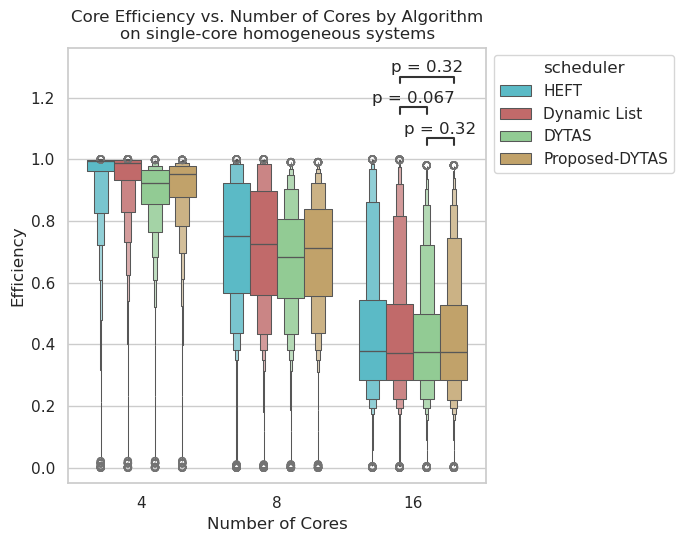

In [94]:
plot_boxen_dunn(df, system="single-core homogeneous", figsize=(7,6))

32_HEFT vs. 32_Dynamic List: Custom statistical test, P_val:7.780e-01
32_Dynamic List vs. 32_Proposed-DYTAS: Custom statistical test, P_val:4.347e-01
32_HEFT vs. 32_Proposed-DYTAS: Custom statistical test, P_val:3.493e-01
64_HEFT vs. 64_Dynamic List: Custom statistical test, P_val:5.875e-01
64_Dynamic List vs. 64_Proposed-DYTAS: Custom statistical test, P_val:5.682e-01
64_HEFT vs. 64_Proposed-DYTAS: Custom statistical test, P_val:3.119e-01
128_HEFT vs. 128_Dynamic List: Custom statistical test, P_val:7.371e-01
128_Dynamic List vs. 128_Proposed-DYTAS: Custom statistical test, P_val:7.371e-01
128_HEFT vs. 128_Proposed-DYTAS: Custom statistical test, P_val:7.265e-01
256_HEFT vs. 256_Dynamic List: Custom statistical test, P_val:9.716e-01
256_Dynamic List vs. 256_Proposed-DYTAS: Custom statistical test, P_val:9.716e-01
256_HEFT vs. 256_Proposed-DYTAS: Custom statistical test, P_val:9.716e-01


(<Figure size 900x600 with 1 Axes>,
 <Axes: title={'center': 'Core Efficiency vs. Number of Cores by Algorithm\non multi-core homogeneous systems'}, xlabel='Number of Cores', ylabel='Efficiency'>,
     cores          alg1            alg2          p_adj
 0      32          HEFT    Dynamic List   7.779907e-01
 1      32          HEFT           DYTAS   0.000000e+00
 2      32          HEFT  Proposed-DYTAS   3.492543e-01
 3      32  Dynamic List           DYTAS   0.000000e+00
 4      32  Dynamic List  Proposed-DYTAS   4.346620e-01
 5      32         DYTAS  Proposed-DYTAS   0.000000e+00
 6      64          HEFT    Dynamic List   5.875260e-01
 7      64          HEFT           DYTAS   0.000000e+00
 8      64          HEFT  Proposed-DYTAS   3.118961e-01
 9      64  Dynamic List           DYTAS   0.000000e+00
 10     64  Dynamic List  Proposed-DYTAS   5.681592e-01
 11     64         DYTAS  Proposed-DYTAS   0.000000e+00
 12    128          HEFT    Dynamic List   7.371256e-01
 13    128         

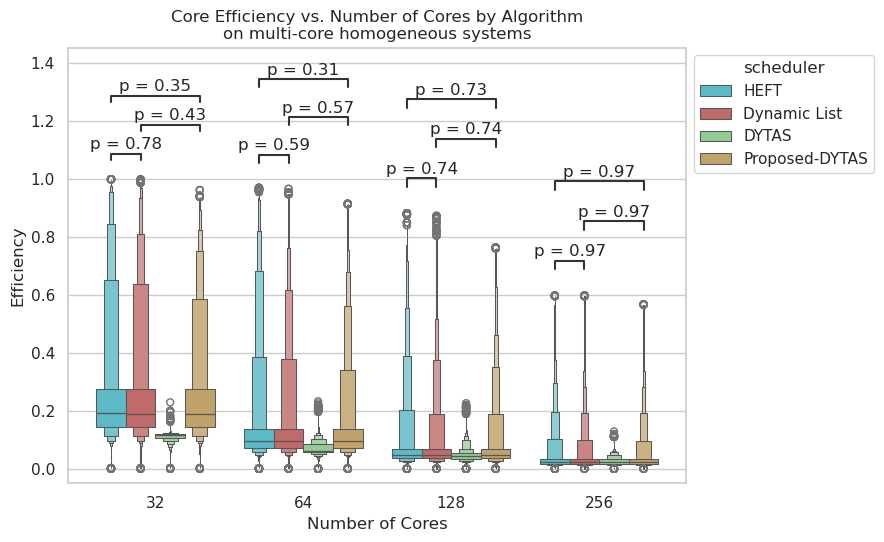

In [95]:
plot_boxen_dunn(df, system="multi-core homogeneous",figsize=(9,6))

In [96]:
# plot_boxen_dunn(df, system="homogeneous")

(<Figure size 700x600 with 1 Axes>,
 <Axes: title={'center': 'Core Efficiency vs. Number of Cores by Algorithm\non single-core heterogeneous systems'}, xlabel='Number of Cores', ylabel='Efficiency'>,
     cores          alg1            alg2          p_adj
 0       4          HEFT    Dynamic List   0.000000e+00
 1       4          HEFT           DYTAS   0.000000e+00
 2       4          HEFT  Proposed-DYTAS   0.000000e+00
 3       4  Dynamic List           DYTAS   0.000000e+00
 4       4  Dynamic List  Proposed-DYTAS  1.397881e-292
 5       4         DYTAS  Proposed-DYTAS   6.882928e-80
 6       8          HEFT    Dynamic List   0.000000e+00
 7       8          HEFT           DYTAS   0.000000e+00
 8       8          HEFT  Proposed-DYTAS   0.000000e+00
 9       8  Dynamic List           DYTAS   0.000000e+00
 10      8  Dynamic List  Proposed-DYTAS   0.000000e+00
 11      8         DYTAS  Proposed-DYTAS   2.783800e-24
 12     16          HEFT    Dynamic List   6.960104e-28
 13     16      

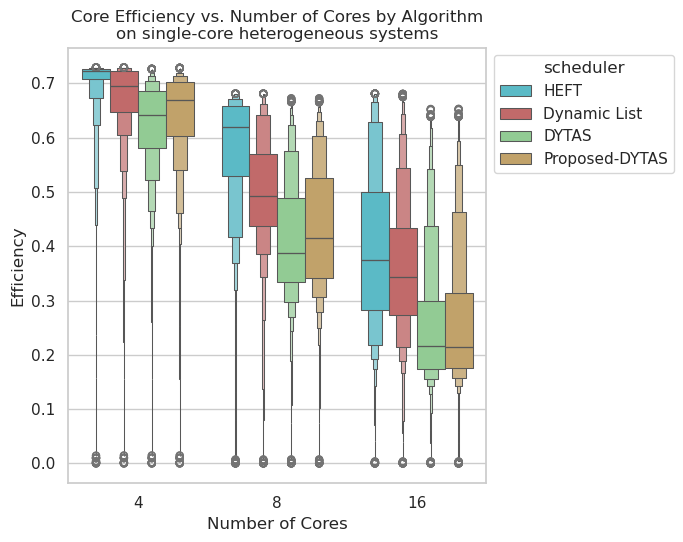

In [97]:
plot_boxen_dunn(df, system="single-core heterogeneous", figsize=(7,6))

128_HEFT vs. 128_Dynamic List: Custom statistical test, P_val:1.098e-01
256_HEFT vs. 256_Dynamic List: Custom statistical test, P_val:6.288e-01


(<Figure size 900x600 with 1 Axes>,
 <Axes: title={'center': 'Core Efficiency vs. Number of Cores by Algorithm\non multi-core heterogeneous systems'}, xlabel='Number of Cores', ylabel='Efficiency'>,
     cores          alg1            alg2          p_adj
 0      32          HEFT    Dynamic List   1.143770e-04
 1      32          HEFT           DYTAS   0.000000e+00
 2      32          HEFT  Proposed-DYTAS  4.949867e-108
 3      32  Dynamic List           DYTAS   0.000000e+00
 4      32  Dynamic List  Proposed-DYTAS   2.971815e-74
 5      32         DYTAS  Proposed-DYTAS   0.000000e+00
 6      64          HEFT    Dynamic List   9.625497e-03
 7      64          HEFT           DYTAS   0.000000e+00
 8      64          HEFT  Proposed-DYTAS   3.401550e-48
 9      64  Dynamic List           DYTAS   0.000000e+00
 10     64  Dynamic List  Proposed-DYTAS   3.129270e-33
 11     64         DYTAS  Proposed-DYTAS   0.000000e+00
 12    128          HEFT    Dynamic List   1.098202e-01
 13    128       

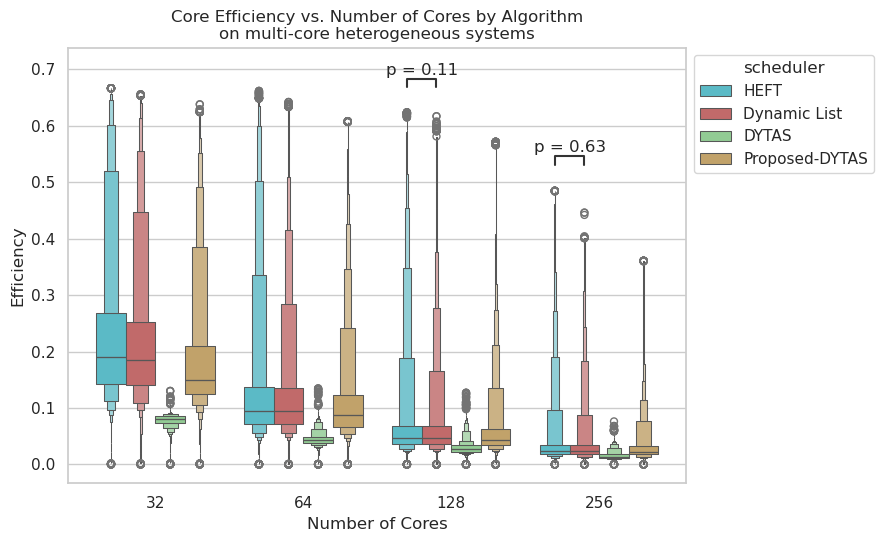

In [98]:
plot_boxen_dunn(df, system="multi-core heterogeneous",figsize=(9,6))

In [99]:
# plot_boxen_dunn(df, system="heterogeneous")

In [100]:
# plot_boxen_dunn(df, system="single-core")

In [101]:
# def _complete_grid(df, x, hue):
#     cores = sorted(df[x].unique())
#     algs  = sorted(df[hue].unique())
#     full  = pd.MultiIndex.from_product([cores, algs], names=[x, hue]).to_frame(index=False)
#     return full.merge(df, on=[x, hue], how="left")   # NaN rows where data missing

# df_full = _complete_grid(df, "core_count", "scheduler")
# df_full["scheduler"] = pd.Categorical(df_full["scheduler"],
#                                       categories=hue_order,
#                                       ordered=True)

In [102]:
# fig, tidy = boxen_dunn_non_sig(df_full, palette=cmap)


In [103]:
# fig, tidy = boxen_dunn_non_sig(df[df.system_type=="homogeneous"], palette=cmap)


In [104]:
# fig, tidy = boxen_dunn_non_sig(df[df.system_type=="heterogeneous"], palette=cmap)


In [105]:
figsize=(12,5)

In [106]:
def draw_p_val(p_val, x1, x2, y1, h = 0.03, alpha=0.05):

    if p_val < alpha:
        c="black"
    else:
        c="red"
    
    y_text = y1 + h + 0.01  # where the p-value text goes
    
    # Draw horizontal line
    plt.plot([x1, x1, x2, x2], [y1, y1 + h, y1 + h, y1], lw=1, c=c)
    
    # Add the p-value label
    plt.text((x1 + x2) / 2, y_text, f"p = {p_val:.2f}", ha='center', va='bottom', fontsize=10)

def draw_multi_and_single_core_ranges():
    y_offset = -.14
    # Drawing line under 4 to 16 to specify single core
    plt.text(1.07, y_offset-.1, "Single-core\nSystems", ha='center', va='bottom', fontsize=12)
    plt.annotate(
        '',
        xy=(.0001, y_offset), xytext=(2.03, y_offset),
        xycoords='data', textcoords='data',
        ha='center', va='top',
        arrowprops=dict(arrowstyle='|-|', lw=1.5),
        annotation_clip=False
    )
    
    # Drawing line between 32 and 256 to specify multi-core
    plt.text(4.5, y_offset - .1, "Multi-core\nSystems", ha='center', va='bottom', fontsize=12)
    plt.annotate(
        '',
        xy=(3, y_offset), xytext=(6, y_offset),
        xycoords='data', textcoords='data',
        ha='center', va='top',
        arrowprops=dict(arrowstyle='|-|',lw=1.5),
        annotation_clip=False
    )

In [107]:
def dunns_tests_per_core_count(df):
    core_counts = df.core_count.unique()
    core_counts.sort()
    for core_count in core_counts:
        dunns_tests_metrics(
            df[df.core_count == core_count],
            "Dunn's Test: Pairwise Comparisons Among Algorithms Accross " + str(core_count) + " Core Systems",
            ["efficiency_cores"]
        )

### All systems

In [108]:
# print("Statistical Significance of ALL SYSTEMS")
# dunns_tests_per_core_count(df)

In [109]:
# figsize=(12,5)
# plt.figure(figsize=figsize)
# sns.barplot(data=df, x="core_count", y="efficiency_cores", hue="scheduler",
#             hue_order=hue_order, palette=cmap)

# plt.legend(
#     title="Algorithm",
#     bbox_to_anchor=(1.05, 1),  # X=1.05 (right), Y=1 (top)
#     loc='upper left',
#     borderaxespad=0.
# )

# plt.title("Core Efficiency of each Algorithm on All Systems")
# plt.xlabel("")
# plt.ylabel("Efficiency")

# # pvalue between dytas and proposed dytas at 16 cores
# draw_p_val(0.03, 2.1, 2.3, 0.37)
# steps=0.2
# # Pvalue between heft and dynamic list
# draw_p_val(0.17, 23.5*steps, 24.5*steps, 0.11) # for 128 cores
# draw_p_val(0.67, 28.5*steps, 29.5*steps, 0.07) # for 256 cores

# draw_multi_and_single_core_ranges()


# plt.show()

### Homogeneous Systems

homogeneous systems


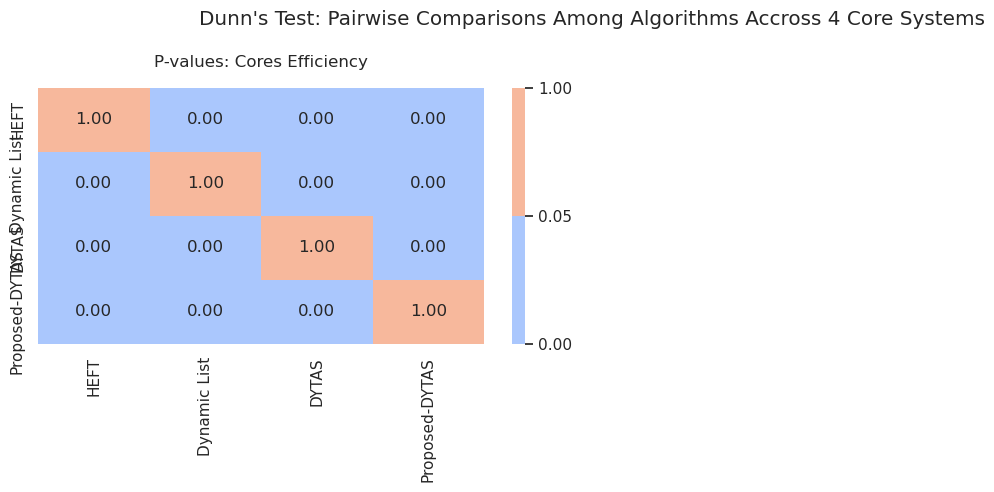

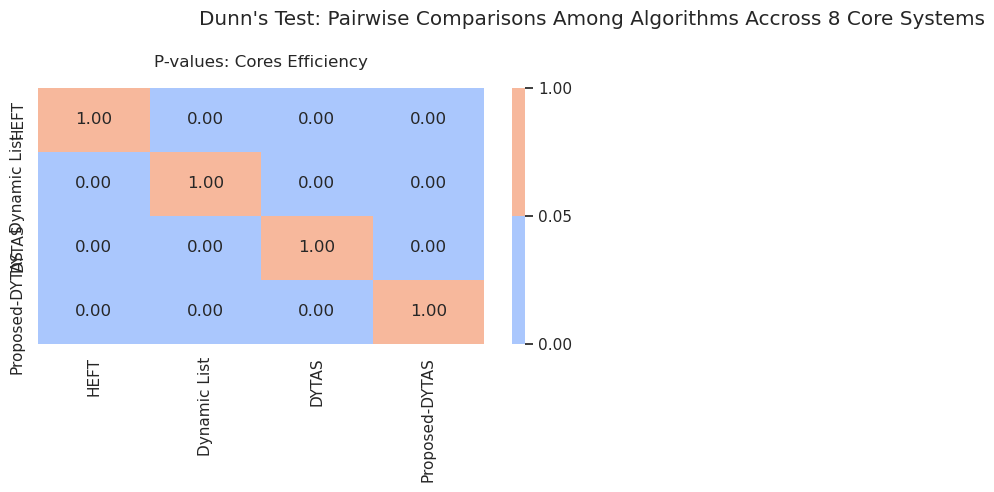

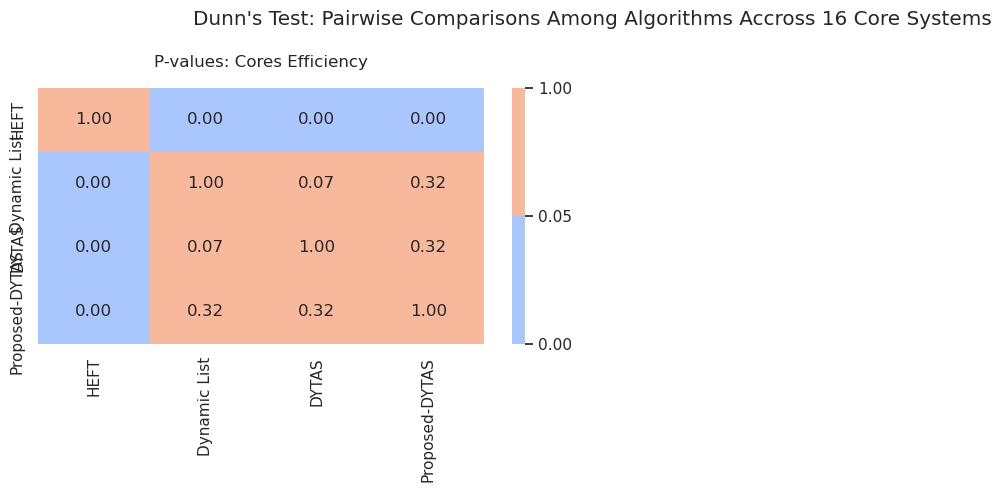

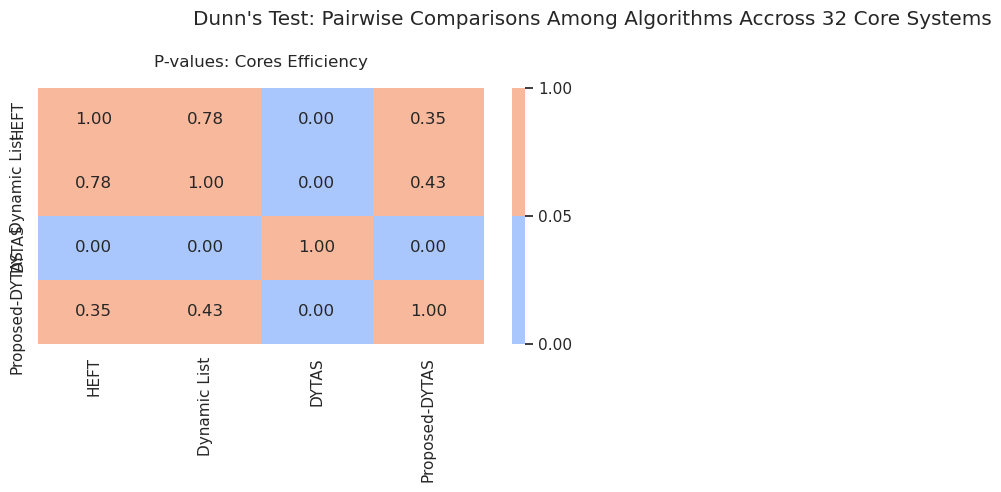

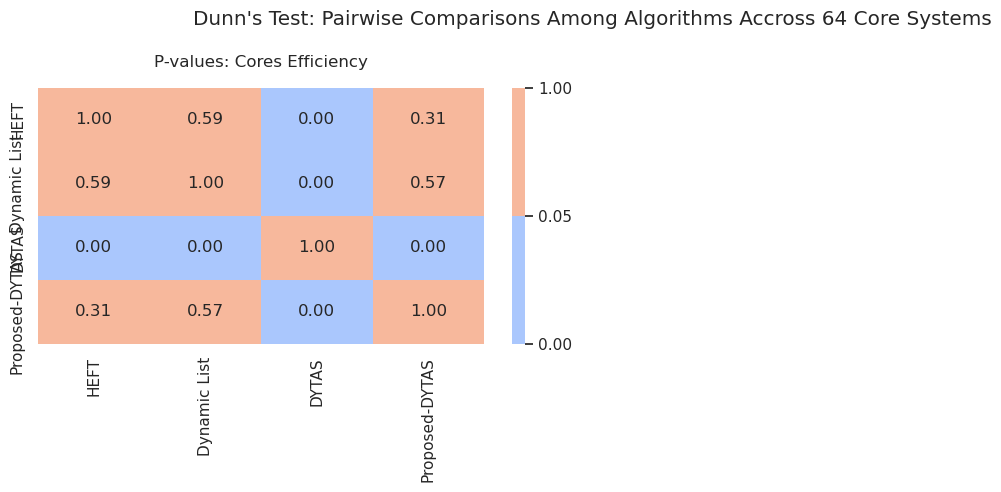

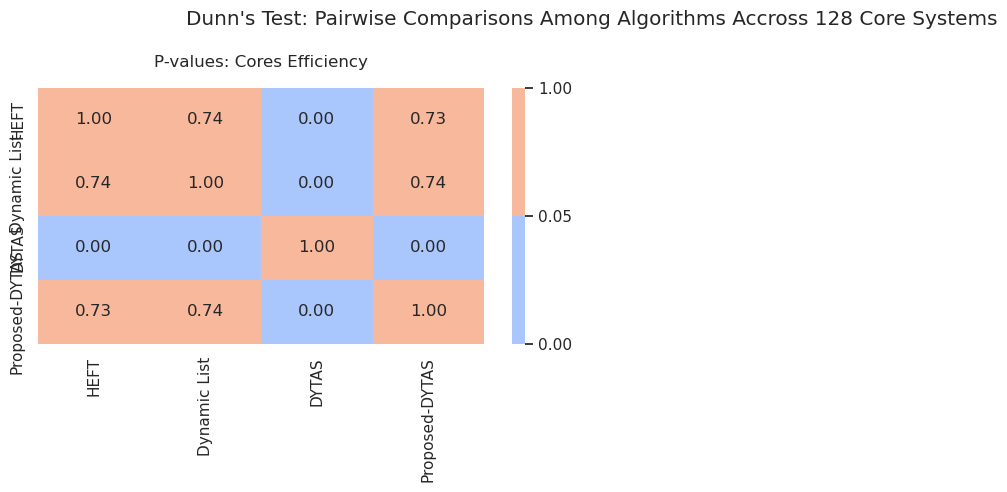

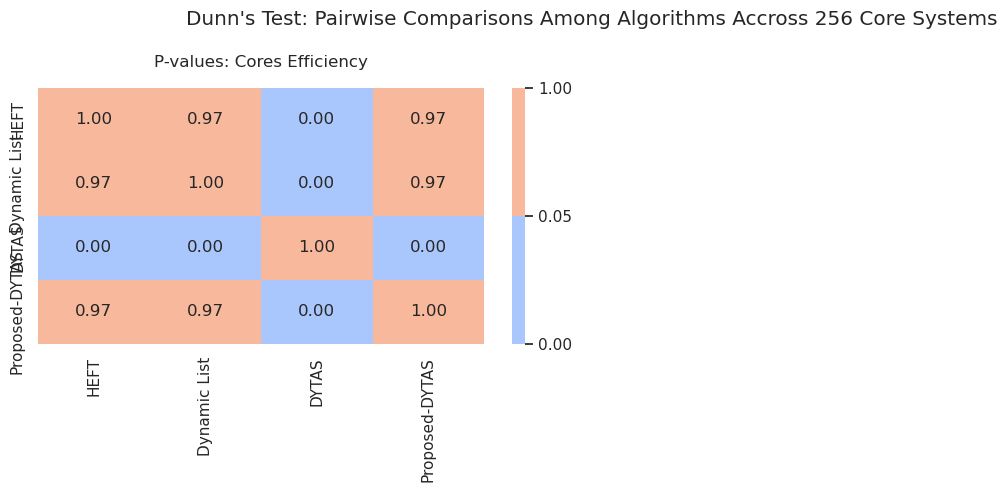

In [110]:
print("homogeneous systems")
dunns_tests_per_core_count(df[df.system_type == "homogeneous"])

In [111]:
# figsize=(12,5)
# plt.figure(figsize=figsize)
# sns.barplot(data=df[df.system_type=="homogeneous"], x="core_count", y="efficiency_cores", hue="scheduler",
#             hue_order=hue_order, palette=cmap)

# plt.legend(
#     title="Algorithm",
#     bbox_to_anchor=(1.05, 1), 
#     loc='upper left',
#     borderaxespad=0.
# )

# plt.title("Core Efficiency of each Algorithm on Homogeneous Systems")
# plt.xlabel("")
# plt.ylabel("Efficiency")


    

# x_Proposed_DYTAS = 2.3
# x_DYTAS = 2.1
# x_dynamic_list = 1.9

# # 16 cores
# # DYTAS & Proposed-DYTAS: 0.32
# draw_p_val(0.32, x_DYTAS, x_Proposed_DYTAS, 0.45)

# # Proposed-DYTAS & Dynamic List: 0.32
# draw_p_val(0.32, x_dynamic_list, x_Proposed_DYTAS, 0.55)

# # DYTAS & Dynamic List: 0.07
# draw_p_val(0.07, x_dynamic_list, x_DYTAS, 0.65)

# # 32 cores
# draw_p_val(0.35, 13.5*steps, 16.5*steps, 0.3)
# draw_p_val(0.43, 14.5*steps, 16.5*steps, 0.4)
# draw_p_val(0.78, 13.5*steps, 14.5*steps, 0.5)


# # 64 cores
# draw_p_val(0.59, 18.5*steps, 19.5*steps, 0.2)
# draw_p_val(0.31, 18.5*steps, 21.5*steps, 0.4)
# draw_p_val(0.57, 19.5*steps, 21.5*steps, 0.3)


# # 128 cores
# draw_p_val(0.74, 23.5*steps, 24.5*steps, 0.15)
# draw_p_val(0.73, 23.5*steps, 26.5*steps, 0.25)
# draw_p_val(0.74, 24.5*steps, 26.5*steps, 0.35)

# # 256 cores
# draw_p_val(0.97, 28.5*steps, 31.5*steps, 0.1)
# draw_p_val(0.97, 28.5*steps, 29.5*steps, 0.2)
# draw_p_val(0.97, 29.5*steps, 31.5*steps, 0.3)



# draw_multi_and_single_core_ranges()


# plt.show()

### Heterogenous systems

heterogeneous systems


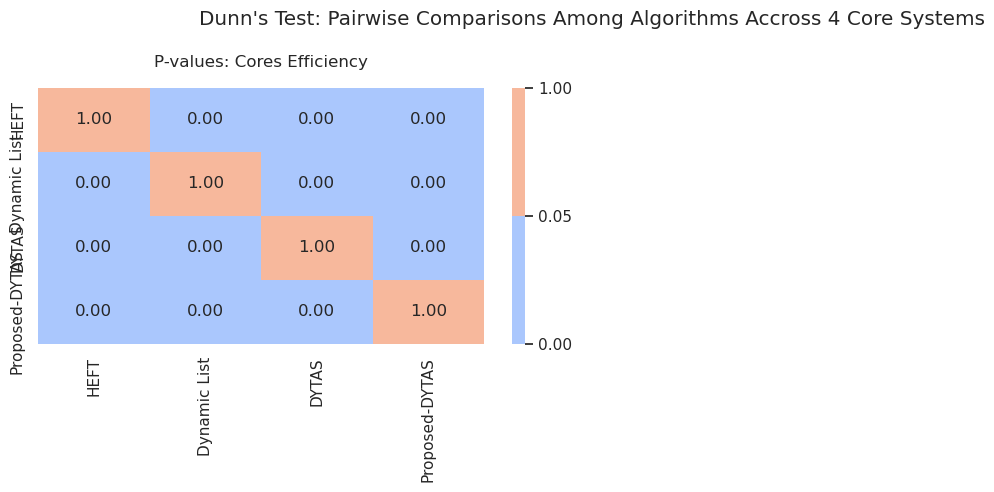

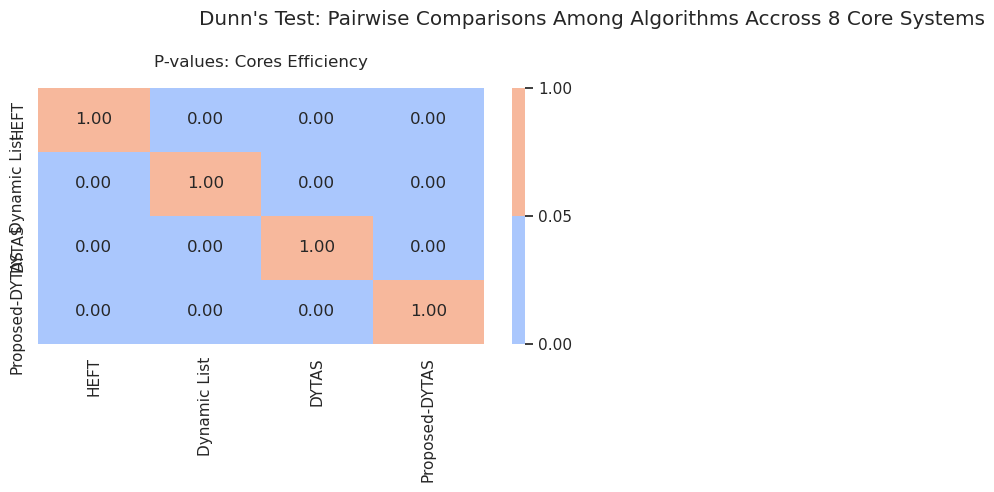

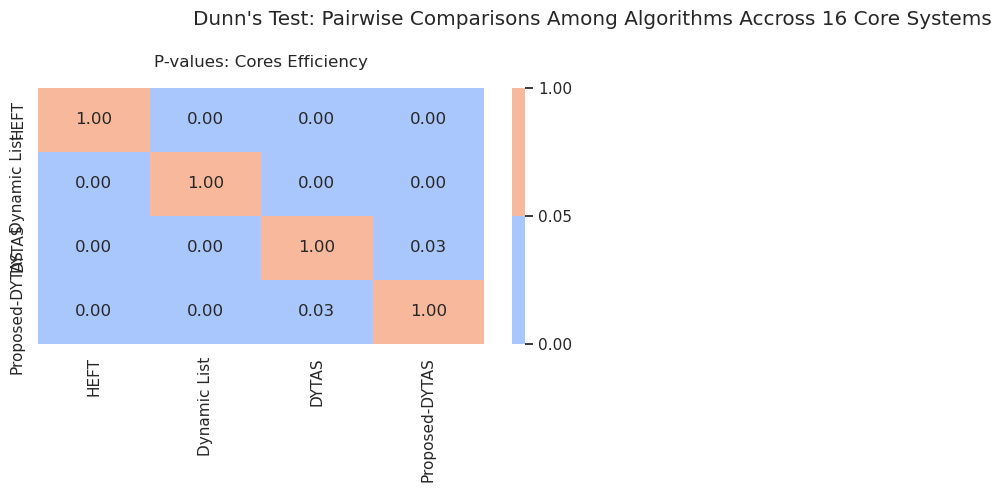

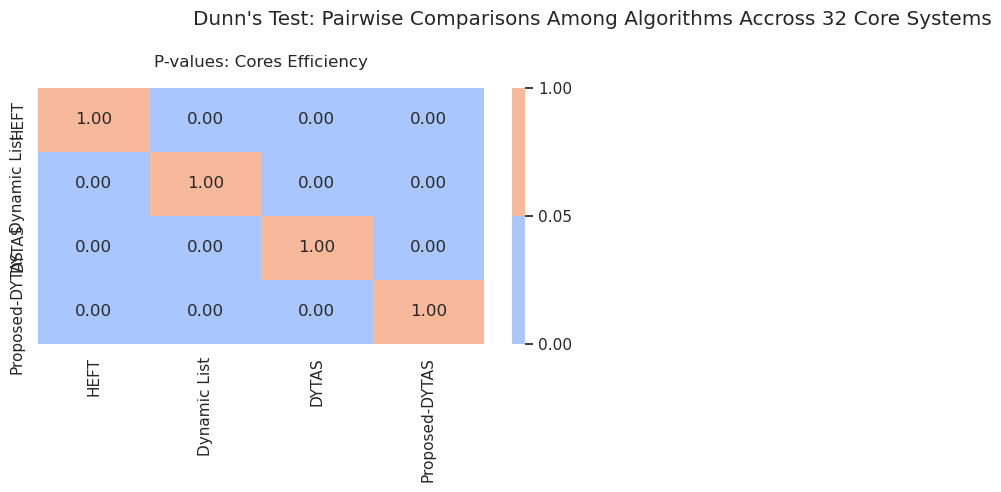

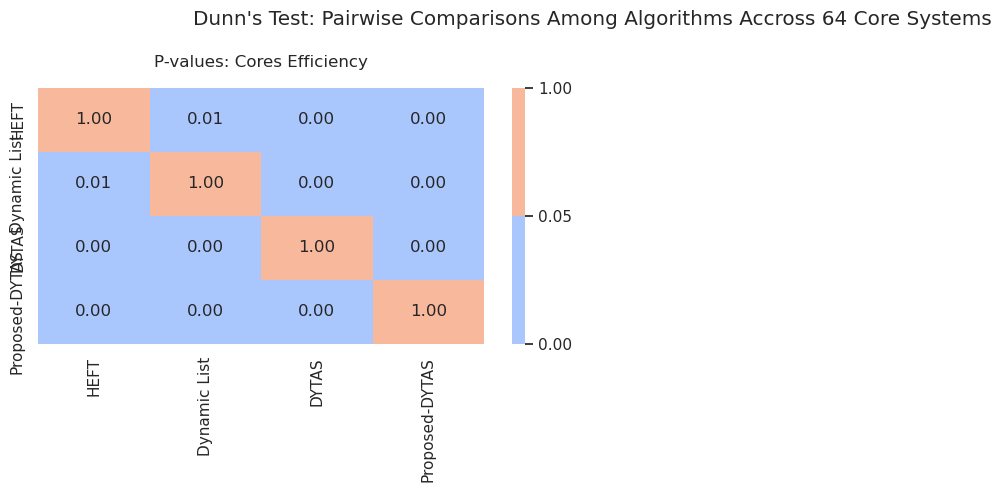

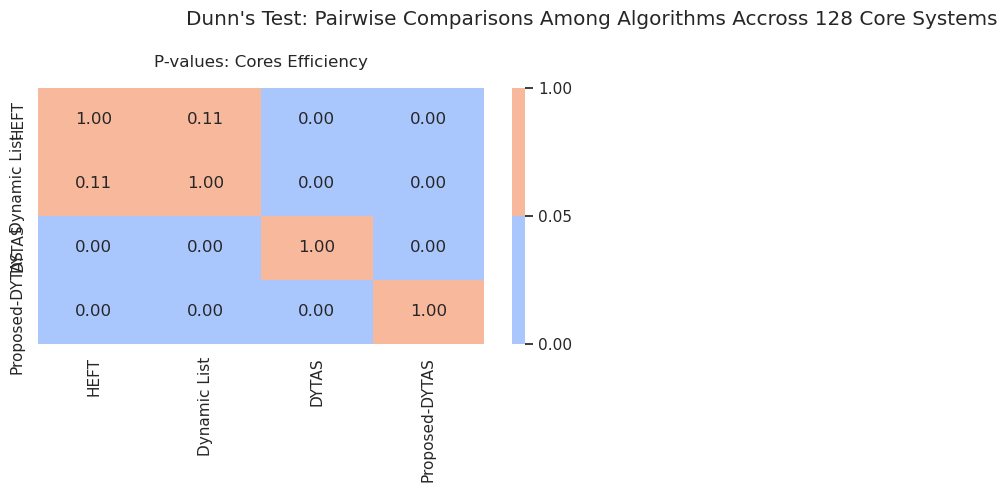

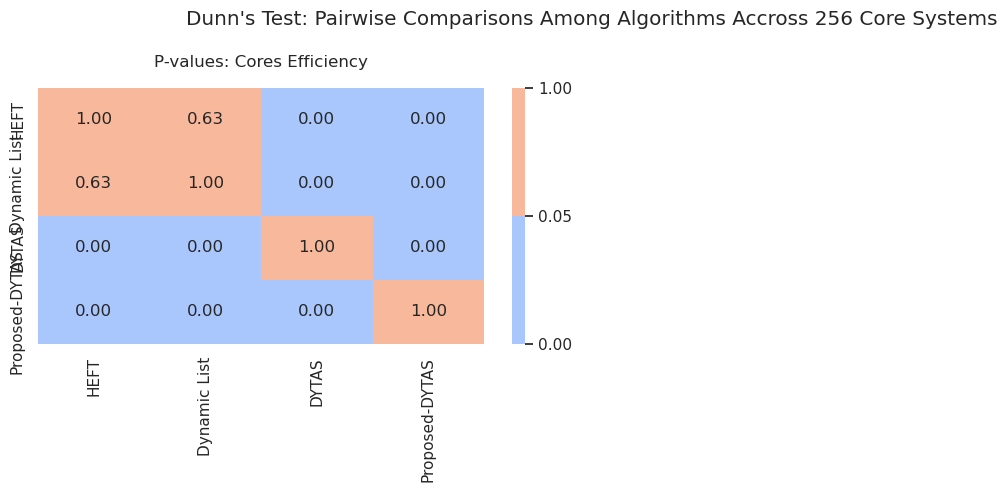

In [112]:
print("heterogeneous systems")
dunns_tests_per_core_count(df[df.system_type == "heterogeneous"])

In [113]:
# figsize=(12,5)
# plt.figure(figsize=figsize)
# sns.barplot(data=df[df.system_type=="heterogeneous"], x="core_count", y="efficiency_cores", hue="scheduler",
#             hue_order=hue_order, palette=cmap)

# plt.legend(
#     title="Algorithm",
#     bbox_to_anchor=(1.05, 1),  # X=1.05 (right), Y=1 (top)
#     loc='upper left',
#     borderaxespad=0.
# )

# plt.title("Core Efficiency of each Algorithm on Heterogeneous Systems")
# plt.xlabel("")
# plt.ylabel("Efficiency")

# draw_p_val(0.03, 2.1, 2.3, 0.37)


# # 128 cores
# draw_p_val(0.11, 23.5*steps, 24.5*steps, 0.11)


# # 256 cores
# draw_p_val(0.63, 28.5*steps, 29.5*steps, 0.07)


# draw_multi_and_single_core_ranges()


# plt.show()

In [114]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import scikit_posthocs as sp

# # Assuming 'df' is your DataFrame with columns 'value' and 'group'
# dunn_results = sp.posthoc_dunn(df, val_col='efficiency_cores', group_col='scheduler', p_adjust='bonferroni')

# import itertools
# import pandas as pd

# # Extract group names
# groups = dunn_results.columns.tolist()

# # Create list of all pairwise combinations
# comparisons = list(itertools.combinations(groups, 2))

# # Prepare annotation data
# annotations = []
# for group1, group2 in comparisons:
#     p_value = dunn_results.loc[group1, group2]
#     annotations.append({
#         'group1': group1,
#         'group2': group2,
#         'p_value': p_value,
#         'significance': 'ns' if p_value >= 0.05 else '*'
#     })

# annotations_df = pd.DataFrame(annotations)


# # Create bar plot
# ax = sns.barplot(x='scheduler', y='efficiency_cores', data=df, ci='sd')

# # Add annotations
# y_max = df['efficiency_cores'].max()
# y_offset = y_max * 0.05  # Adjust as needed
# for i, row in annotations_df.iterrows():
#     x1 = groups.index(row['group1'])
#     x2 = groups.index(row['group2'])
#     x_coords = [x1, x2]
#     y = y_max + y_offset * (i + 1)
#     ax.plot(x_coords, [y, y], color='black')
#     ax.text((x1 + x2) / 2, y + y_offset * 0.1, row['significance'], ha='center', va='bottom')

# plt.show()


In [115]:
# from statannotations.Annotator import Annotator


In [116]:
# plt.figure(figsize=figsize)
# g = sns.barplot(data=df[df.processor_count == df.core_count], x="core_count", y="efficiency_cores",
#             hue="scheduler",hue_order=hue_order, palette=cmap)

# plt.legend(
#     title="Algorithm",
#     bbox_to_anchor=(1.05, 1),
#     loc='upper left',
#     borderaxespad=0.
# )

# plt.title("Single-Core Efficiency of each Algorithm")
# plt.xlabel("No. Cores in System")
# plt.ylabel("Efficiency")


# p_val = 0.03

# # These correspond to the bars at x=16 for DYTAS and Proposed-DYTAS
# # You may need to fine-tune these based on your hue order and bar positions
# x1 = 2.1  # approx center of DYTAS bar at x=16
# x2 = 2.3  # approx center of Proposed-DYTAS bar at x=16

# y1 = 0.37  # height of tallest of the two bars (adjust if needed)
# h = 0.095   # height offset for the line above the bar
# y_text = y1 + h + 0.01  # where the p-value text goes

# # Draw horizontal line
# plt.plot([x1, x1, x2, x2], [y1, y1 + h, y1 + h, y1], lw=1.5, c='black')

# # Add the p-value label
# plt.text((x1 + x2) / 2, y_text, f"Dunn's \np = {p_val:.2f}", ha='center', va='bottom', fontsize=10)

# plt.show()

In [117]:
# plt.figure(figsize=figsize)
# sns.barplot(data=df[df.processor_count != df.core_count], x="core_count", y="efficiency_cores",
#             hue="scheduler",hue_order=hue_order, palette=cmap)

# plt.legend(
#     title="Algorithm",
#     bbox_to_anchor=(1.05, 1),
#     loc='upper left',
#     borderaxespad=0.
# )

# plt.title("Multi-Core Efficiency of each Algorithm")
# plt.xlabel("No. Cores in System")
# plt.ylabel("Efficiency")
# plt.show()

## Algorithm Runtime

In [118]:
# def draw_p_val_vertical(p_val,
#                         y1, y2,         # the two y‑points you want to connect
#                         x,               # x‑location of the bracket’s left edge
#                         w=0.01,          # horizontal “leg” length of the bracket
#                         alpha=0.05,
#                         text_dx=0.01):   # extra offset for the label
#     """
#     Draw a vertical squared‑U (┐┌) bracket with a p‑value label.

#     Parameters
#     ----------
#     p_val : float
#     y1, y2 : float
#         Y‑coordinates (data units) that the bracket should span.
#     x : float
#         X‑coordinate where the bracket is anchored.
#     w : float, optional
#         Horizontal width of the bracket legs (data units on x‑axis).
#     alpha : float, optional
#         Significance threshold that controls the bracket colour.
#     text_dx : float, optional
#         Additional horizontal offset for the text so it sits
#         a bit to the right of the bracket.
#     """
#     # choose colour based on significance
#     colour = "black" if p_val < alpha else "red"

#     # guarantee bottom–top ordering
#     y_bottom, y_top = sorted((y1, y2))

#     # draw the squared bracket:  ┐|
#     plt.plot([x, x + w, x + w, x],
#              [y_bottom, y_bottom, y_top, y_top],
#              lw=1, c=colour)

#     # put the text in the middle of the bracket
#     plt.text(x + w + text_dx,
#              (y_bottom + y_top) / 2,
#              f"p = {p_val:.2g}",
#              va='center', ha='left',
#              fontsize=10, color=colour)


In [119]:
# plot_distribution_per_wf(df[df.scheduler!="Dynamic List"], "exec_time")

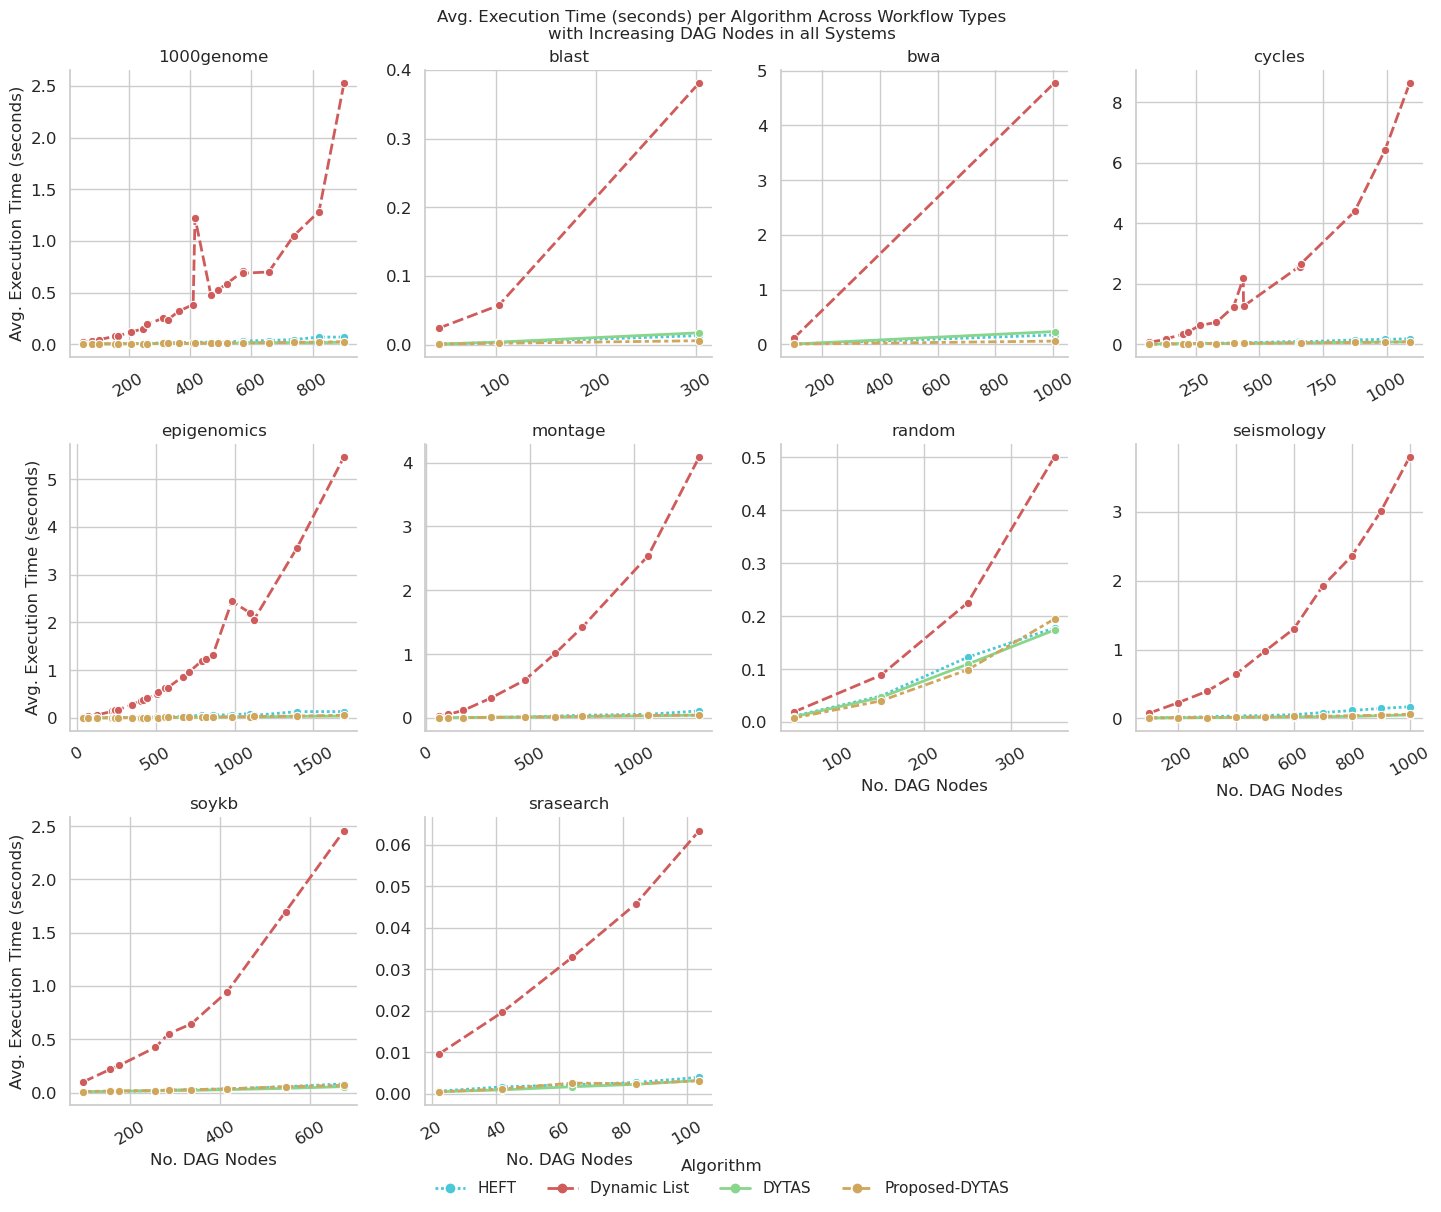

In [120]:
plot_avg_metric_by_workflow(df, metric="exec_time", col_wrap=4,
                            aspect=.8,
                            height=4)

In [121]:
hue_order_no_dynamic_list = hue_order.copy()
hue_order_no_dynamic_list.remove("Dynamic List")

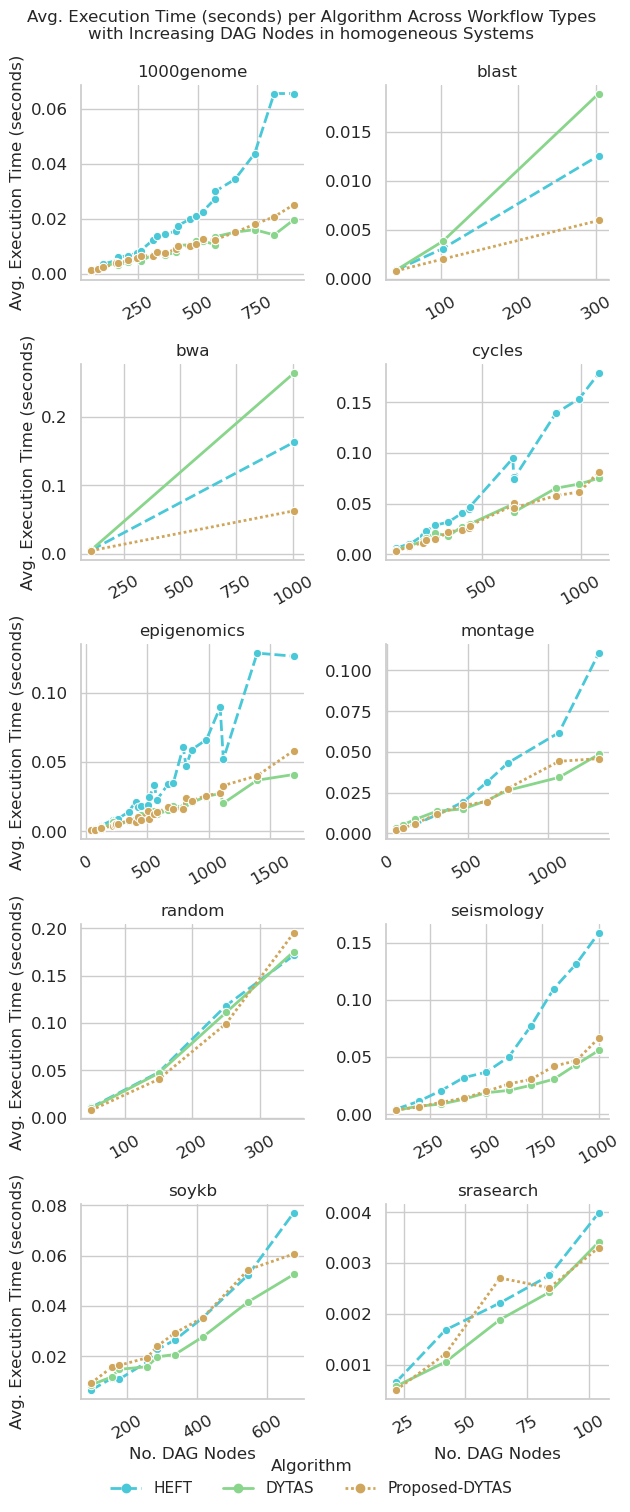

In [122]:
plot_avg_metric_by_workflow(df[df.scheduler != "Dynamic List"], 
                            metric="exec_time", system="homogeneous",
                           col_wrap=2,
                           hue_order=hue_order_no_dynamic_list,
                           legend_ncol=len(hue_order_no_dynamic_list),
                            aspect=.8,
                            height=3
                           )

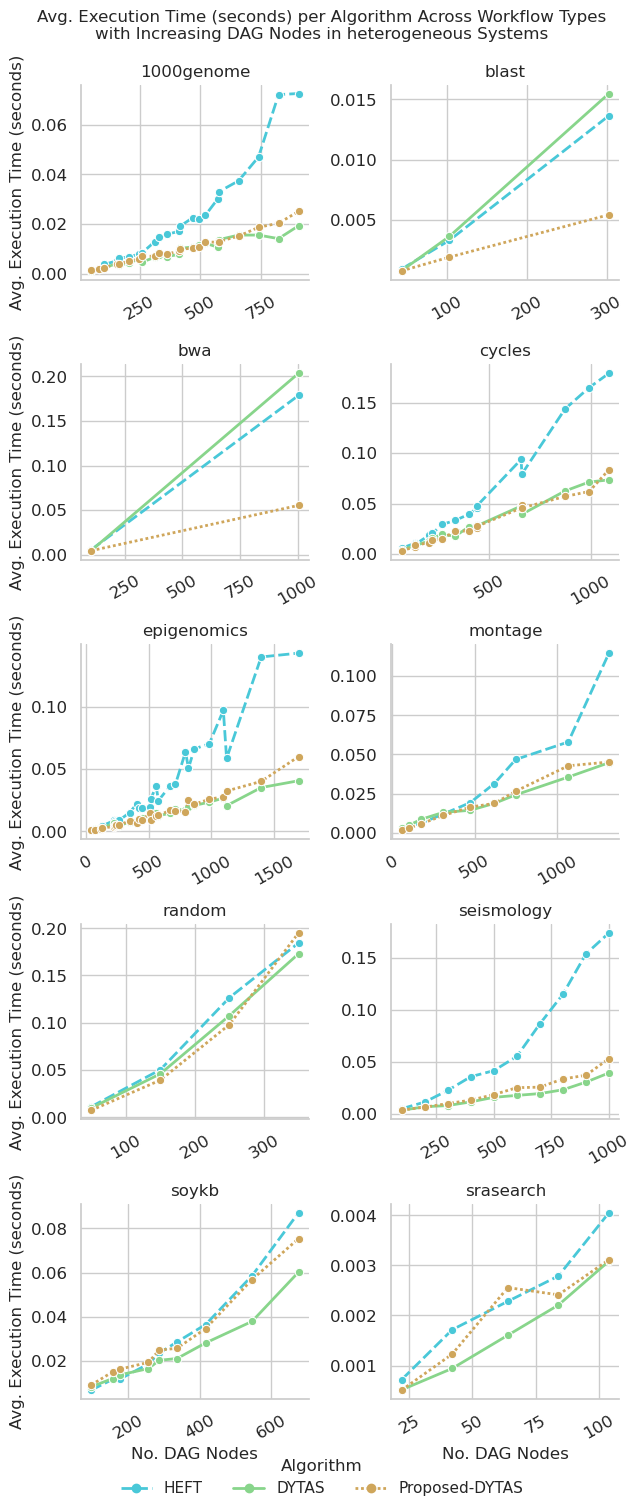

In [123]:

plot_avg_metric_by_workflow(df[df.scheduler != "Dynamic List"], 
                            metric="exec_time", system="heterogeneous",
                           col_wrap=2,
                           hue_order=hue_order_no_dynamic_list,
                           legend_ncol=len(hue_order_no_dynamic_list),
                            aspect=.8,
                            height=3
                           )

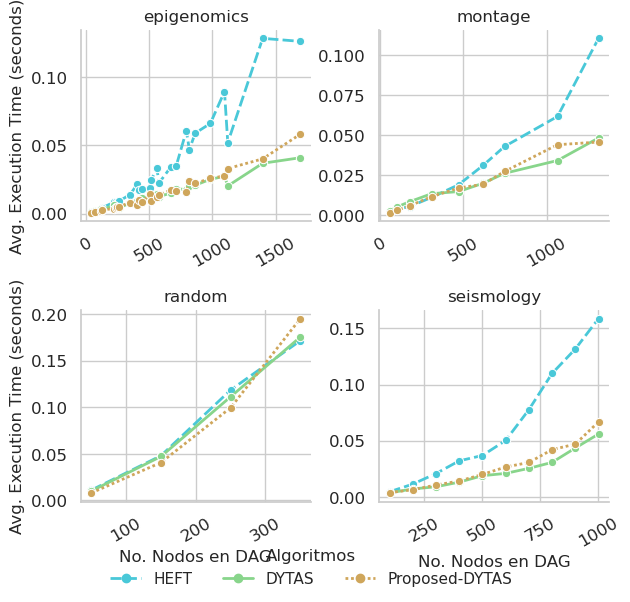

In [124]:
plot_avg_metric_by_workflow(df_presentacion[df_presentacion.scheduler != "Dynamic List"], 
                            metric="exec_time", system="homogeneous",
                           col_wrap=2,
                           hue_order=hue_order_no_dynamic_list,
                           legend_ncol=len(hue_order_no_dynamic_list),
                            aspect=.8,
                            height=3,
                            suptitle="",
                            legend_title="Algoritmos",
                            x_label="No. Nodos en DAG"
                           )

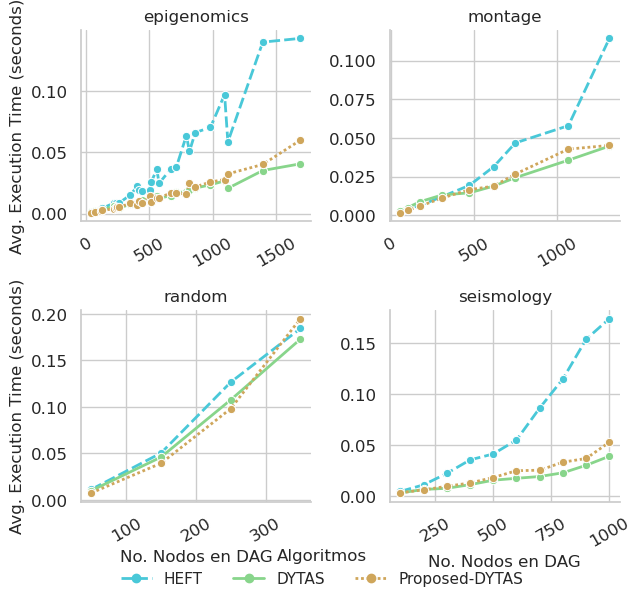

In [125]:
plot_avg_metric_by_workflow(df_presentacion[df_presentacion.scheduler != "Dynamic List"], 
                            metric="exec_time", system="heterogeneous",
                           col_wrap=2,
                           hue_order=hue_order_no_dynamic_list,
                           legend_ncol=len(hue_order_no_dynamic_list),
                            aspect=.8,
                            height=3,
                            suptitle="",
                            legend_title="Algoritmos",
                            x_label="No. Nodos en DAG"
                           )

DYTAS vs. Proposed-DYTAS: Custom statistical test, P_val:1.757e-01
DYTAS vs. Proposed-DYTAS: Custom statistical test, P_val:8.285e-02
HEFT vs. DYTAS: Custom statistical test, P_val:3.225e-01


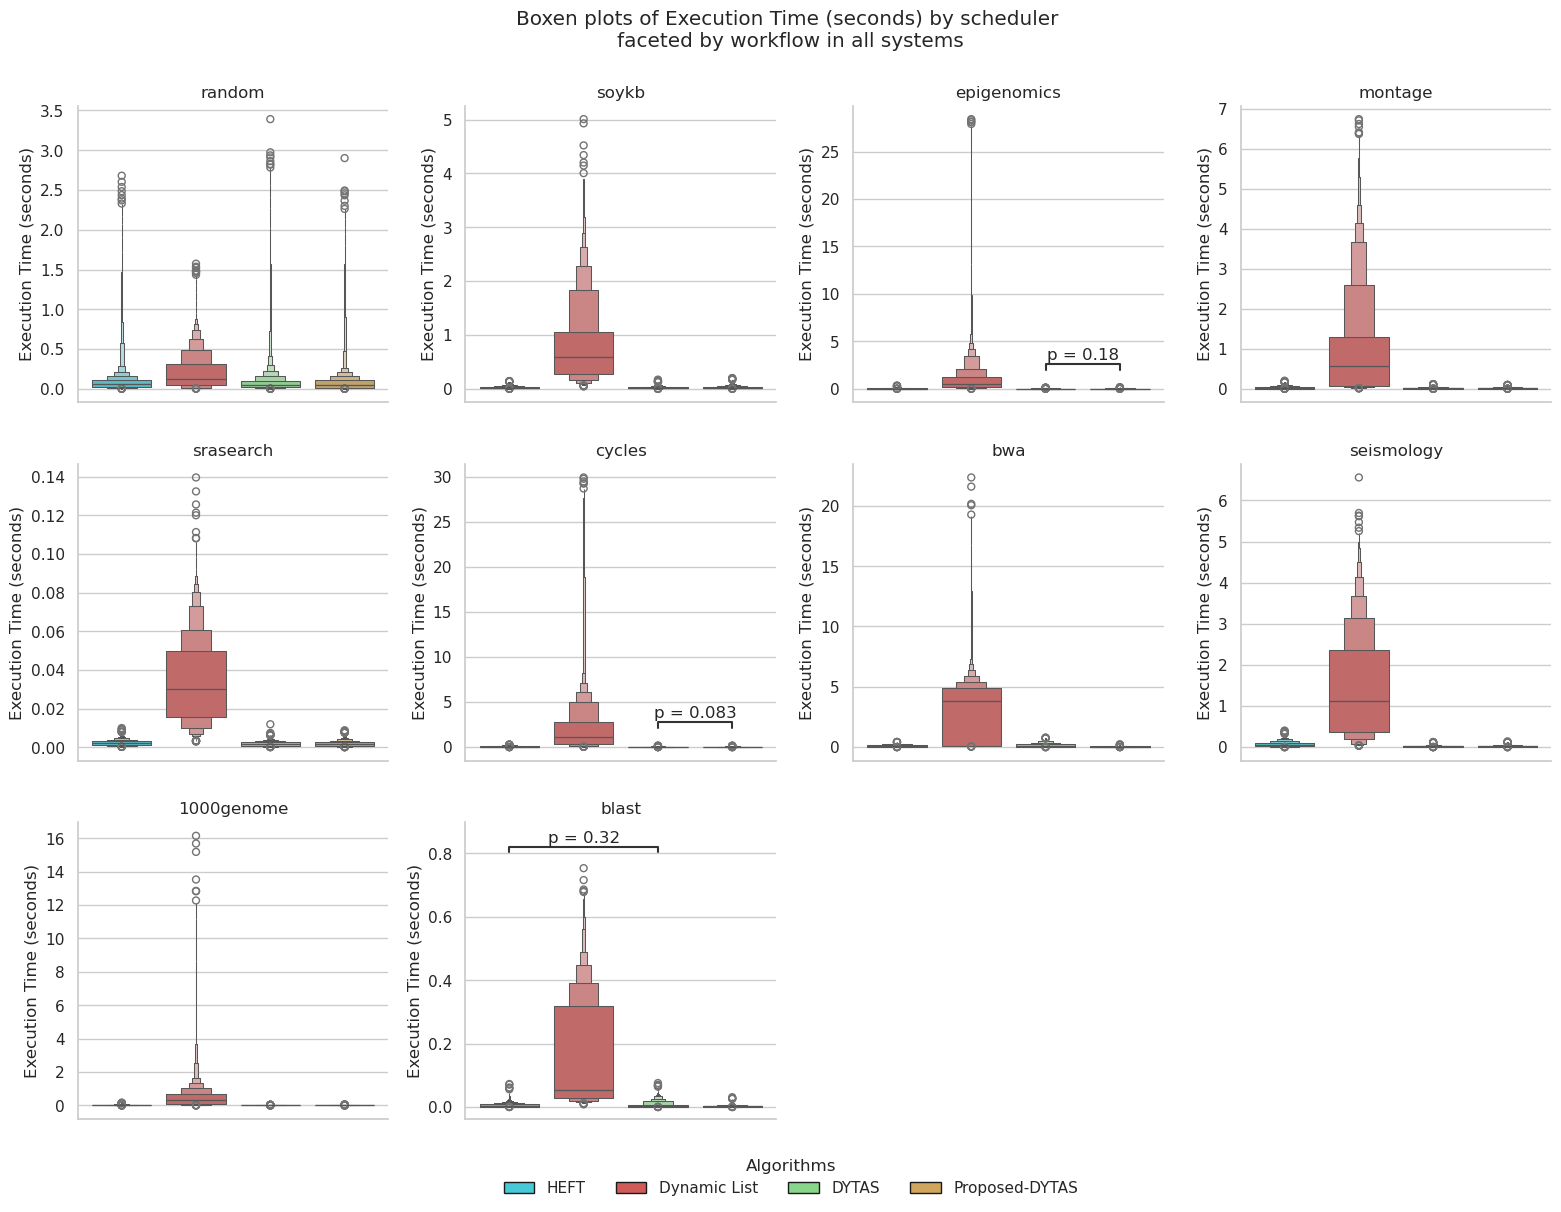

In [126]:
facet_dist_dunn(
    df, "scheduler", 
    "exec_time", "workflow",
    palette_map=cmap,
    legend_title="Algorithms",
    catplot_kwargs=dict(col_wrap=4), 
    metrics_names=metrics_names
)

**NOTE: The Dunn's tests performed without Dynamic List will result in different p-values than when Dynamic List is included.**

In [127]:
# for workflow in df.workflow.unique():
#     dunns_tests_metrics(df[df.workflow==workflow], metrics=["exec_time"], title=workflow)

In [128]:
# facet_dist_dunn(
#     df[df.scheduler != "Dynamic List"], "scheduler", 
#     "exec_time", "workflow",
#     palette_map=cmap,
#     legend_title="Algorithms",
#     catplot_kwargs=dict(col_wrap=2), 
#     metrics_names=metrics_names
# )

DYTAS vs. Proposed-DYTAS: Custom statistical test, P_val:2.726e-01
DYTAS vs. Proposed-DYTAS: Custom statistical test, P_val:5.172e-01
DYTAS vs. Proposed-DYTAS: Custom statistical test, P_val:6.540e-02
HEFT vs. DYTAS: Custom statistical test, P_val:1.834e-01


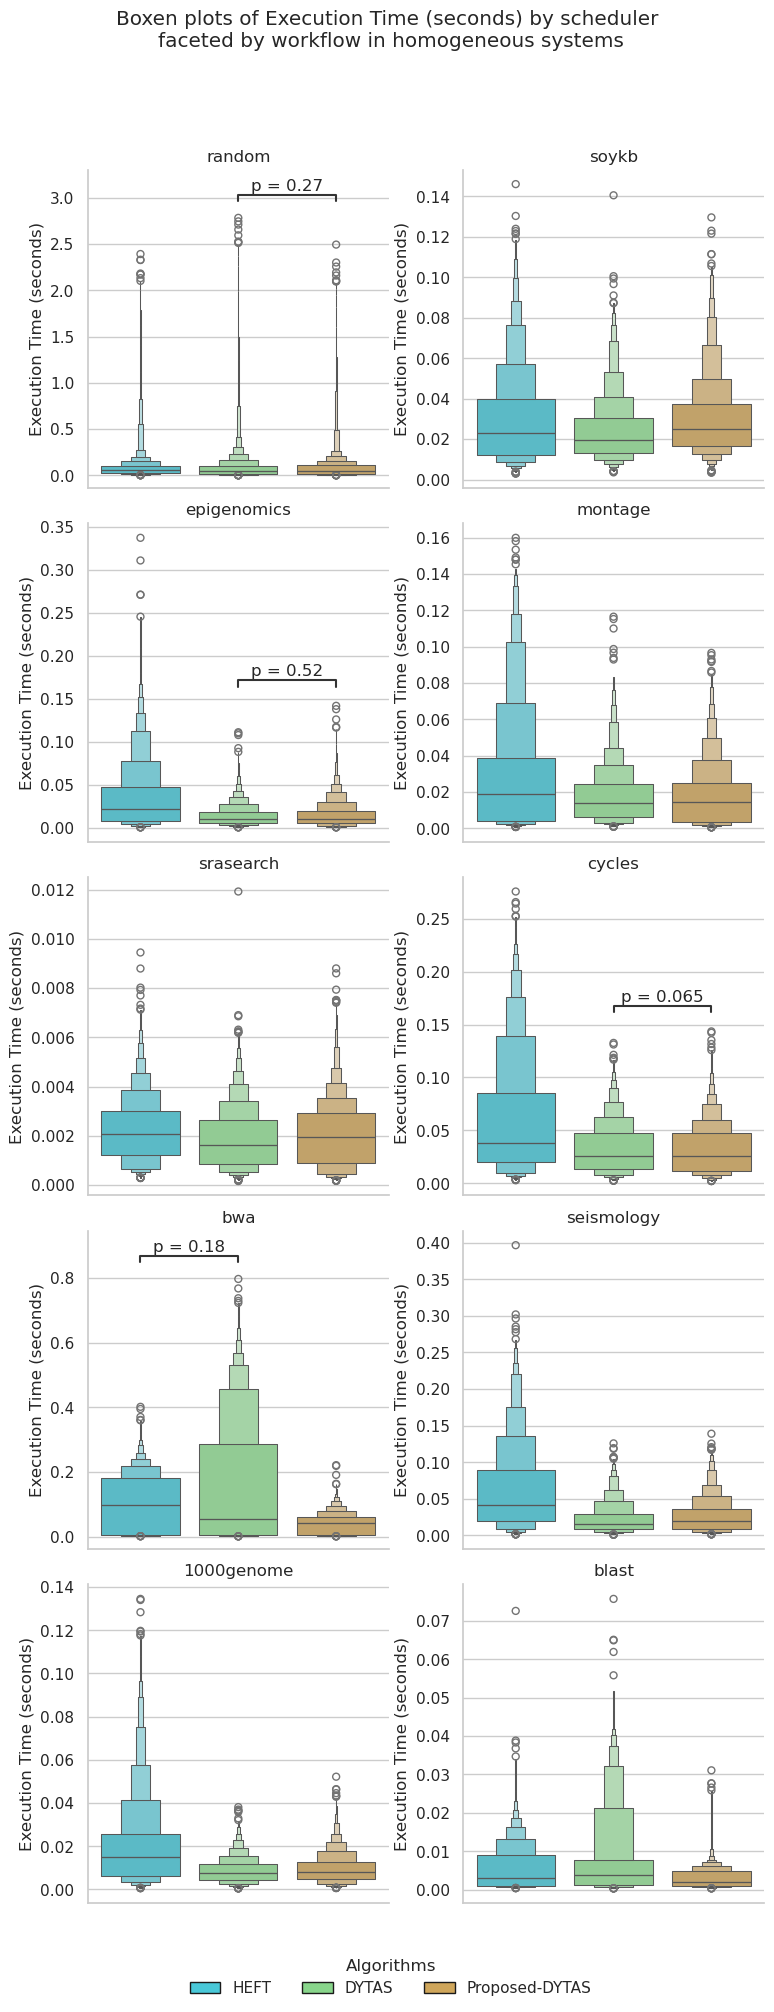

In [129]:
facet_dist_dunn(
    df[df.scheduler != "Dynamic List"], "scheduler", 
    "exec_time", "workflow",
    palette_map=cmap,
    legend_title="Algorithms",
    catplot_kwargs=dict(col_wrap=2), 
    metrics_names=metrics_names,
    system="homogeneous"
)

DYTAS vs. Proposed-DYTAS: Custom statistical test, P_val:6.171e-02
DYTAS vs. Proposed-DYTAS: Custom statistical test, P_val:1.148e-01
DYTAS vs. Proposed-DYTAS: Custom statistical test, P_val:1.722e-01


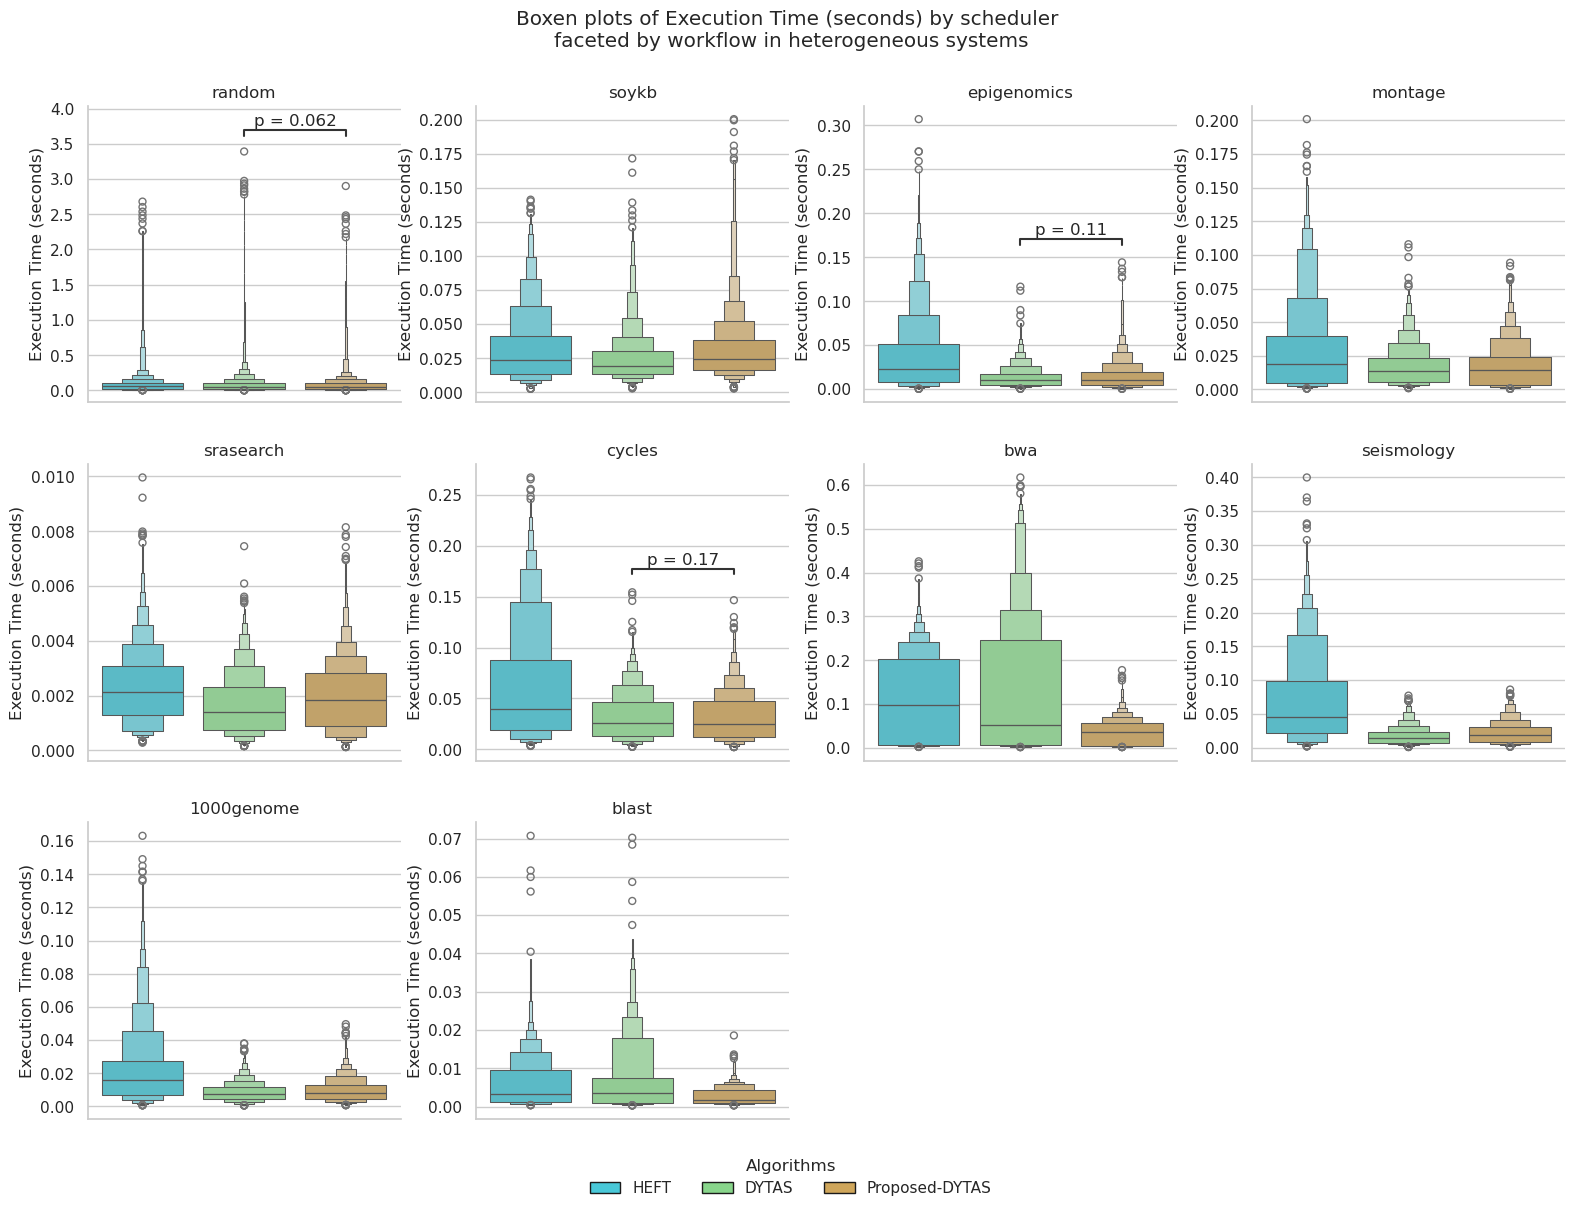

In [130]:
facet_dist_dunn(
    df[df.scheduler != "Dynamic List"], "scheduler", 
    "exec_time", "workflow",
    palette_map=cmap,
    legend_title="Algorithms",
    catplot_kwargs=dict(col_wrap=4), 
    metrics_names=metrics_names,
    system="heterogeneous"
)

In [131]:
# facet_dist_dunn(
#     df[df.scheduler != "Dynamic List"], "scheduler", 
#     "exec_time", "workflow",
#     palette_map=cmap,
#     legend_title="Algorithms",
#     catplot_kwargs=dict(col_wrap=4), 
#     metrics_names=metrics_names,
#     system="single-core"
# )

In [132]:
# def workflow_vs_exec_time(df_og, system="all", figsize=(6,7), exclude="Dynamic List"):
#     df = filter_by_system(df_og, system)



#     hue_order_cp = hue_order.copy()
#     if exclude:
#         hue_order_cp.remove(exclude)
#         df = df[df.scheduler != exclude]
    
#     plt.figure(figsize=figsize)
#     g = sns.boxenplot(df, 
#                 y="workflow", x="exec_time", hue="scheduler",
#                 palette=cmap,hue_order=hue_order_cp
#                    )
    
#     g.set_xlabel(metrics_names["exec_time"])
#     g.set_ylabel("Workflow Type")
#     g.set_title("Avg. Algorithm Execution Time on each \nWorkflow Type in " +system+ " Systems")
#     plt.legend(
#         title="Algorithm",
#         # bbox_to_anchor=(1.05, 1),
#         # loc='upper left',
#         # borderaxespad=0.
#     )
#     plt.tight_layout()



In [133]:
# workflow_vs_exec_time(df, exclude="")
# plt.show()

The execution time of Dynamic List is terrible. Will remove to better see the other results

Performing statistical significance tests

In [134]:
# for workflow in df.workflow.unique():
#     print(workflow)
#     print(kruskal_wallis_helper(df[df.workflow==workflow],
#                                 metrics=["exec_time"]))

In [135]:
# for workflow in df.workflow.unique():
#     print(workflow)    
#     print(dunns_tests_metrics(
#         df[df.workflow==workflow],
#                               title="Dunn's Test: Significance of execution times per algorithm on " + workflow,
#                                 metrics=["exec_time"]))

In [136]:

# workflow_vs_exec_time(df)

# steps = .05
# draw_p_val_vertical(0.02, 5*steps, steps,0.09)

# draw_p_val_vertical(0.32, 35*steps, 40*steps,0.01)

# draw_p_val_vertical(0.08, 80*steps, 85*steps,0.035)

# draw_p_val_vertical(0.18, 100*steps, 105*steps,0.018)

# draw_p_val_vertical(0.02, 120*steps, 125*steps,0.022)


# plt.show()

In [137]:
# for workflow in df.workflow.unique():
#     print(workflow)    
#     print(dunns_tests_metrics(
#         df[(df.system_type=="homogeneous")&(df.workflow==workflow)],
#                               title="Dunn's Test: Significance of execution times per algorithm on " + workflow,
#                                 metrics=["exec_time"]))

In [138]:
# workflow_vs_exec_time(df, system="homogeneous")

# steps = .05
# draw_p_val_vertical(0.17, 5*steps, steps,0.09)

# draw_p_val_vertical(0.01, 20*steps, 25*steps,0.015)

# draw_p_val_vertical(0.01, 35*steps, 40*steps,0.01)

# # draw_p_val_vertical(0.18, 100*steps, 105*steps,0.018)

# # draw_p_val_vertical(0.02, 120*steps, 125*steps,0.022)

# plt.show()

In [139]:
# workflow_vs_exec_time(df, system="heterogeneous")

# steps = .05
# # draw_p_val_vertical(0.02, 5*steps, steps,0.09)

# # draw_p_val_vertical(0.32, 35*steps, 40*steps,0.01)

# # draw_p_val_vertical(0.08, 80*steps, 85*steps,0.035)

# # draw_p_val_vertical(0.18, 100*steps, 105*steps,0.018)

# # draw_p_val_vertical(0.02, 120*steps, 125*steps,0.022)


# plt.show()

In [140]:
# workflow_vs_exec_time(df, system="single-core")

In [141]:
def dag_runtime_vs_dag_density(df, system="all"):

    df = filter_by_system(df, system)
    
    node_counts = df[df.workflow == "random"]["dag_nodes"].unique()
    df_grouped = (
        df[df.dag_nodes.isin(node_counts)].groupby(
            ["scheduler", "dag_density", "dag_nodes"])
        ["exec_time"]
        .mean()
        .reset_index()
    )
    
    # Step 2: Create the lmplot with faceting
    g = sns.lmplot(
        data=df_grouped,
        x="dag_density",
        y="exec_time",
        hue="scheduler",
        col="dag_nodes",
        col_wrap=2,
        height=4,
        aspect=1.3,
        hue_order=hue_order, palette=cmap,
        facet_kws={"sharex": False, "sharey": False},
        scatter_kws={"alpha": 0.5}
    )
    
    # Step 3: Customize the plot
    g.set_axis_labels("DAG Density", "Avg. " + metrics_names["exec_time"])
    g.set_titles("Node Count: {col_name}")
    g._legend.set_title("Algorithms")
    # Optional: Adjust layout
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle("Average Algorithm " + metrics_names["exec_time"] + " vs DAG Density on random DAGs faceted by Specific Node Counts in " + system + " Systems", fontsize=16)
    
    plt.show()

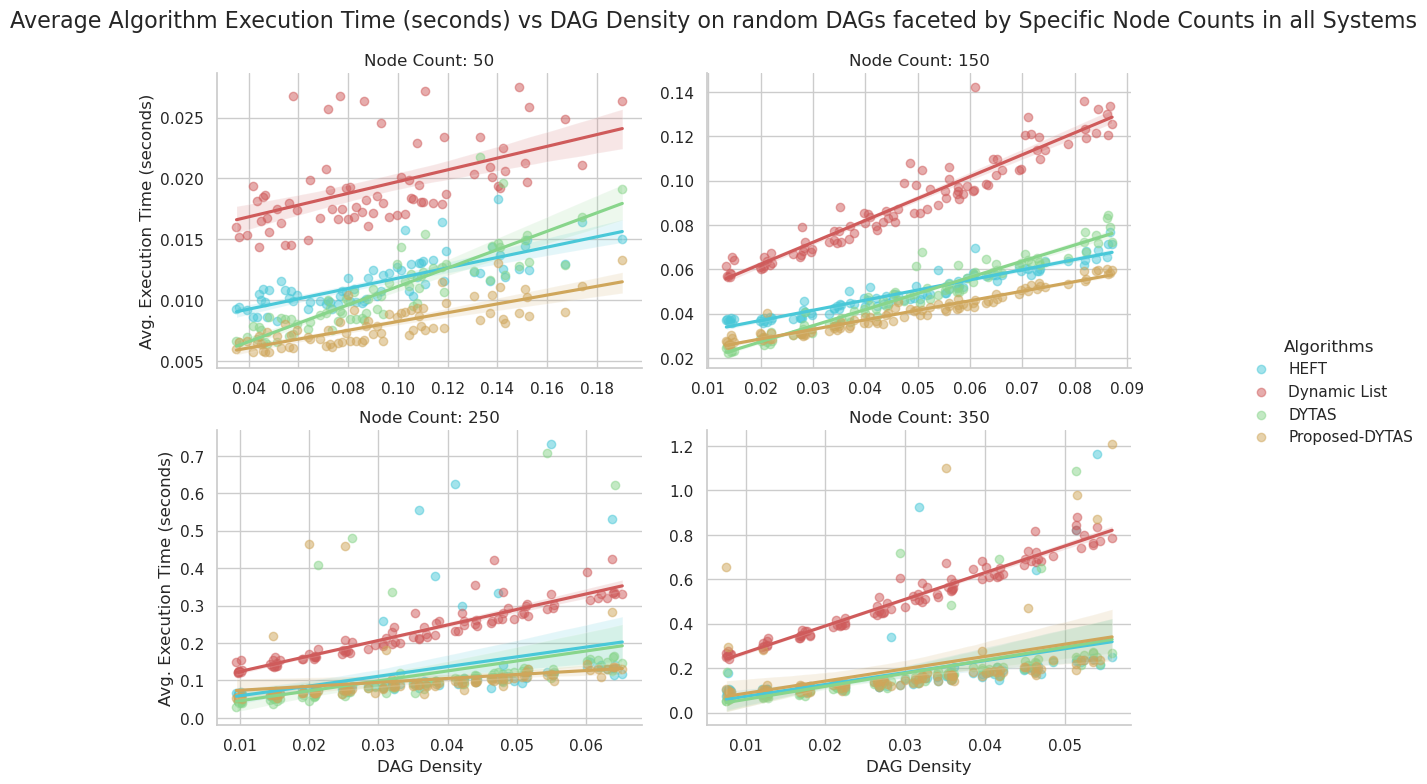

In [142]:
dag_runtime_vs_dag_density(df)

In [143]:
# dag_runtime_vs_dag_density(df[df.scheduler != "Dynamic List"])

In [144]:
# dag_runtime_vs_dag_density(df, "homogeneous")

In [145]:
# dag_runtime_vs_dag_density(df, "heterogeneous")

In [146]:
# dag_runtime_vs_dag_density(df, "single-core")

# Pairwise Rank

In [147]:
# from itertools import combinations
# from collections import defaultdict
# # import choix
# from collections import Counter

# def calculate_pairwise_comparison(df, metric, invert_comparison = False):
#     """
#     This will calculate a pairwuse comparison of each test instance
#     to see how much better each algorithm is against another on
#     the specified metric.

#     By default, smaller values are considered "better," but by
#     enabling invert_comparison, higher values are considered "better".
#     """
#     comparison_stats = defaultdict(lambda: {'B': 0, 'E': 0, 'W': 0})

#     # Group once by test id
#     for _, group in df.groupby('test_id'):
#         # Turn group into a dict: {'HLFET': 500, 'MCP': 480, ...}
#         perf = dict(zip(group['scheduler'], group[metric]))
        
#         # Only compare algorithms that are present in this test instance
#         algos_in_test = list(perf.keys())
    
#         # Do pairwise comparisons
#         for algo1, algo2 in combinations(algos_in_test, 2):
#             m1, m2 = perf[algo1], perf[algo2]

#             large_lbl = "W" if not invert_comparison else "B"
#             small_lbl = "B" if not invert_comparison else "W"
            
#             if m1 < m2:
#                 comparison_stats[(algo1, algo2)][small_lbl] += 1
#                 comparison_stats[(algo2, algo1)][large_lbl] += 1
#             elif m1 > m2:
#                 comparison_stats[(algo1, algo2)][large_lbl] += 1
#                 comparison_stats[(algo2, algo1)][small_lbl] += 1
#             else:
#                 comparison_stats[(algo1, algo2)]['E'] += 1
#                 comparison_stats[(algo2, algo1)]['E'] += 1

    
#     # Number of tests
#     n_tests = df['test_id'].nunique()
    
#     # Turn results into percentages
#     for key in comparison_stats:
#         for result in ['B', 'E', 'W']:
#             comparison_stats[key][result] = 100 * comparison_stats[key][result] / n_tests

    
#     return comparison_stats


# def rank_pairwise_comparison(comparison_stats):
#     # Initialize win rates
#     win_rate = defaultdict(float)

#     algorithms = []
    
#     # Count B (better) percentages against all other algorithms
#     for (row_alg, col_alg), results in comparison_stats.items():
#         win_rate[row_alg] += results['B']
#         if row_alg not in algorithms:
#             algorithms.append(row_alg)
    
#     # Normalize by number of opponents
#     n_opponents = len(set(algorithms)) - 1
#     for alg in win_rate:
#         win_rate[alg] /= n_opponents

#     ranking_df = pd.DataFrame.from_dict(win_rate, orient='index', columns=['Average Win Rate (%)'])
#     ranking_df.sort_values('Average Win Rate (%)', ascending=False, inplace=True)

#     return ranking_df


### All systems

In [148]:
# pairwise_makespan = calculate_pairwise_comparison(df, "makespan")
# rank_pairwise_comparison(pairwise_makespan)

In [149]:
import pandas as pd
import numpy as np
from itertools import combinations

def pairwise_wtl(
    df: pd.DataFrame,
    algo_col: str,
    metric: str,
    algos: list | None = None,
    tie_tol: float = 1e-8,
    higher_is_better: bool = True,
    as_percent: bool = False,
    pct_decimals: int = 1
) -> pd.DataFrame:
    """
    Returns a DataFrame of Win/Tie/Lose counts or percentages for each pair of algos.

    Parameters
    ----------
    df               : input DataFrame containing at least algo_col and metric.
    algo_col         : column name identifying the algorithm.
    metric           : numeric column to compare.
    algos            : optional list ordering of algorithms; defaults to unique values.
    tie_tol          : tolerance below which values are considered equal (tie).
    higher_is_better : if True, larger metric values count as wins; else smaller wins.
    as_percent       : if True, converts counts to percentages of total comparisons.
    pct_decimals     : number of decimal places when formatting percentages.

    Returns
    -------
    wtl : pd.DataFrame
        Square DataFrame indexed and columned by algorithm names, with each cell
        either (wins, ties, losses) counts or (win%, tie%, loss%) when as_percent=True.
    """
    if algos is None:
        algos = df[algo_col].unique().tolist()

    # initialize with zero tuples
    default = (0, 0, 0)
    wtl = pd.DataFrame(
        [[default for _ in algos] for _ in algos],
        index=algos, columns=algos, dtype=object
    )

    # decide direction of comparison
    multiplier = 1 if higher_is_better else -1

    for a1, a2 in combinations(algos, 2):
        x = df[df[algo_col] == a1][metric].to_numpy()
        y = df[df[algo_col] == a2][metric].to_numpy()
        n = min(len(x), len(y))
        if n == 0:
            # no data for one of the algos
            wtl.at[a1, a2] = (0, 0, 0)
            wtl.at[a2, a1] = (0, 0, 0)
            continue
        x, y = x[:n], y[:n]

        diff = multiplier * (x - y)
        wins   = int(np.sum(diff >  tie_tol))
        losses = int(np.sum(diff < -tie_tol))
        ties   = int(n - wins - losses)

        if as_percent:
            wins   = round(100 * wins   / n, pct_decimals)
            ties   = round(100 * ties   / n, pct_decimals)
            losses = round(100 * losses / n, pct_decimals)

        wtl.at[a1, a2] = (wins, ties, losses)
        wtl.at[a2, a1] = (losses, ties, wins)

    # diagonal: compare algo to itself → all ties
    for a in algos:
        count = len(df[df[algo_col] == a])
        if as_percent:
            # 100% ties with itself
            wtl.at[a, a] = (0.0, round(100.0, pct_decimals), 0.0)
        else:
            wtl.at[a, a] = (0, count, 0)

    return wtl


In [150]:
def ranking_by_win_ratio(
    wtl_table: pd.DataFrame,
    ignore_ties: bool = True
) -> pd.Series:
    """
    Given a Win/Tie/Lose DataFrame (wtl_table) where each cell [i,j] is (w,t,l),
    compute score_i = wins_i / (wins_i + losses_i) and return a descending sort.
    If ignore_ties=False, treat ties as half‑wins:
      wins_effective = wins + 0.5 * ties
      denom = wins + losses + ties
    """
    scores = {}
    for algo in wtl_table.index:
        total_wins   = 0
        total_losses = 0
        total_ties   = 0
        for opp in wtl_table.columns:
            w, t, l = wtl_table.at[algo, opp]
            total_wins   += w
            total_losses += l
            total_ties   += t
        if ignore_ties:
            denom = total_wins + total_losses
            score = total_wins / denom if denom else 0.0
        else:
            denom = total_wins + total_losses + total_ties
            score = (total_wins + 0.5 * total_ties) / denom if denom else 0.0

        scores[algo] = score

    return pd.Series(scores).sort_values(ascending=False)

# # Example usage:
# wtl = pairwise_wtl(df, algo_col="scheduler", metric="makespan",
#                    higher_is_better=False, as_percent=False)
# win_ratio_rank = ranking_by_win_ratio(wtl)
# print("Win‑Ratio Ranking:")
# display(win_ratio_rank)


In [151]:
def ranking_by_elo(
    wtl_table: pd.DataFrame,
    K: float = 32.0,
    init_rating: float = 1500.0
) -> pd.Series:
    """
    Computes Elo ratings from a Win/Tie/Lose table.
    """
    # 1) initialize
    ratings = {algo: init_rating for algo in wtl_table.index}

    # 2) iterate over each unordered pair exactly once
    from itertools import combinations
    for a1, a2 in combinations(wtl_table.index, 2):
        w, t, l = wtl_table.at[a1, a2]
        n = w + t + l
        if n == 0:
            continue

        # score: treat ties as half‑wins
        S1 = (w + 0.5 * t) / n
        S2 = 1 - S1

        R1, R2 = ratings[a1], ratings[a2]
        E1 = 1 / (1 + 10 ** ((R2 - R1) / 400))
        E2 = 1 - E1

        ratings[a1] += K * (S1 - E1)
        ratings[a2] += K * (S2 - E2)

    # 3) return sorted Series
    return pd.Series(ratings).sort_values(ascending=False)


In [152]:
import pandas as pd

def format_pairwise_wtl_table(
    wtl_df: pd.DataFrame,
    algos: list | None = None,
    fmt: str = "{:.2f} %",   # how to format the numbers in the cells
    na: str = ""            # what to show on the diagonal
) -> pd.DataFrame:
    """
    Turn a square Win/Tie/Lose table of tuples into a MultiIndex row table
    with sub‑rows ["B","E","W"] for each algorithm.

    Parameters
    ----------
    wtl_df : DataFrame
        square DataFrame, index=columns=algorithms, each cell a tuple (wins, ties, losses)
        or percentages (floats).
    algos  : list, optional
        ordering of algorithms; if None, uses wtl_df.index
    fmt    : str
        format string applied to each number, e.g. "{:.1f} %"
    na     : str
        what to put on the diagonal (usually empty string)

    Returns
    -------
    formatted : DataFrame
        MultiIndex rows (algo, ["B","E","W"]) × single‑level columns=algorithms,
        with each cell a formatted string.
    """
    if algos is None:
        algos = list(wtl_df.index)

    # build row MultiIndex
    row_tuples = []
    for algo in algos:
        for sub in ["B","E","W"]:
            row_tuples.append((algo, sub))
    row_index = pd.MultiIndex.from_tuples(row_tuples, names=["Algorithm","Outcome"])

    # prepare empty DataFrame of strings
    formatted = pd.DataFrame(index=row_index, columns=algos, dtype=object)

    # fill it
    for algo in algos:
        for col in algos:
            cell = wtl_df.at[algo, col]  # tuple (w,t,l) or (w%,t%,l%)
            for i, sub in enumerate(["B","E","W"]):
                val = na if algo == col else fmt.format(cell[i])
                formatted.at[(algo, sub), col] = val

    return formatted


In [153]:
def pairwise_helper(
    df,
    metrics=[
        ("makespan", False), ("SLR", False),
        ("speedup", True), ("efficiency_cores", True),
        ("exec_time", False)
    ]
):
    for (metric, higher_is_better) in metrics:
        wtl = pairwise_wtl(
            df,
            algo_col="scheduler",
            metric=metric,
            higher_is_better=higher_is_better,
            as_percent=True
        )

        print(metric)
        display(wtl)

        rank = ranking_by_win_ratio(wtl)
        print(rank)
        
        formatted_wtl = format_pairwise_wtl_table(wtl)
        display(formatted_wtl)



In [154]:
pairwise_wtl(df[df.system_type=="homogeneous"],algo_col="scheduler", 
             metric="makespan", higher_is_better=False, as_percent=True)

HEFT       Dynamic List              DYTAS  \
HEFT            (0.0, 100.0, 0.0)  (57.4, 33.1, 9.5)   (97.9, 0.1, 2.0)   
Dynamic List    (9.5, 33.1, 57.4)  (0.0, 100.0, 0.0)   (96.1, 0.1, 3.8)   
DYTAS            (2.0, 0.1, 97.9)   (3.8, 0.1, 96.1)  (0.0, 100.0, 0.0)   
Proposed-DYTAS  (3.0, 13.9, 83.1)  (8.3, 14.2, 77.5)   (85.2, 9.2, 5.6)   

                   Proposed-DYTAS  
HEFT            (83.1, 13.9, 3.0)  
Dynamic List    (77.5, 14.2, 8.3)  
DYTAS            (5.6, 9.2, 85.2)  
Proposed-DYTAS  (0.0, 100.0, 0.0)

In [155]:
pairwise_helper(df[df.system_type=="homogeneous"])

makespan


HEFT       Dynamic List              DYTAS  \
HEFT            (0.0, 100.0, 0.0)  (57.4, 33.1, 9.5)   (97.9, 0.1, 2.0)   
Dynamic List    (9.5, 33.1, 57.4)  (0.0, 100.0, 0.0)   (96.1, 0.1, 3.8)   
DYTAS            (2.0, 0.1, 97.9)   (3.8, 0.1, 96.1)  (0.0, 100.0, 0.0)   
Proposed-DYTAS  (3.0, 13.9, 83.1)  (8.3, 14.2, 77.5)   (85.2, 9.2, 5.6)   

                   Proposed-DYTAS  
HEFT            (83.1, 13.9, 3.0)  
Dynamic List    (77.5, 14.2, 8.3)  
DYTAS            (5.6, 9.2, 85.2)  
Proposed-DYTAS  (0.0, 100.0, 0.0)

HEFT              0.942665
Dynamic List      0.724861
Proposed-DYTAS    0.367339
DYTAS             0.039229
dtype: float64


HEFT Dynamic List    DYTAS Proposed-DYTAS
Algorithm      Outcome                                              
HEFT           B                     57.40 %  97.90 %        83.10 %
               E                     33.10 %   0.10 %        13.90 %
               W                      9.50 %   2.00 %         3.00 %
Dynamic List   B         9.50 %               96.10 %        77.50 %
               E        33.10 %                0.10 %        14.20 %
               W        57.40 %                3.80 %         8.30 %
DYTAS          B         2.00 %       3.80 %                  5.60 %
               E         0.10 %       0.10 %                  9.20 %
               W        97.90 %      96.10 %                 85.20 %
Proposed-DYTAS B         3.00 %       8.30 %  85.20 %               
               E        13.90 %      14.20 %   9.20 %               
               W        83.10 %      77.50 %   5.60 %

SLR


HEFT       Dynamic List              DYTAS  \
HEFT            (0.0, 100.0, 0.0)  (56.9, 33.6, 9.5)   (97.9, 0.1, 2.0)   
Dynamic List    (9.5, 33.6, 56.9)  (0.0, 100.0, 0.0)   (96.1, 0.1, 3.8)   
DYTAS            (2.0, 0.1, 97.9)   (3.8, 0.1, 96.1)  (0.0, 100.0, 0.0)   
Proposed-DYTAS  (3.0, 14.0, 83.0)  (8.0, 14.6, 77.5)   (85.1, 9.3, 5.6)   

                   Proposed-DYTAS  
HEFT            (83.0, 14.0, 3.0)  
Dynamic List    (77.5, 14.6, 8.0)  
DYTAS            (5.6, 9.3, 85.1)  
Proposed-DYTAS  (0.0, 100.0, 0.0)

HEFT              0.942529
Dynamic List      0.727164
Proposed-DYTAS    0.366514
DYTAS             0.039243
dtype: float64


HEFT Dynamic List    DYTAS Proposed-DYTAS
Algorithm      Outcome                                              
HEFT           B                     56.90 %  97.90 %        83.00 %
               E                     33.60 %   0.10 %        14.00 %
               W                      9.50 %   2.00 %         3.00 %
Dynamic List   B         9.50 %               96.10 %        77.50 %
               E        33.60 %                0.10 %        14.60 %
               W        56.90 %                3.80 %         8.00 %
DYTAS          B         2.00 %       3.80 %                  5.60 %
               E         0.10 %       0.10 %                  9.30 %
               W        97.90 %      96.10 %                 85.10 %
Proposed-DYTAS B         3.00 %       8.00 %  85.10 %               
               E        14.00 %      14.60 %   9.30 %               
               W        83.00 %      77.50 %   5.60 %

speedup


HEFT       Dynamic List              DYTAS  \
HEFT            (0.0, 100.0, 0.0)  (57.4, 33.1, 9.5)   (97.9, 0.1, 2.0)   
Dynamic List    (9.5, 33.1, 57.4)  (0.0, 100.0, 0.0)   (96.1, 0.1, 3.8)   
DYTAS            (2.0, 0.1, 97.9)   (3.8, 0.1, 96.1)  (0.0, 100.0, 0.0)   
Proposed-DYTAS  (3.0, 13.9, 83.1)  (8.1, 14.4, 77.5)   (85.1, 9.4, 5.6)   

                   Proposed-DYTAS  
HEFT            (83.1, 13.9, 3.0)  
Dynamic List    (77.5, 14.4, 8.1)  
DYTAS            (5.6, 9.4, 85.1)  
Proposed-DYTAS  (0.0, 100.0, 0.0)

HEFT              0.942665
Dynamic List      0.725436
Proposed-DYTAS    0.366616
DYTAS             0.039243
dtype: float64


HEFT Dynamic List    DYTAS Proposed-DYTAS
Algorithm      Outcome                                              
HEFT           B                     57.40 %  97.90 %        83.10 %
               E                     33.10 %   0.10 %        13.90 %
               W                      9.50 %   2.00 %         3.00 %
Dynamic List   B         9.50 %               96.10 %        77.50 %
               E        33.10 %                0.10 %        14.40 %
               W        57.40 %                3.80 %         8.10 %
DYTAS          B         2.00 %       3.80 %                  5.60 %
               E         0.10 %       0.10 %                  9.40 %
               W        97.90 %      96.10 %                 85.10 %
Proposed-DYTAS B         3.00 %       8.10 %  85.10 %               
               E        13.90 %      14.40 %   9.40 %               
               W        83.10 %      77.50 %   5.60 %

efficiency_cores


HEFT       Dynamic List              DYTAS  \
HEFT            (0.0, 100.0, 0.0)  (55.4, 35.2, 9.4)   (97.9, 0.1, 1.9)   
Dynamic List    (9.4, 35.2, 55.4)  (0.0, 100.0, 0.0)   (96.1, 0.2, 3.7)   
DYTAS            (1.9, 0.1, 97.9)   (3.7, 0.2, 96.1)  (0.0, 100.0, 0.0)   
Proposed-DYTAS  (3.0, 14.6, 82.5)  (7.5, 15.5, 77.0)   (85.0, 9.5, 5.5)   

                   Proposed-DYTAS  
HEFT            (82.5, 14.6, 3.0)  
Dynamic List    (77.0, 15.5, 7.5)  
DYTAS            (5.5, 9.5, 85.0)  
Proposed-DYTAS  (0.0, 100.0, 0.0)

HEFT              0.942823
Dynamic List      0.732637
Proposed-DYTAS    0.366603
DYTAS             0.038263
dtype: float64


HEFT Dynamic List    DYTAS Proposed-DYTAS
Algorithm      Outcome                                              
HEFT           B                     55.40 %  97.90 %        82.50 %
               E                     35.20 %   0.10 %        14.60 %
               W                      9.40 %   1.90 %         3.00 %
Dynamic List   B         9.40 %               96.10 %        77.00 %
               E        35.20 %                0.20 %        15.50 %
               W        55.40 %                3.70 %         7.50 %
DYTAS          B         1.90 %       3.70 %                  5.50 %
               E         0.10 %       0.20 %                  9.50 %
               W        97.90 %      96.10 %                 85.00 %
Proposed-DYTAS B         3.00 %       7.50 %  85.00 %               
               E        14.60 %      15.50 %   9.50 %               
               W        82.50 %      77.00 %   5.50 %

exec_time


HEFT       Dynamic List              DYTAS  \
HEFT            (0.0, 100.0, 0.0)   (96.9, 0.0, 3.1)  (37.2, 0.0, 62.8)   
Dynamic List     (3.1, 0.0, 96.9)  (0.0, 100.0, 0.0)   (3.9, 0.0, 96.1)   
DYTAS           (62.8, 0.0, 37.2)   (96.1, 0.0, 3.9)  (0.0, 100.0, 0.0)   
Proposed-DYTAS  (68.9, 0.0, 31.1)   (97.8, 0.0, 2.2)  (54.4, 0.0, 45.6)   

                   Proposed-DYTAS  
HEFT            (31.1, 0.0, 68.9)  
Dynamic List     (2.2, 0.0, 97.8)  
DYTAS           (45.6, 0.0, 54.4)  
Proposed-DYTAS  (0.0, 100.0, 0.0)

Proposed-DYTAS    0.737000
DYTAS             0.681667
HEFT              0.550667
Dynamic List      0.030667
dtype: float64


HEFT Dynamic List    DYTAS Proposed-DYTAS
Algorithm      Outcome                                              
HEFT           B                     96.90 %  37.20 %        31.10 %
               E                      0.00 %   0.00 %         0.00 %
               W                      3.10 %  62.80 %        68.90 %
Dynamic List   B         3.10 %                3.90 %         2.20 %
               E         0.00 %                0.00 %         0.00 %
               W        96.90 %               96.10 %        97.80 %
DYTAS          B        62.80 %      96.10 %                 45.60 %
               E         0.00 %       0.00 %                  0.00 %
               W        37.20 %       3.90 %                 54.40 %
Proposed-DYTAS B        68.90 %      97.80 %  54.40 %               
               E         0.00 %       0.00 %   0.00 %               
               W        31.10 %       2.20 %  45.60 %

In [156]:
pairwise_helper(df[df.system_type=="heterogeneous"])

makespan


HEFT       Dynamic List              DYTAS  \
HEFT            (0.0, 100.0, 0.0)  (84.9, 10.7, 4.4)   (98.6, 0.0, 1.4)   
Dynamic List    (4.4, 10.7, 84.9)  (0.0, 100.0, 0.0)   (96.7, 0.0, 3.3)   
DYTAS            (1.4, 0.0, 98.6)   (3.3, 0.0, 96.7)  (0.0, 100.0, 0.0)   
Proposed-DYTAS   (1.4, 4.2, 94.4)   (7.6, 4.3, 88.1)   (85.4, 6.3, 8.4)   

                   Proposed-DYTAS  
HEFT             (94.4, 4.2, 1.4)  
Dynamic List     (88.1, 4.3, 7.6)  
DYTAS            (8.4, 6.3, 85.4)  
Proposed-DYTAS  (0.0, 100.0, 0.0)

HEFT              0.974746
Dynamic List      0.663860
Proposed-DYTAS    0.330880
DYTAS             0.044588
dtype: float64


HEFT Dynamic List    DYTAS Proposed-DYTAS
Algorithm      Outcome                                              
HEFT           B                     84.90 %  98.60 %        94.40 %
               E                     10.70 %   0.00 %         4.20 %
               W                      4.40 %   1.40 %         1.40 %
Dynamic List   B         4.40 %               96.70 %        88.10 %
               E        10.70 %                0.00 %         4.30 %
               W        84.90 %                3.30 %         7.60 %
DYTAS          B         1.40 %       3.30 %                  8.40 %
               E         0.00 %       0.00 %                  6.30 %
               W        98.60 %      96.70 %                 85.40 %
Proposed-DYTAS B         1.40 %       7.60 %  85.40 %               
               E         4.20 %       4.30 %   6.30 %               
               W        94.40 %      88.10 %   8.40 %

SLR


HEFT       Dynamic List              DYTAS  \
HEFT            (0.0, 100.0, 0.0)  (84.7, 10.9, 4.4)   (98.6, 0.0, 1.4)   
Dynamic List    (4.4, 10.9, 84.7)  (0.0, 100.0, 0.0)   (96.7, 0.0, 3.3)   
DYTAS            (1.4, 0.0, 98.6)   (3.3, 0.0, 96.7)  (0.0, 100.0, 0.0)   
Proposed-DYTAS   (1.4, 4.3, 94.3)   (7.6, 4.3, 88.1)   (85.3, 6.4, 8.3)   

                   Proposed-DYTAS  
HEFT             (94.3, 4.3, 1.4)  
Dynamic List     (88.1, 4.3, 7.6)  
DYTAS            (8.3, 6.4, 85.3)  
Proposed-DYTAS  (0.0, 100.0, 0.0)

HEFT              0.974719
Dynamic List      0.664326
Proposed-DYTAS    0.330877
DYTAS             0.044278
dtype: float64


HEFT Dynamic List    DYTAS Proposed-DYTAS
Algorithm      Outcome                                              
HEFT           B                     84.70 %  98.60 %        94.30 %
               E                     10.90 %   0.00 %         4.30 %
               W                      4.40 %   1.40 %         1.40 %
Dynamic List   B         4.40 %               96.70 %        88.10 %
               E        10.90 %                0.00 %         4.30 %
               W        84.70 %                3.30 %         7.60 %
DYTAS          B         1.40 %       3.30 %                  8.30 %
               E         0.00 %       0.00 %                  6.40 %
               W        98.60 %      96.70 %                 85.30 %
Proposed-DYTAS B         1.40 %       7.60 %  85.30 %               
               E         4.30 %       4.30 %   6.40 %               
               W        94.30 %      88.10 %   8.30 %

speedup


HEFT       Dynamic List              DYTAS  \
HEFT            (0.0, 100.0, 0.0)  (84.9, 10.7, 4.4)   (98.6, 0.0, 1.4)   
Dynamic List    (4.4, 10.7, 84.9)  (0.0, 100.0, 0.0)   (96.7, 0.1, 3.2)   
DYTAS            (1.4, 0.0, 98.6)   (3.2, 0.1, 96.7)  (0.0, 100.0, 0.0)   
Proposed-DYTAS   (1.4, 4.3, 94.4)   (7.6, 4.4, 88.0)   (85.3, 6.4, 8.3)   

                   Proposed-DYTAS  
HEFT             (94.4, 4.3, 1.4)  
Dynamic List     (88.0, 4.4, 7.6)  
DYTAS            (8.3, 6.4, 85.3)  
Proposed-DYTAS  (0.0, 100.0, 0.0)

HEFT              0.974746
Dynamic List      0.663975
Proposed-DYTAS    0.330877
DYTAS             0.043952
dtype: float64


HEFT Dynamic List    DYTAS Proposed-DYTAS
Algorithm      Outcome                                              
HEFT           B                     84.90 %  98.60 %        94.40 %
               E                     10.70 %   0.00 %         4.30 %
               W                      4.40 %   1.40 %         1.40 %
Dynamic List   B         4.40 %               96.70 %        88.00 %
               E        10.70 %                0.10 %         4.40 %
               W        84.90 %                3.20 %         7.60 %
DYTAS          B         1.40 %       3.20 %                  8.30 %
               E         0.00 %       0.10 %                  6.40 %
               W        98.60 %      96.70 %                 85.30 %
Proposed-DYTAS B         1.40 %       7.60 %  85.30 %               
               E         4.30 %       4.40 %   6.40 %               
               W        94.40 %      88.00 %   8.30 %

efficiency_cores


HEFT       Dynamic List              DYTAS  \
HEFT            (0.0, 100.0, 0.0)  (83.1, 12.5, 4.4)   (98.6, 0.1, 1.3)   
Dynamic List    (4.4, 12.5, 83.1)  (0.0, 100.0, 0.0)   (96.7, 0.1, 3.2)   
DYTAS            (1.3, 0.1, 98.6)   (3.2, 0.1, 96.7)  (0.0, 100.0, 0.0)   
Proposed-DYTAS   (1.4, 4.4, 94.3)   (7.5, 4.5, 88.0)   (85.2, 6.5, 8.2)   

                   Proposed-DYTAS  
HEFT             (94.3, 4.4, 1.4)  
Dynamic List     (88.0, 4.5, 7.5)  
DYTAS            (8.2, 6.5, 85.2)  
Proposed-DYTAS  (0.0, 100.0, 0.0)

HEFT              0.974921
Dynamic List      0.668434
Proposed-DYTAS    0.330639
DYTAS             0.043315
dtype: float64


HEFT Dynamic List    DYTAS Proposed-DYTAS
Algorithm      Outcome                                              
HEFT           B                     83.10 %  98.60 %        94.30 %
               E                     12.50 %   0.10 %         4.40 %
               W                      4.40 %   1.30 %         1.40 %
Dynamic List   B         4.40 %               96.70 %        88.00 %
               E        12.50 %                0.10 %         4.50 %
               W        83.10 %                3.20 %         7.50 %
DYTAS          B         1.30 %       3.20 %                  8.20 %
               E         0.10 %       0.10 %                  6.50 %
               W        98.60 %      96.70 %                 85.20 %
Proposed-DYTAS B         1.40 %       7.50 %  85.20 %               
               E         4.40 %       4.50 %   6.50 %               
               W        94.30 %      88.00 %   8.20 %

exec_time


HEFT       Dynamic List              DYTAS  \
HEFT            (0.0, 100.0, 0.0)   (96.4, 0.0, 3.6)  (31.2, 0.0, 68.8)   
Dynamic List     (3.6, 0.0, 96.4)  (0.0, 100.0, 0.0)   (4.2, 0.0, 95.8)   
DYTAS           (68.8, 0.0, 31.2)   (95.8, 0.0, 4.2)  (0.0, 100.0, 0.0)   
Proposed-DYTAS  (75.1, 0.0, 24.9)   (98.1, 0.0, 1.9)  (52.1, 0.0, 47.9)   

                   Proposed-DYTAS  
HEFT            (24.9, 0.0, 75.1)  
Dynamic List     (1.9, 0.0, 98.1)  
DYTAS           (47.9, 0.0, 52.1)  
Proposed-DYTAS  (0.0, 100.0, 0.0)

Proposed-DYTAS    0.751000
DYTAS             0.708333
HEFT              0.508333
Dynamic List      0.032333
dtype: float64


HEFT Dynamic List    DYTAS Proposed-DYTAS
Algorithm      Outcome                                              
HEFT           B                     96.40 %  31.20 %        24.90 %
               E                      0.00 %   0.00 %         0.00 %
               W                      3.60 %  68.80 %        75.10 %
Dynamic List   B         3.60 %                4.20 %         1.90 %
               E         0.00 %                0.00 %         0.00 %
               W        96.40 %               95.80 %        98.10 %
DYTAS          B        68.80 %      95.80 %                 47.90 %
               E         0.00 %       0.00 %                  0.00 %
               W        31.20 %       4.20 %                 52.10 %
Proposed-DYTAS B        75.10 %      98.10 %  52.10 %               
               E         0.00 %       0.00 %   0.00 %               
               W        24.90 %       1.90 %  47.90 %

In [157]:
# wtl_makespan_hom = pairwise_wtl(
#     df[df.system_type=="homogeneous"],
#     algo_col="scheduler",
#     metric="makespan",
#     higher_is_better=False,
#     as_percent=True
# )

# display(wtl_makespan_hom)

In [158]:
# format_pairwise_wtl_table(wtl_makespan_hom)

In [159]:
# ranking_by_win_ratio(wtl_makespan_hom)

In [160]:
# ranking_by_elo(wtl_makespan_hom)

In [161]:
# wtl_makespan_het = pairwise_wtl(
#     df[df.system_type=="heterogeneous"],
#     algo_col="scheduler",
#     metric="makespan",
#     higher_is_better=False,
#     as_percent=True
# )

# display(wtl_makespan_het)

In [162]:
# ranking_by_win_ratio(wtl_makespan_het)

In [163]:
# ranking_by_elo(wtl_makespan_het)

In [164]:
# pairwise_wtl(
#     df[df.system_type=="homogeneous"],
#     algo_col="scheduler",
#     metric="SLR",
#     higher_is_better=False,
#     as_percent=True
# )

In [165]:
# pairwise_wtl(
#     df[df.system_type=="homogeneous"],
#     algo_col="scheduler",
#     metric="speedup",
#     higher_is_better=True,
#     as_percent=True
# )

In [166]:
# pairwise_wtl(
#     df[df.system_type=="homogeneous"],
#     algo_col="scheduler",
#     metric="efficiency_cores",
#     higher_is_better=True,
#     as_percent=True
# )

In [167]:
# pairwise_wtl(
#     df[df.system_type=="homogeneous"],
#     algo_col="scheduler",
#     metric="exec_time",
#     higher_is_better=False,
#     as_percent=True
# )

In [168]:
# pairwise_makespan

In [169]:
# index_tuples = []
# table_data = []

# algorithms = sorted({a for pair in pairwise_makespan.keys() for a in pair})

# # Build multi-index rows: for each algorithm, create rows for B, E, W
# for row_alg in algorithms:
#     for metric in ['B', 'E', 'W']:
#         index_tuples.append((row_alg, metric))
#         row = []
#         for col_alg in algorithms:
#             if row_alg == col_alg:
#                 row.append("")  # leave diagonal empty
#             else:
#                 value = pairwise_makespan.get((row_alg, col_alg), {}).get(metric, None)
#                 row.append(f"{value:.2f}%" if value is not None else "")
#         table_data.append(row)

# # Create a MultiIndex DataFrame
# index = pd.MultiIndex.from_tuples(index_tuples, names=["Algorithm", "Result"])
# comparison_df = pd.DataFrame(table_data, index=index, columns=algorithms)

# display(comparison_df)

In [170]:
# pairwise_speedup = calculate_pairwise_comparison(df, "speedup", True)
# rank_pairwise_comparison(pairwise_speedup)

In [171]:
# pairwise_efficiency = calculate_pairwise_comparison(df, "efficiency_cores", True)
# rank_pairwise_comparison(pairwise_efficiency)

In [172]:
# pairwise_exec_time = calculate_pairwise_comparison(df, "exec_time")
# rank_pairwise_comparison(pairwise_exec_time)

### Homogeneous Systems

In [173]:
# pairwise_makespan = calculate_pairwise_comparison(filter_by_system(df, "homogeneous"), "makespan")
# rank_pairwise_comparison(pairwise_makespan)

In [174]:
# pairwise_speedup = calculate_pairwise_comparison(filter_by_system(df, "homogeneous"), "speedup", True)
# rank_pairwise_comparison(pairwise_speedup)

In [175]:
# pairwise_efficiency = calculate_pairwise_comparison(filter_by_system(df, "homogeneous"), "efficiency_cores", True)
# rank_pairwise_comparison(pairwise_efficiency)

In [176]:
# pairwise_exec_time = calculate_pairwise_comparison(filter_by_system(df, "homogeneous"), "exec_time")
# rank_pairwise_comparison(pairwise_exec_time)

### Heterogeneous Systems

In [177]:
# pairwise_makespan = calculate_pairwise_comparison(filter_by_system(df, "heterogeneous"), "makespan")
# rank_pairwise_comparison(pairwise_makespan)

In [178]:
# pairwise_speedup = calculate_pairwise_comparison(filter_by_system(df, "heterogeneous"), "speedup", True)
# rank_pairwise_comparison(pairwise_speedup)

In [179]:
# pairwise_efficiency = calculate_pairwise_comparison(filter_by_system(df, "heterogeneous"), "efficiency_cores", True)
# rank_pairwise_comparison(pairwise_efficiency)

In [180]:
# pairwise_exec_time = calculate_pairwise_comparison(filter_by_system(df, "heterogeneous"), "exec_time")
# rank_pairwise_comparison(pairwise_exec_time)

# Random Forrest Regression

Applying random forest regressor to check what independet variables impact these the most.

In [181]:
# Encoding nominal values
vars_to_encode = ["system_type", "network_model", "workflow"]
encoder = OneHotEncoder(sparse_output=False)

encoded_features = encoder.fit_transform(df[vars_to_encode])
encoded_columns = encoder.get_feature_names_out(vars_to_encode)
df = df.join(pd.DataFrame(encoded_features, columns=encoded_columns))

In [182]:
def random_forest_regressor(df, dependent_var, independent_vars):
    scheduler_col = "scheduler"
    
    # List to store feature importance data
    feature_importance_data = []
    
    # Iterate through each unique scheduler
    for scheduler in df[scheduler_col].unique():
        # Filter data for the current scheduler
        df_scheduler = df[df[scheduler_col] == scheduler]
        
        # Separate independent and dependent variables
        X = df_scheduler[independent_vars]
        y = df_scheduler[dependent_var]
        
        # Train the Regressor
        model = RandomForestRegressor(random_state=0, n_estimators=100)
        model.fit(X, y)
        
        # Extract feature importances
        importances = model.feature_importances_
        
        # Store the results
        for i, imp in enumerate(importances):
            feature_importance_data.append({'Scheduler': scheduler,
                                            'Feature': independent_vars[i],
                                            'Importance': imp})
    
    # Convert to DataFrame for visualization
    importance_df = pd.DataFrame(feature_importance_data)
    
    # Set the figure size
    plt.figure(figsize=(12, 8))
    
    # Create a barplot with dodging to separate bars by scheduler
    sns.barplot(data=importance_df, x='Feature', y='Importance', hue='Scheduler', 
                hue_order=hue_order,
                palette=cmap,
                dodge=True)
    
    # Add labels and title
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance by Scheduler for ' + dependent_var)
    plt.legend(title='Scheduler')
    
    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent clipping of labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [183]:
df.columns

Index(['dag', 'system', 'scheduler', 'makespan', 'exec_time',
       'run_stats.total_task_time', 'run_stats.total_network_traffic',
       'run_stats.total_network_time', 'run_stats.max_used_cores',
       'run_stats.max_cpu_utilization', 'run_stats.cpu_utilization',
       'run_stats.memory_utilization', 'run_stats.used_resource_count',
       'run_stats.cpu_utilization_used', 'run_stats.cpu_utilization_active',
       'dag_nodes', 'dag_edges', 'dag_density', 'dag_total_comp_size',
       'dag_total_transfers_size', 'dag_depth', 'dag_width',
       'dag_parallelism_degree', 'dag_critical_path_size', 'CCR', 'speedup',
       'processor_count', 'core_count', 'efficiency_processors',
       'efficiency_cores', 'network_bandwidth', 'network_latency',
       'network_model', 'min_processor_speed', 'max_processor_speed', 'SLR',
       'workflow', 'test_id', 'system_type', 'makespan_outlier',
       'system_type_heterogeneous', 'system_type_homogeneous',
       'network_model_ConstantBandwi

In [204]:
ind_variables = [
    'dag_nodes', 'dag_density',
    'CCR',
    'processor_count', 'core_count',
    'system_type_heterogeneous', 'system_type_homogeneous',
       'network_model_ConstantBandwidth', 'network_model_SharedBandwidth',
       'workflow_1000genome', 'workflow_blast', 'workflow_bwa',
       'workflow_cycles', 'workflow_epigenomics', 'workflow_montage',
       'workflow_random', 'workflow_seismology', 'workflow_soykb',
       'workflow_srasearch',
    'workflow_random'
]

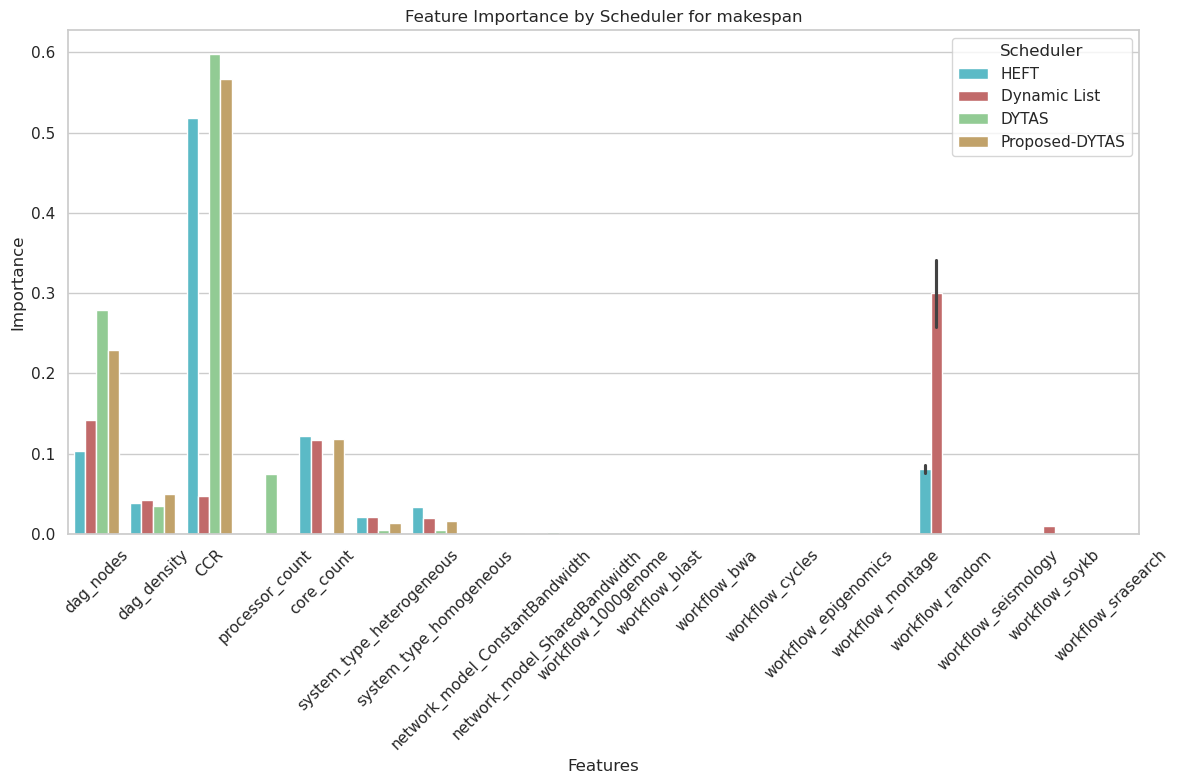

In [205]:
random_forest_regressor(df[df.makespan_outlier == False], "makespan", ind_variables)

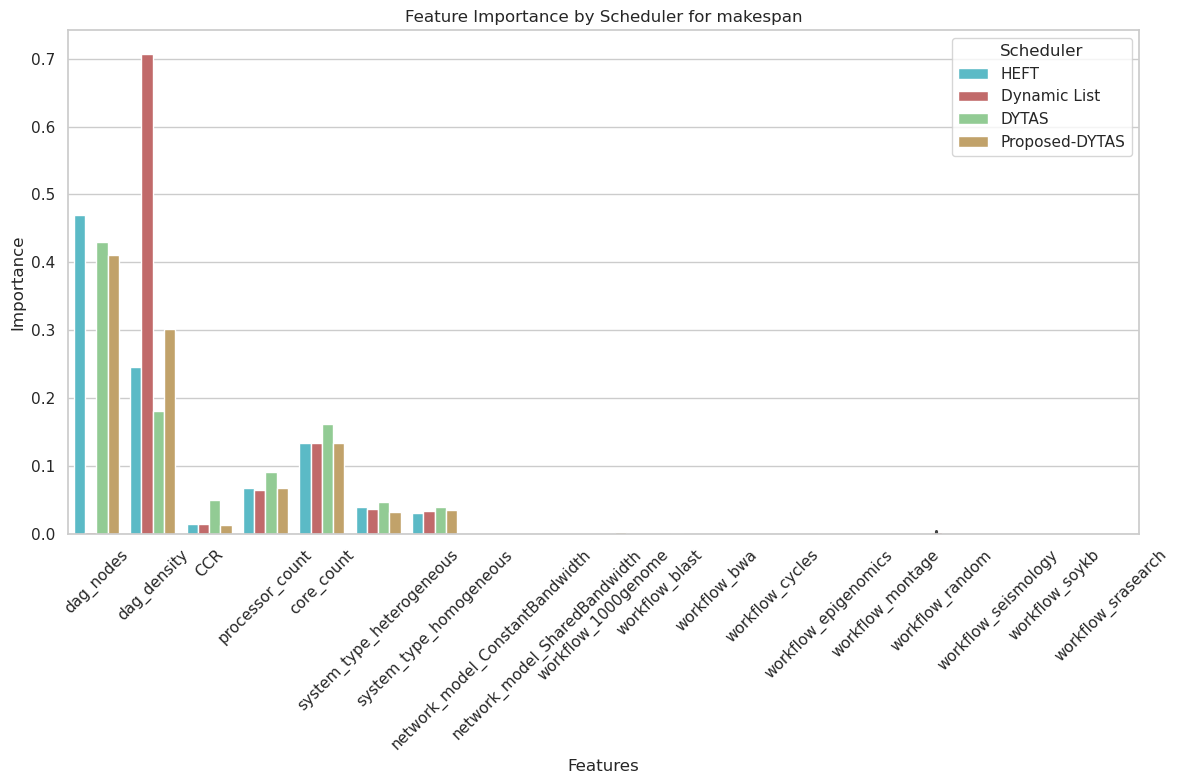

In [206]:
random_forest_regressor(df[df.makespan_outlier == True], "makespan", ind_variables)

The above values suggest that the non outlier values seem to be heavily influenced by the montage workflow. The outliers not, but seem to be more influenced by the density of the DAG.

This suggests to me that it is better to separate these distribution visualizations ber workflow instance, since I know there is a predominance of 400 DAGs that come from DAGGEN that are hevily controlle by their density.

In [187]:
ind_variables = [
    'dag_nodes', 'dag_density',
    'CCR',
    # 'processor_count', 
    'core_count',
    # 'system_type_heterogeneous', 'system_type_homogeneous',
       'network_model_ConstantBandwidth', 'network_model_SharedBandwidth',
       # 'workflow_1000genome', 'workflow_blast', 'workflow_bwa',
       # 'workflow_cycles', 'workflow_epigenomics', 'workflow_montage',
       # 'workflow_random', 'workflow_seismology', 'workflow_soykb',
       # 'workflow_srasearch'
]

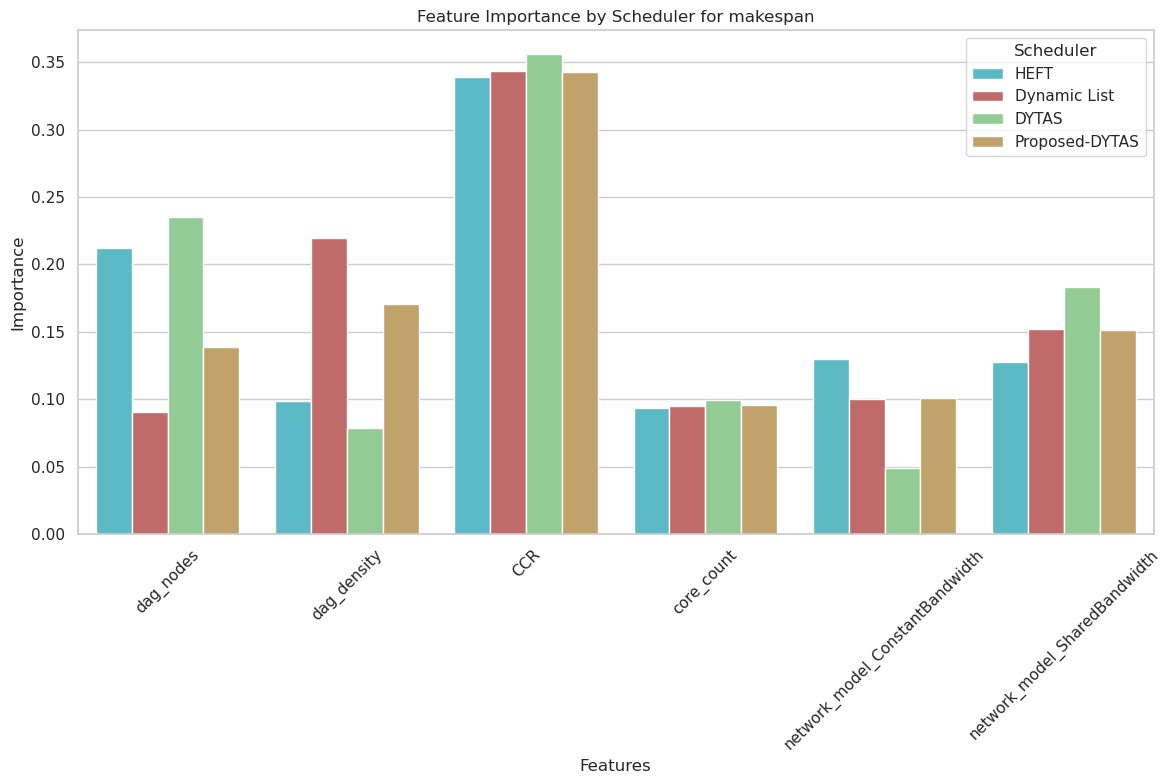

In [188]:
random_forest_regressor(df[df.system_type == "homogeneous"], "makespan", ind_variables)

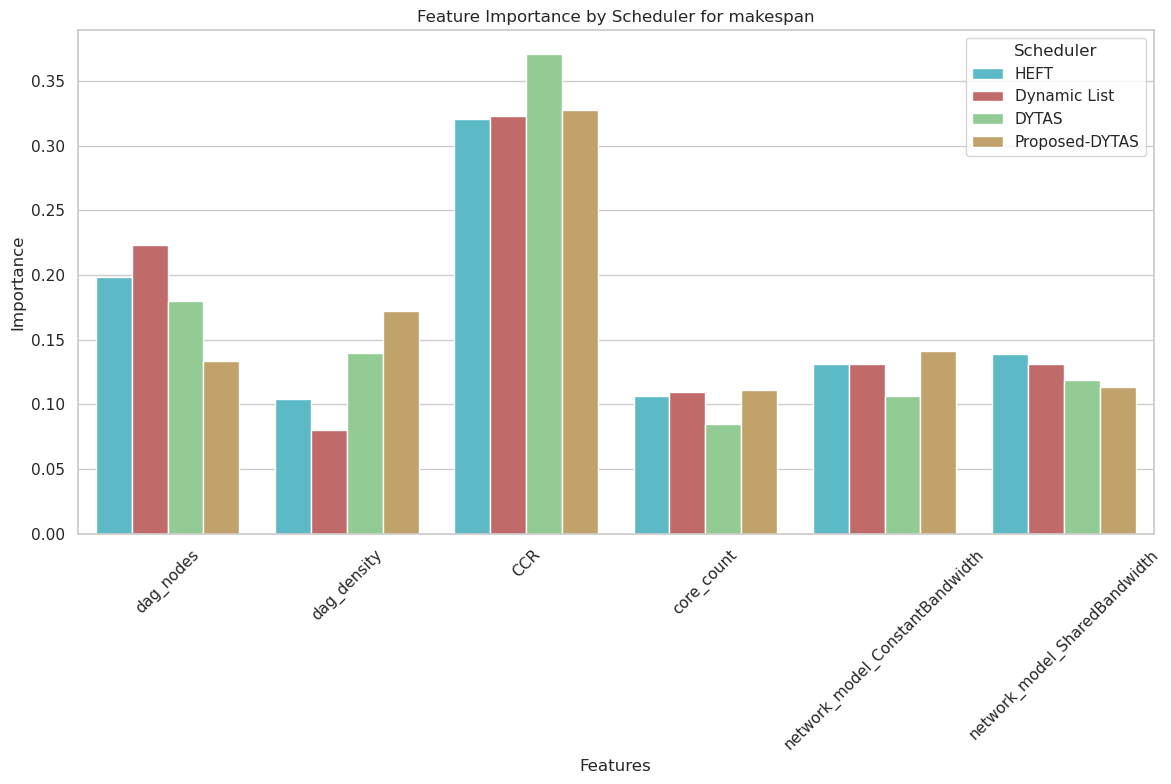

In [189]:
random_forest_regressor(df[df.system_type == "heterogeneous"], "makespan", ind_variables)

In [190]:
from sklearn.ensemble import RandomForestRegressor

def fit_rf(df, features, target="makespan", **rf_kwargs):
    X = df[features]; y = df[target]
    model = RandomForestRegressor(**rf_kwargs)
    model.fit(X, y)
    return model


In [191]:
df_dytas = df[df.scheduler=="DYTAS"]

model = fit_rf(df_dytas, ind_variables)

In [192]:


# from sklearn.inspection import permutation_importance
# perm = permutation_importance(model, X, y, n_repeats=30, random_state=0)


In [193]:
# import shap
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X)


In [194]:
# import pandas as pd
# import matplotlib.pyplot as plt

# feat_imp = pd.Series(model.feature_importances_, index=features)
# feat_imp.sort_values().plot.barh()
# plt.title("Feature importances (MDI)") 
# plt.show()


In [195]:
# perm_imp = pd.Series(perm.importances_mean, index=features)
# perm_imp.sort_values().plot.barh()
# plt.title("Permutation Importances")  
# plt.show()


In [196]:
# from sklearn.inspection import PartialDependenceDisplay

# PartialDependenceDisplay.from_estimator(
#     model, X, features=["dag_density","core_count"], kind="both"
# )
# plt.show()


In [197]:
# shap.summary_plot(shap_values, X)
# shap.decision_plot(explainer.expected_value, shap_values, X)


In [216]:
def regressor_helper(df, features):
    all_imp = []
    for algo, subdf in df.groupby("scheduler"):
        m = fit_rf(subdf, features)
        imp = pd.Series(m.feature_importances_, index=features).reset_index()
        imp.columns = ["feature","importance"]
        imp["algorithm"] = algo
        all_imp.append(imp)
    
    imp_df = pd.concat(all_imp)

    plt.figure(figsize=(7, 10))
    sns.barplot(data=imp_df, x="importance", y="feature", hue="algorithm")
    plt.title("Feature importances by scheduler")
    plt.show()


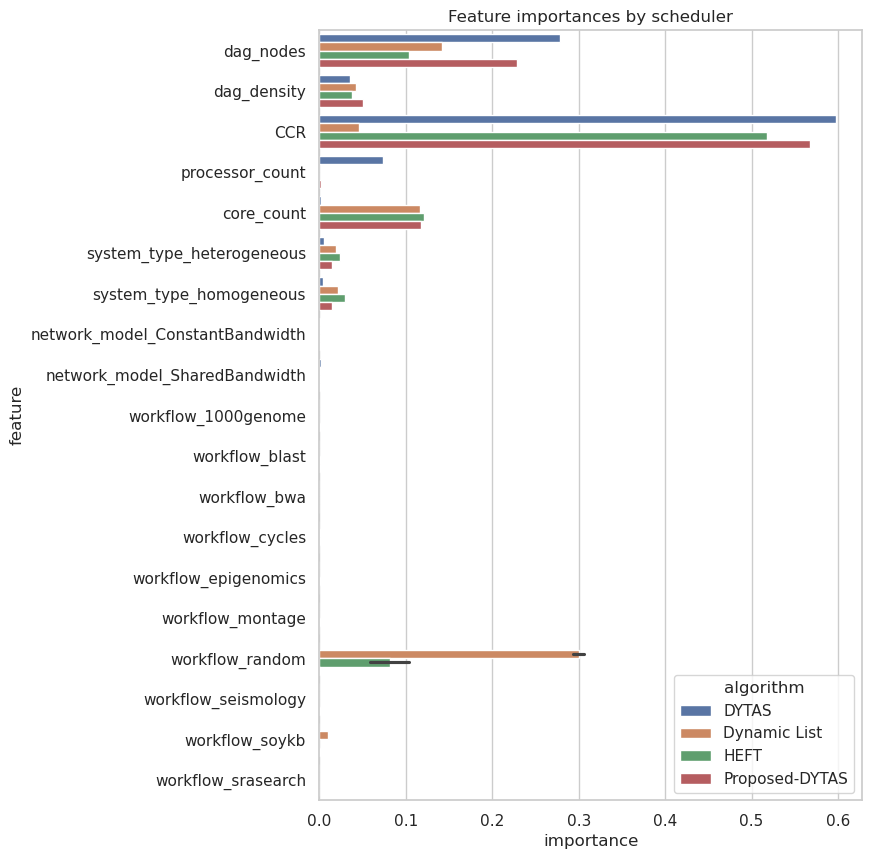

In [217]:
regressor_helper(df[df.makespan_outlier == False], ind_variables)

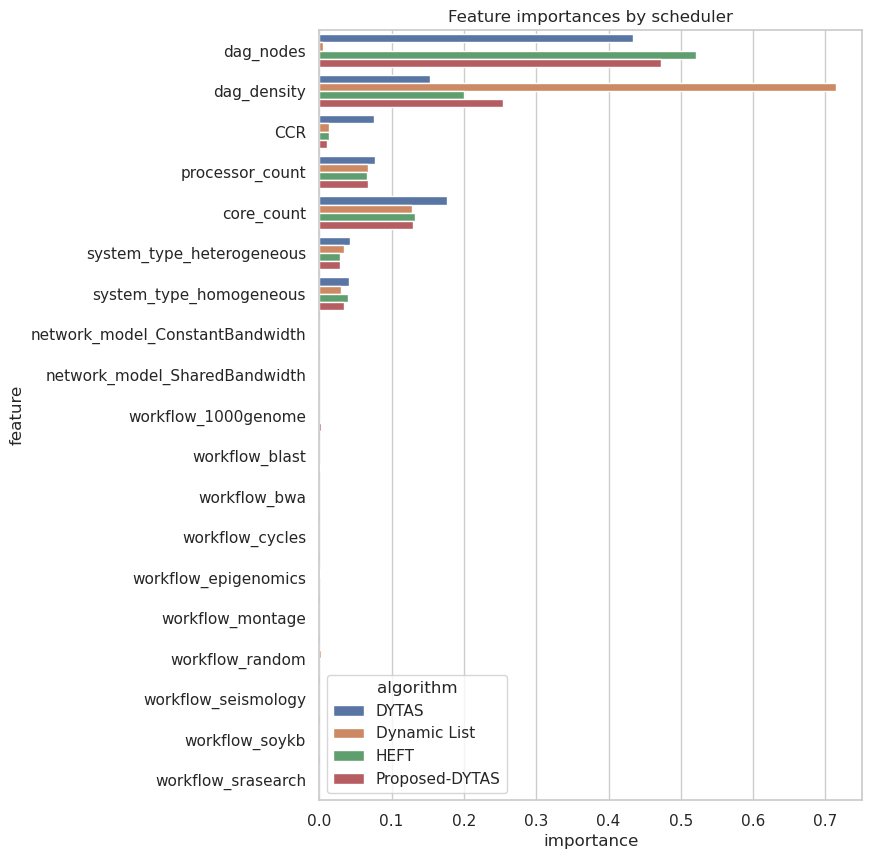

In [218]:
regressor_helper(df[df.makespan_outlier == True], ind_variables)

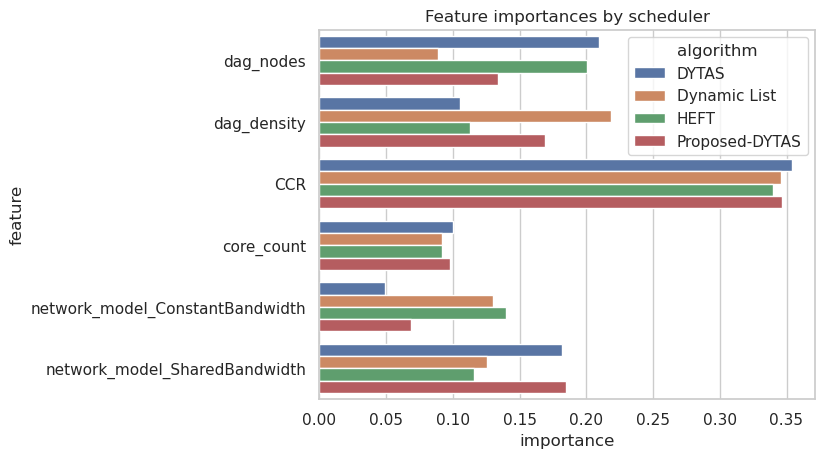

In [199]:
regressor_helper(df[df.system_type=="homogeneous"], ind_variables)

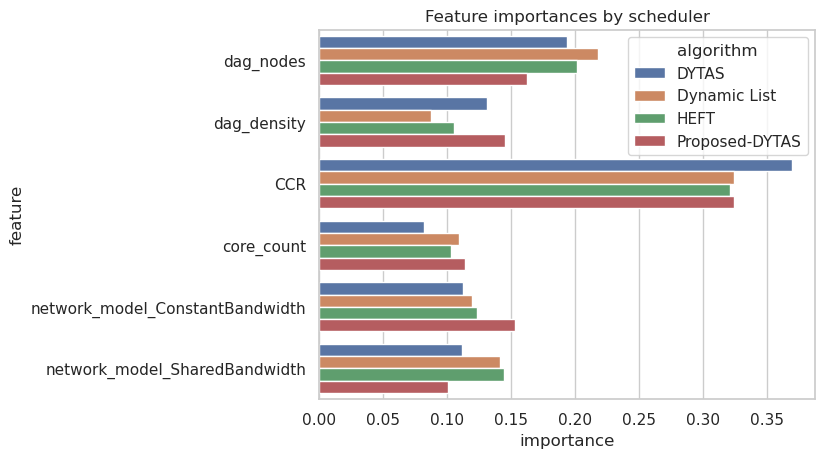

In [200]:
regressor_helper(df[df.system_type=="heterogeneous"], ind_variables)

In [201]:
# import seaborn as sns

# all_imp = []
# for algo, subdf in df.groupby("scheduler"):
#     m = fit_rf(subdf, ind_variables)
#     imp = pd.Series(m.feature_importances_, index=ind_variables).reset_index()
#     imp.columns = ["feature","importance"]
#     imp["algorithm"] = algo
#     all_imp.append(imp)

# imp_df = pd.concat(all_imp)
# sns.barplot(data=imp_df, x="importance", y="feature", hue="algorithm")
# plt.title("Feature importances by scheduler")
# plt.show()


In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

def feature_importance_analysis(
    df: pd.DataFrame,
    algo_col: str,
    algorithm: str,
    features: list[str],
    target: str,
    random_state: int = 0,
    top_n: int = 10
) -> pd.DataFrame:
    """
    For the specified algorithm in `df[algo_col] == algorithm`, fits a RandomForestRegressor
    to predict `target` from `features`, then computes and plots:
      • impurity-based importances (MDI),
      • permutation importances,
      • SHAP values (Tree SHAP).
    Returns a DataFrame of the top_n features by MDI.
    """
    # 1. Subset data
    df_sub = df[df[algo_col] == algorithm].copy()
    X = df_sub[features]
    y = df_sub[target]

    # 2. Identify categorical and numeric columns
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = [c for c in features if c not in cat_cols]

    # 3. Build preprocessing + model pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(drop='first', sparse=False), cat_cols),
    ], remainder='passthrough')
    model = Pipeline([
        ('pre', preprocessor),
        ('rf', RandomForestRegressor(random_state=random_state))
    ])

    # 4. Fit the model
    model.fit(X, y)  # :contentReference[oaicite:0]{index=0}

    # 5. Extract MDI importances
    mdi = model.named_steps['rf'].feature_importances_  # :contentReference[oaicite:1]{index=1}

    # 6. Compute permutation importances
    perm = permutation_importance(model, X, y, n_repeats=10, random_state=random_state)
    perm_means = perm.importances_mean               # :contentReference[oaicite:2]{index=2}

    # 7. Compute SHAP values
    #    Use TreeExplainer on the underlying RF; transform data via the preprocessor
    explainer = shap.TreeExplainer(model.named_steps['rf'])  # :contentReference[oaicite:3]{index=3}
    X_trans = preprocessor.fit_transform(X)
    shap_values = explainer.shap_values(X_trans)
    shap_means = np.abs(shap_values).mean(axis=0)

    # 8. Assemble results into a DataFrame
    feature_names = preprocessor.get_feature_names_out()
    imp_df = pd.DataFrame({
        'feature': feature_names,
        'mdi': mdi,
        'perm': perm_means,
        'shap': shap_means
    }).sort_values('mdi', ascending=False).head(top_n)

    # 9. Plot horizontal bar chart of importances
    imp_df.set_index('feature')[['mdi','perm','shap']].plot(
        kind='barh', figsize=(10, 6)
    )
    plt.xlabel('Importance')
    plt.title(f'Feature Importances for {algorithm}')
    plt.tight_layout()
    plt.show()

    return imp_df


In [203]:
# for algo in df['scheduler'].unique():
#     print(algo)
#     imp = feature_importance_analysis(
#         df, algo_col='scheduler', algorithm=algo,
#         features=ind_variables,
#         target='makespan'
#     )
#     display(imp)
